In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import re
import math
import os
import copy
os.environ['KMP_DUPLICATE_LIB_OK']='True'
sys.path.append(os.path.join(os.path.abspath(os.getcwd()),".."))
sys.path.append(os.path.join(os.path.abspath(os.getcwd()),"../.."))
#ys.path.append(os.path.join(os.path.abspath(os.getcwd()),"../../.."))
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))

In [2]:
# import MEIRL Modules
from maxent_irl.maxent_irl_utils import *
#from maxent_irl.Reward_Expert import *
from maxent_irl.maxent_irl import *
from utils.trajectory import Trajectory
from utils.plot_utils import *

In [3]:
# Settings for the different cases
feat_list_cases = [["laptop", "coffee", "table"],["laptop", "coffee", "table"], ["proxemics", "coffee", "table"]]
weights_cases = [[10.0, 0.0, 10.0], [10.0, 0.0, 10.0], [10.0, 0.0, 10.0]]
known_features_cases = [["table", "coffee"], ["laptop", "coffee"], ["table", "coffee"]]

traj_feat_list = [ "tablelaptop_case1", "tablelaptop_case2", "tableproxemics_case3"]
traj_idx_list = [[4, 13,0, 15], [0,1,2,3,4,5,6,7], [1,2,3,4,6]]


# TrajOpt Settings
obj_center_dict = {'HUMAN_CENTER': [-0.2, -0.5, 0.6], 'LAPTOP_CENTER': [-0.6, 0.0, 0.0]}
T = 20.0
timestep=0.5

In [4]:
# Settings for the different cases
feat_list_cases = [[]]
weights_cases = [[]]
known_features_cases = [[]]

traj_feat_list = []
traj_idx_list = [[0,1,2,3,4]]


# TrajOpt Settings
obj_center_dict = {'HUMAN_CENTER': [-0.2, -0.5, 0.6], 'LAPTOP_CENTER': [-0.6, 0.0, 0.0]}
T = 20.0
timestep=0.5

# 1. Load or Generate near-optimal expert demonstrations

In [5]:
# Setting for which Case (see paper)
case = 1

# adjust accordingly
feat_list = feat_list_cases[case-1]
weights = weights_cases[case-1]
known_features = known_features_cases[case-1]

## 1.1 Load human expert demonstrations

In [6]:
def load_demonstrations(paths):
    trajectory_list = [np.load(path) for path in paths]
    s_g_exp_trajs = []
    for i, trajectory in enumerate(trajectory_list):
        if i not in traj_idx_list[case-1]:
            continue
        waypts = trajectory
        waypts_time = np.linspace(0.0, T, waypts.shape[0])
        traj = Trajectory(waypts, waypts_time)

        # Downsample/Upsample trajectory to fit desired timestep and T.
        num_waypts = int(T / timestep) + 1
        if num_waypts < len(traj.waypts):
            demo = traj.downsample(int(T / timestep) + 1)
        else:
            demo = traj.upsample(int(T / timestep) + 1)
        s_g_exp_trajs.append([demo.waypts])
    return s_g_exp_trajs

In [8]:
# CHANGED
trajectory_list = [np.load(parent_dir + '/../jaco_learning/data/pour_red{}.npy'.format(i)) for i in range(5)]

# ORIGINAL
# # load in a set of demonstraations
# data_file = parent_dir + '/data/MEIRL_demonstrations/demos_{}.p'.format(traj_feat_list[case-1])
# trajectory_list = pickle.load(open( data_file, "rb" ) )

# select subset of demonstrations & sample to fit T, timestep setting of trajopt
s_g_exp_trajs = []
for i, trajectory in enumerate(trajectory_list):
    if i not in traj_idx_list[case-1]:
        continue
    waypts = trajectory
    waypts_time = np.linspace(0.0, T, waypts.shape[0])
    traj = Trajectory(waypts, waypts_time)

    # Downsample/Upsample trajectory to fit desired timestep and T.
    num_waypts = int(T / timestep) + 1
    if num_waypts < len(traj.waypts):
        demo = traj.downsample(int(T / timestep) + 1)
    else:
        demo = traj.upsample(int(T / timestep) + 1)
    s_g_exp_trajs.append([demo.waypts])

# Environment setup

In [7]:
from controllers.pid_controller import PIDController
from planners.trajopt_planner import TrajoptPlanner
from learners.teleop_learner import TeleopLearner
from utils import ros_utils
from utils.environment import Environment

In [8]:
import yaml
with open(parent_dir + '/config/teleop_inference.yaml') as f:
    config = yaml.load(f)

In [24]:
def setup_inference(config):
    # simulate a TeleopInference object
    config = copy.deepcopy(config)
    class Main():
        def __init__(self):
            pass
    main = Main()
    
    main.prefix = config["setup"]["prefix"]
    main.T = config["setup"]["T"]
    main.timestep = config["setup"]["timestep"]
    main.save_dir = config["setup"]["save_dir"]

    main.start = np.array(config["setup"]["start"])*(math.pi/180.0)
    main.start += np.random.normal(0, 0.157, main.start.shape)

    # ----- Goals and goal weights setup ----- #
    # TODO: remove one of these
    #main.goal_poses = np.array(rospy.get_param("setup/goal_poses"))
    fixed_goals = [np.array(goal)*(math.pi/180.0) for goal in config["setup"]["goals"]]
    try:
        learned_goals = np.load('learned_goals.npy')
        main.goals = fixed_goals + learned_goals
    except IOError:
        main.goals = fixed_goals

    main.feat_list = config["setup"]["common_feat_list"]
    feat_range = {'table': 0.98,
                  'coffee': 1.0,
                  'laptop': 0.3,
                  'human': 0.3,
                  'efficiency': 0.22,
                  'proxemics': 0.3,
                  'betweenobjects': 0.2}
    common_weights = config["setup"]["common_feat_weights"]
    goals_weights = []
    goal_dist_feat_weight = config["setup"]["goal_dist_feat_weight"]
    if goal_dist_feat_weight != 0.0:
        # add features for distance from each of the goals
        common_weights = common_weights + ([0.] * len(main.goals))
        num_feats = len(main.feat_list)
        for goal_num in range(len(main.goals)):
            main.feat_list.append("goal"+str(goal_num)+"_dist")
            goal_weights = np.array(common_weights)
            goal_weights[num_feats + goal_num] = goal_dist_feat_weight
            goals_weights.append(goal_weights)
    else:
        # make copies of the common weights
        for goal_num in range(len(main.goals)):
            goals_weights.append(np.array(common_weights))
    main.goal_weights = goals_weights

    # Openrave parameters for the environment.
    model_filename = config["setup"]["model_filename"]
    object_centers = config["setup"]["object_centers"]
    main.environment = Environment(model_filename,
                                   object_centers,
                                   main.feat_list,
                                   feat_range,
                                   goals=main.goals,
                                   use_viewer=False,
                                   plot_objects=False)
    main.goal_locs = main.environment.goal_locs

    # ----- Planner Setup ----- #
    # Retrieve the planner specific parameters.
    planner_type = config["planner"]["type"]
    if planner_type == "trajopt":
        max_iter = config["planner"]["max_iter"]
        num_waypts = config["planner"]["num_waypts"]
        prefer_angles = config["planner"]["prefer_angles"]
        use_constraint_learned = config['planner']['use_constraint_learned']

        # Initialize planner and compute trajectory to track.
        main.planner = TrajoptPlanner(max_iter, num_waypts, main.environment,
                                      prefer_angles=prefer_angles,
                                      use_constraint_learned=use_constraint_learned)
    else:
        raise Exception('Planner {} not implemented.'.format(planner_type))

    # Save a history of waypts
    main.next_waypt_idx = 1
    main.traj_hist = np.zeros((int(main.T/main.timestep) + 1, 7))
    main.traj_hist[0] = main.start

    # ----- Add in learned cost function goals -----
    for learned_goal_save_path in config['setup']['learned_goals']:
        # 1. create new weight vectors
        common_weights = common_weights + [0]
        for i in range(len(main.goal_weights)):
            main.goal_weights[i] = np.hstack((main.goal_weights[i], 0))
        print 'feat_list:', main.feat_list
        learned_goal_weight = np.array(common_weights)
        learned_goal_weight[len(main.feat_list)] = 1.
        main.goal_weights.append(learned_goal_weight)

        # this reuses the first goal for the learned feature
        # 2. add cost to environment
        #meirl_goal_save_path = "/root/catkin_ws/src/jaco_learning/data/pour_red_meirl.pt"
        # this reuses the first goal for the learned feature
        #main.environment.load_meirl_learned_feature(main.planner, learned_goal_weight, meirl_goal_save_path, goal=self.goals[0])
        # this uses the average demonstration final position
        main.environment.load_meirl_learned_feature(main.planner, learned_goal_weight, learned_goal_save_path)
        #meirl_goal_save_path = "/root/catkin_ws/src/jaco_learning/data/pour_red_meirl.pt"
        #main.environment.load_meirl_learned_feature(main.planner, learned_goal_weight, main.goals[0], meirl_goal_save_path)
    # in case we want to add more later
    main.common_weights = common_weights
    
    # ----- Learner Setup ----- #
    betas = np.array(config["learner"]["betas"])
    goal_beliefs = config["learner"]["goal_beliefs"]
    if goal_beliefs != "none":
        goal_beliefs = goal_beliefs / np.linalg.norm(goal_beliefs)
    else:
        goal_beliefs = np.ones(len(main.goals))/len(main.goals)
    assert(len(goal_beliefs) == len(main.goals))
    assert(len(goal_beliefs) == len(main.goal_weights))
    beta_priors = config["learner"]["beta_priors"]
    inference_method = config["learner"]["inference_method"]
    main.beta_method = config["learner"]["beta_method"]
    main.learner = TeleopLearner(main, goal_beliefs, beta_priors, betas, inference_method, main.beta_method)
    main.running_inference = False
    main.last_inf_idx = 0
    main.running_final_inference = False
    main.final_inference_done = False

    # Assistance
    main.assistance_method = config["learner"]["assistance_method"]
    main.alpha = 1. # in [0, 1]; higher numbers give more control to human
    main.zero_input_assist = config["learner"]["zero_input_assist"]
    
    # Data
    main.exp_data = dict()
    import pdb; pdb.set_trace()
    
    return main

In [10]:
def simulate_trajectory(config, traj_waypts):
    main = setup_inference(config.copy())
    
    # Simulate
    main.traj_hist = traj_waypts

    main.start_T=0.0
    for i in range(1,len(main.traj_hist)-1):
        main.next_waypt_idx = i+1
        main.learner.inference_step()
    main.next_waypt_idx = len(main.traj_hist) - 1
    main.learner.final_step()
    return main.exp_data

In [11]:
def plot_inference(config, traj_waypts):
    exp_data = simulate_trajectory(config, traj_waypts)
    num_goals = exp_data['belief_hist'].shape[1]
    for data in ['belief_hist', 'beta_hist']:
        for i in range(num_goals):
            plt.plot(exp_data[data][:,i], label="goal "+str(i))
        plt.title(data)
        plt.legend()
        plt.show()
    # plot beta_hist on logscale
    data = 'beta_hist'
    for i in range(num_goals):
        plt.plot(exp_data[data][:,i], label="goal "+str(i))
    plt.title("logscale "+data)
    plt.legend()
    plt.yscale('log')
    plt.show()

made it to end of env initialization
feat_list: ['efficiency']
Planning with features: ['efficiency']
Planning with features: ['efficiency']
Planning with features: ['efficiency' 'learned_feature']


Planning with features: ['efficiency']
planned goal traj len 40
Planning with features: ['efficiency']
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planned goal traj len 40
inference time: 4.15274095535
Planning with features: ['efficiency']
planned goal traj len 39
Planning with features: ['efficiency']
planned goal traj len 39
Planning with features: ['efficiency' 'learned_feature']
planned goal traj len 39
inference time: 0.923403978348
Planning with features: ['efficiency']
planned goal traj len 38
Planning with features: ['efficiency']
planned goal traj len 38
Planning with features: ['efficiency' 'learned_feature']
planned goal traj len 38
inference time: 0.673389911652
Planning with features: ['efficiency']
planned goal traj len 37
Planning with features: ['efficiency']
planned goal traj len 37
Planning with features: ['efficiency' 'learned_feature']
planned goal traj len 37
inference time: 0.273826122284
Planning with features: ['efficiency'

Planning with features: ['efficiency']
planned goal traj len 5
Planning with features: ['efficiency']
planned goal traj len 5
Planning with features: ['efficiency' 'learned_feature']
planned goal traj len 5
inference time: 0.229559898376
Planning with features: ['efficiency']
planned goal traj len 4
Planning with features: ['efficiency']
planned goal traj len 4
Planning with features: ['efficiency' 'learned_feature']
planned goal traj len 4
inference time: 0.200213909149
Planning with features: ['efficiency']
planned goal traj len 3
Planning with features: ['efficiency']
planned goal traj len 3
Planning with features: ['efficiency' 'learned_feature']
planned goal traj len 3
inference time: 0.232990026474
Planning with features: ['efficiency']
planned goal traj len 2
Planning with features: ['efficiency']
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planned goal traj len 2
inference time: 0.245667934418
constraint_costs [1.27153286 3.78153346 0.111219

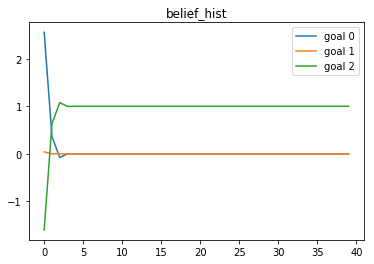

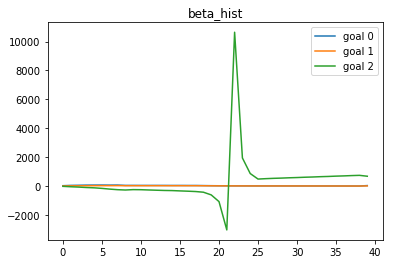

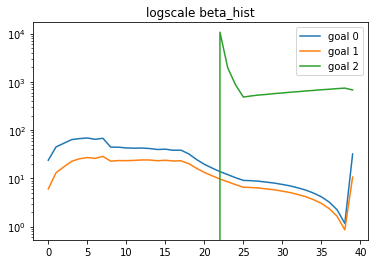

In [17]:
plot_inference(config, s_g_exp_trajs[0][0])

In [12]:
pour_red_paths = [parent_dir + '/../jaco_learning/data/pour_red{}.npy'.format(i) for i in range(5)]
pour_red_trajs = load_demonstrations(pour_red_paths)
noisypour_red_paths = [parent_dir + '/../jaco_learning/data/noisypour_red{}.npy'.format(i) for i in range(1)]
noisypour_red_trajs = load_demonstrations(noisypour_red_paths)
goto_green_paths = [parent_dir + '/../jaco_learning/data/goto_green{}.npy'.format(i) for i in range(5)]
goto_green_trajs = load_demonstrations(goto_green_paths)

made it to end of env initialization
feat_list: ['efficiency']
feat_list: ['efficiency', 'learned_feature']
feat_list: ['efficiency', 'learned_feature', 'learned_feature']


planned goal traj len 40
planned goal traj len 40
planned goal traj len 40
planned goal traj len 40
planned goal traj len 40
inference time: 15.0140180588
planned goal traj len 39
planned goal traj len 39
planned goal traj len 39
planned goal traj len 39
planned goal traj len 39
inference time: 15.1734359264
planned goal traj len 38
planned goal traj len 38
planned goal traj len 38
planned goal traj len 38
planned goal traj len 38
inference time: 15.8487200737
planned goal traj len 37
planned goal traj len 37
planned goal traj len 37
planned goal traj len 37
planned goal traj len 37
inference time: 15.1428349018
planned goal traj len 36
planned goal traj len 36
planned goal traj len 36
planned goal traj len 36
planned goal traj len 36
inference time: 16.3484530449
planned goal traj len 35
planned goal traj len 35
planned goal traj len 35
planned goal traj len 35
planned goal traj len 35
inference time: 14.6936979294
planned goal traj len 34
planned goal traj len 34
planned goal traj le

/root/catkin_ws/src/jaco_learning/src/notebooks/../learners/teleop_learner.py:122: RuntimeWarning:

overflow encountered in power

/root/catkin_ws/src/jaco_learning/src/notebooks/../learners/teleop_learner.py:124: RuntimeWarning:

invalid value encountered in divide



planned goal traj len 4
planned goal traj len 4
planned goal traj len 4
inference time: 5.99392485619
planned goal traj len 3
planned goal traj len 3
planned goal traj len 3
planned goal traj len 3
planned goal traj len 3
inference time: 6.63976216316
planned goal traj len 2
planned goal traj len 2
planned goal traj len 2
planned goal traj len 2
planned goal traj len 2
inference time: 6.6206741333
constraint_costs [1.27153286 3.78153346 0.11121999 0.11121999 7.88617441]
curr traj costs [1.21167388e+00 1.21167388e+00 4.89500676e+00 2.87540374e+02
 2.85420239e+04]
optimal_costs [4.59634862e-01 4.41604552e-01 3.61275770e+00 2.96503715e+02
 1.51412452e+04]
final suboptimality: [ 4.40256395 10.30696528  0.38570786 -0.02985501  0.88557214]
final suboptimality/time: [ 0.10737961  0.2513894   0.00940751 -0.00072817  0.02159932]
beta: [[ 2.63465676e+01  1.74084484e+01  2.54102500e+02  8.85809841e+00
   1.64577853e+01]
 [ 4.88898137e+01  3.44520551e+01  4.86742479e+02  2.01328402e+01
   3.108883

/root/catkin_ws/src/jaco_learning/src/notebooks/../learners/teleop_learner.py:165: RuntimeWarning:

overflow encountered in power

/root/catkin_ws/src/jaco_learning/src/notebooks/../learners/teleop_learner.py:167: RuntimeWarning:

invalid value encountered in divide



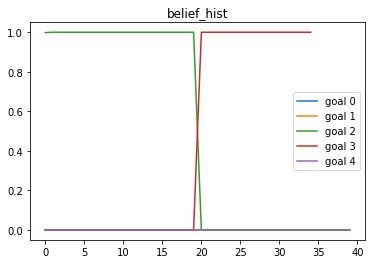

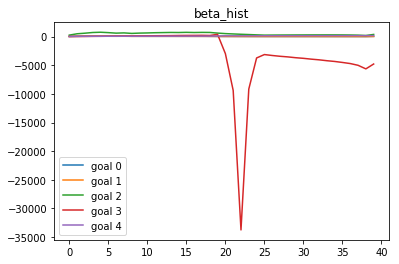

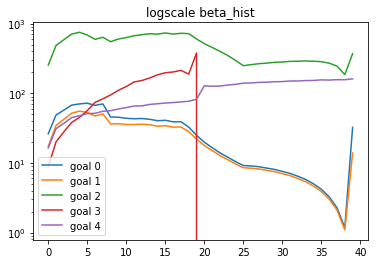

In [21]:
# using constrained planner
plot_inference(config, pour_red_trajs[0][0])

made it to end of env initialization
feat_list: ['efficiency']


planned goal traj len 40
planned goal traj len 40
planned goal traj len 40
inference time: 4.42884683609
planned goal traj len 39
planned goal traj len 39
planned goal traj len 39
inference time: 0.62243103981
planned goal traj len 38
planned goal traj len 38
planned goal traj len 38
inference time: 0.428488016129
planned goal traj len 37
planned goal traj len 37
planned goal traj len 37
inference time: 0.333238840103
planned goal traj len 36
planned goal traj len 36
planned goal traj len 36
inference time: 1.23601484299
planned goal traj len 35
planned goal traj len 35
planned goal traj len 35
inference time: 1.29289007187
planned goal traj len 34
planned goal traj len 34
planned goal traj len 34
inference time: 0.4711830616
planned goal traj len 33
planned goal traj len 33
planned goal traj len 33
inference time: 0.9193379879
planned goal traj len 32
planned goal traj len 32
planned goal traj len 32
inference time: 0.195171117783
planned goal traj len 31
planned goal traj len 31
plan

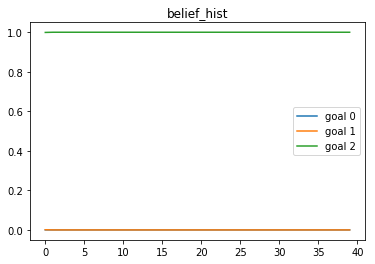

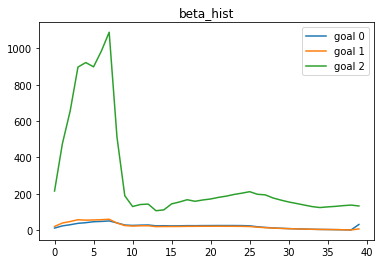

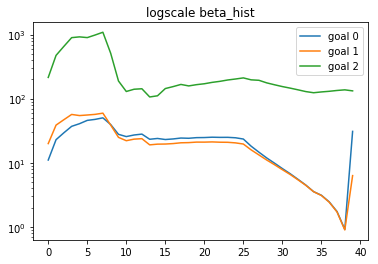

In [18]:
plot_inference(config, noisypour_red_trajs[0][0])

made it to end of env initialization
feat_list: ['efficiency']
feat_list: ['efficiency', 'learned_feature']
feat_list: ['efficiency', 'learned_feature', 'learned_feature']


planned goal traj len 40
planned goal traj len 40
planned goal traj len 40
planned goal traj len 40
planned goal traj len 40
inference time: 20.6301121712
planned goal traj len 39
planned goal traj len 39
planned goal traj len 39
planned goal traj len 39
planned goal traj len 39
inference time: 20.0533840656
planned goal traj len 38
planned goal traj len 38
planned goal traj len 38
planned goal traj len 38
planned goal traj len 38
inference time: 18.1926388741
planned goal traj len 37
planned goal traj len 37
planned goal traj len 37
planned goal traj len 37
planned goal traj len 37
inference time: 24.7014858723
planned goal traj len 36
planned goal traj len 36
planned goal traj len 36
planned goal traj len 36
planned goal traj len 36
inference time: 16.2352700233
planned goal traj len 35
planned goal traj len 35
planned goal traj len 35
planned goal traj len 35
planned goal traj len 35
inference time: 14.1676700115
planned goal traj len 34
planned goal traj len 34
planned goal traj le

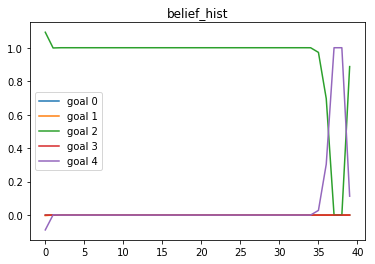

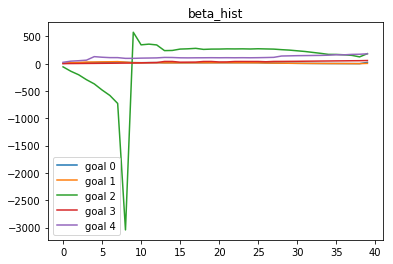

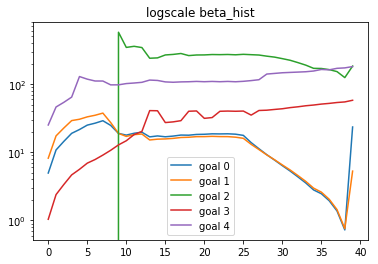

In [22]:
# using constrained planner
plot_inference(config, noisypour_red_trajs[0][0])

made it to end of env initialization
feat_list: ['efficiency']


planned goal traj len 40
planned goal traj len 40
planned goal traj len 40
inference time: 7.06382012367
planned goal traj len 39
planned goal traj len 39
planned goal traj len 39
inference time: 0.895714998245
planned goal traj len 38
planned goal traj len 38
planned goal traj len 38
inference time: 1.35327601433
planned goal traj len 37
planned goal traj len 37
planned goal traj len 37
inference time: 1.0271999836
planned goal traj len 36
planned goal traj len 36
planned goal traj len 36
inference time: 0.781668901443
planned goal traj len 35
planned goal traj len 35
planned goal traj len 35
inference time: 8.97856688499
planned goal traj len 34
planned goal traj len 34
planned goal traj len 34
inference time: 6.41762208939
planned goal traj len 33
planned goal traj len 33
planned goal traj len 33
inference time: 7.22323489189
planned goal traj len 32
planned goal traj len 32
planned goal traj len 32
inference time: 5.66445994377
planned goal traj len 31
planned goal traj len 31
plan

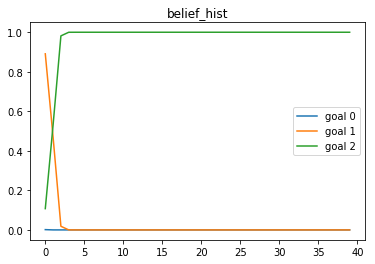

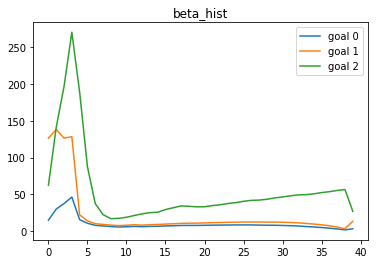

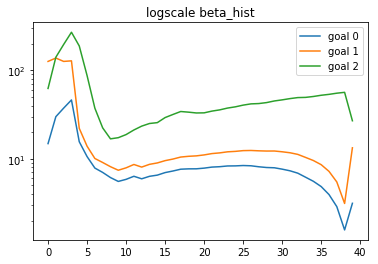

In [23]:
plot_inference(config, goto_green_trajs[0][0])

made it to end of env initialization
feat_list: ['efficiency']
feat_list: ['efficiency', 'learned_feature']
feat_list: ['efficiency', 'learned_feature', 'learned_feature']


planned goal traj len 40
planned goal traj len 40
planned goal traj len 40
planned goal traj len 40
planned goal traj len 40
inference time: 26.8636238575
planned goal traj len 39
planned goal traj len 39
planned goal traj len 39
planned goal traj len 39
planned goal traj len 39
inference time: 26.1795320511
planned goal traj len 38
planned goal traj len 38
planned goal traj len 38
planned goal traj len 38
planned goal traj len 38
inference time: 23.8635988235
planned goal traj len 37
planned goal traj len 37
planned goal traj len 37
planned goal traj len 37
planned goal traj len 37
inference time: 24.0237181187
planned goal traj len 36
planned goal traj len 36
planned goal traj len 36
planned goal traj len 36
planned goal traj len 36
inference time: 23.2228660583
planned goal traj len 35
planned goal traj len 35
planned goal traj len 35
planned goal traj len 35
planned goal traj len 35
inference time: 15.2503340244
planned goal traj len 34
planned goal traj len 34
planned goal traj le

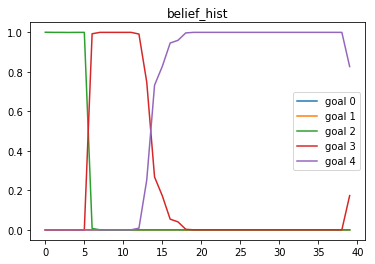

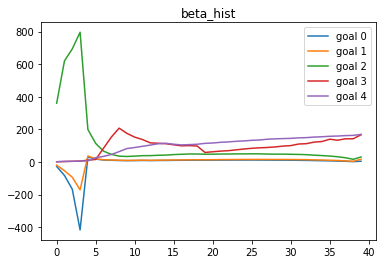

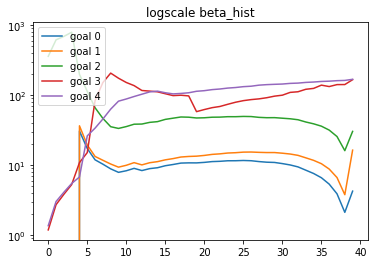

In [23]:
# using constrained planner
plot_inference(config, goto_green_trajs[0][0])

# IRL

In [13]:
def irl(config, NN_dict, IRL_dict, s_g_exp_trajs):
    main = setup_inference(config.copy())
    common_weights = main.common_weights + [0]
    for i in range(len(main.goal_weights)):
        main.goal_weights[i] = np.hstack((main.goal_weights[i], 0))
    learned_goal_weight = np.array(common_weights)
    learned_goal_weight[len(main.feat_list)] = 1.
    main.goal_weights.append(learned_goal_weight)
    
    main.environment.new_meirl_learned_feature(
        main.planner,
        learned_goal_weight,
        s_g_exp_trajs,
        None,
        [],
        NN_dict,
        'waypt',
        name='_new'
    )
    meirl = main.environment.learned_feats[-1]
    meirl.deep_max_ent_irl(n_iters=IRL_dict['n_iters'],
                           n_cur_rew_traj=IRL_dict['n_cur_rew_traj'],
                           lr=IRL_dict['lr'],
                           weight_decay=IRL_dict['weight_decay'],
                           std=IRL_dict['std'])
    return main, meirl

In [14]:
NN_dict = {'n_layers': 2, 'n_units':128,
           'sin':False, 'cos':False, 'noangles':True, 'norot':False,
           'rpy':False, 'lowdim':True, 'noxyz':True, 'EErot':True,
           '6D_laptop':False, '6D_human':False, '9D_coffee':False}

IRL_dict = {'n_iters': 50,
            'n_cur_rew_traj': 1,
            'lr':1e-3, 'weight_decay':0.001, 'std':0.01}

## Without using seeds:

In [16]:
config['planner']['prefer_angles']

False

In [17]:
main, meirl = irl(config, NN_dict, IRL_dict, goto_green_trajs)

made it to end of env initialization
feat_list: ['efficiency']
feat_list: ['efficiency', 'learned_feature']
feat_list: ['efficiency', 'learned_feature', 'learned_feature']
Planning with features: ['efficiency']


planning took: 0.402348995209
Planning with features: ['efficiency']
planning took: 0.486915111542
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.40141487122
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.20152115822
Planning with features: ['efficiency' 'learned_feature']


Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

planning took: 1.75095105171
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.078075170517
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.177561044693
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.122407197952
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 1:   2%|▏         | 1/50 [00:00<00:33,  1.48it/s, avg_loss=-2.44]

planning took: 0.0977458953857
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.134823083878
iteration 0 time: 0.673599004745
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.137481927872
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.179841041565
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.290505886078
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.117820978165
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 2:   4%|▍         | 2/50 [00:01<00:37,  1.29it/s, avg_loss=-13.7]

planning took: 0.217527866364
iteration 1 time: 1.00637602806
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.189610004425
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.394600868225
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.179222106934
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 2:   6%|▌         | 3/50 [00:02<00:42,  1.11it/s, avg_loss=-26.1]

planning took: 0.195407867432
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.164942979813
iteration 2 time: 1.19459891319


Iteration 3:   6%|▌         | 3/50 [00:02<00:42,  1.11it/s, avg_loss=-26.1]

Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.41782784462
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.500367879868
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.395155906677
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.425230979919
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 4:   8%|▊         | 4/50 [00:04<00:58,  1.26s/it, avg_loss=-39.6]

planning took: 0.276721954346
iteration 3 time: 2.09227609634
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.509413957596
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.440352916718
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.405336141586
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.566931962967
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 5:  10%|█         | 5/50 [00:07<01:12,  1.61s/it, avg_loss=-54.6]

planning took: 0.438518047333
iteration 4 time: 2.43146085739
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.654746055603
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.515923023224
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.159067153931
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.210773944855
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 6:  12%|█▏        | 6/50 [00:09<01:17,  1.76s/it, avg_loss=-73.3]

planning took: 0.496322870255
iteration 5 time: 2.09091114998
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.215717077255
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.831785917282
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.540395975113
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.488234996796
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 7:  14%|█▍        | 7/50 [00:12<01:26,  2.01s/it, avg_loss=-90.1]

planning took: 0.444890022278
iteration 6 time: 2.57583785057
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.22123408318
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.718436956406
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.471255064011
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.791823148727
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 8:  16%|█▌        | 8/50 [00:16<01:53,  2.70s/it, avg_loss=-109] 

planning took: 1.0476770401
iteration 7 time: 4.30300307274
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.01468992233
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.746433973312
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.748514890671
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.988209962845
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 9:  18%|█▊        | 9/50 [00:22<02:33,  3.74s/it, avg_loss=-134]

planning took: 1.63397908211
iteration 8 time: 6.19199585915
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.43848991394
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.880309104919
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.102386951447
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.24139285088
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 10:  20%|██        | 10/50 [00:27<02:48,  4.21s/it, avg_loss=-161]

planning took: 1.57650589943
iteration 9 time: 5.29472994804
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.38136601448
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.46412491798
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.00581717491
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.2230219841
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 11:  22%|██▏       | 11/50 [00:36<03:33,  5.48s/it, avg_loss=-187]

planning took: 1.31399202347
iteration 10 time: 8.45289897919
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.28398084641
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.15862298012
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.37555098534
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.18163013458
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 12:  24%|██▍       | 12/50 [00:44<03:54,  6.17s/it, avg_loss=-169]

planning took: 1.71976900101
iteration 11 time: 7.78035306931
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.68982505798
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.09151506424
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.95968198776
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.94689106941
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 13:  26%|██▌       | 13/50 [00:54<04:39,  7.56s/it, avg_loss=-204]

planning took: 2.02156400681
iteration 12 time: 10.8011758327
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.74645709991
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.21995306015
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.29090380669
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.63129901886
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 14:  28%|██▊       | 14/50 [01:03<04:48,  8.01s/it, avg_loss=-243]

planning took: 2.08488202095
iteration 13 time: 9.04155492783
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.92217206955
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.80235219002
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.35611319542
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.62313294411
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 15:  30%|███       | 15/50 [01:11<04:40,  8.00s/it, avg_loss=-243]

planning took: 1.21499204636
iteration 14 time: 7.98152208328
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.95597910881
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.64289021492
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.43393683434
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.47331809998
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 16:  32%|███▏      | 16/50 [01:20<04:37,  8.17s/it, avg_loss=-291]

planning took: 1.9929330349
iteration 15 time: 8.55507683754
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.49583411217
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.60123801231
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.25940799713
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.29795789719
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 17:  34%|███▍      | 17/50 [01:27<04:19,  7.86s/it, avg_loss=-337]

planning took: 1.43389010429
iteration 16 time: 7.14269709587
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.34222602844
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.48824691772
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.32904291153
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.85918307304
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 18:  36%|███▌      | 18/50 [01:35<04:12,  7.88s/it, avg_loss=-390]

planning took: 1.84647297859
iteration 17 time: 7.91932916641
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.49419593811
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.24951910973
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.77418494225
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.22898697853
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 19:  38%|███▊      | 19/50 [01:43<04:04,  7.88s/it, avg_loss=-453]

planning took: 2.06714987755
iteration 18 time: 7.8707690239
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.45680689812
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.59203100204
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.27597904205
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.47821688652
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 20:  40%|████      | 20/50 [01:50<03:51,  7.70s/it, avg_loss=-520]

planning took: 1.43265104294
iteration 19 time: 7.28927898407
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.20970582962
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.02634310722
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.54187607765
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.90297794342
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 21:  42%|████▏     | 21/50 [01:57<03:37,  7.51s/it, avg_loss=-597]

planning took: 1.29619598389
iteration 20 time: 7.03346300125
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.35764503479
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.50410294533
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.29571986198
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.84599113464
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 22:  44%|████▍     | 22/50 [02:05<03:28,  7.46s/it, avg_loss=-689]

planning took: 1.28734397888
iteration 21 time: 7.3501958847
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.49619698524
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.3474111557
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.47570896149
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.49925112724
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 23:  46%|████▌     | 23/50 [02:12<03:21,  7.47s/it, avg_loss=-796]

planning took: 1.59471988678
iteration 22 time: 7.47129201889
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.70230484009
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.23254513741
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.4778110981
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.61655092239
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 24:  48%|████▊     | 24/50 [02:19<03:10,  7.33s/it, avg_loss=-867]

planning took: 0.912042140961
iteration 23 time: 6.9954829216
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.41711401939
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.34615302086
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.25296211243
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.16394996643
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 25:  50%|█████     | 25/50 [02:27<03:06,  7.46s/it, avg_loss=-1e+3]

planning took: 1.53157114983
iteration 24 time: 7.7655851841
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.67786979675
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.46818995476
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.26357197762
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.04610800743
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 26:  52%|█████▏    | 26/50 [02:38<03:21,  8.41s/it, avg_loss=-1.14e+3]

planning took: 3.09548282623
iteration 25 time: 10.6155769825
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.81523990631
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.82166409492
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.93067717552
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.66301083565
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 27:  54%|█████▍    | 27/50 [02:47<03:23,  8.86s/it, avg_loss=-1.64e+3]

planning took: 1.61740493774
iteration 26 time: 9.90960407257
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.44857001305
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.35601997375
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.2852730751
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.39011883736
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 28:  56%|█████▌    | 28/50 [03:01<03:47, 10.34s/it, avg_loss=-1.5e+3] 

planning took: 3.22059702873
iteration 27 time: 13.7990019321
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.6052801609
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.23205113411
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.23905992508
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.82427787781
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 29:  58%|█████▊    | 29/50 [03:16<04:06, 11.72s/it, avg_loss=-1.65e+3]

planning took: 2.94805908203
iteration 28 time: 14.923842907
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.17468810081
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.36814284325
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.94048690796
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.43499684334
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 30:  60%|██████    | 30/50 [03:28<03:56, 11.82s/it, avg_loss=-1.68e+3]

planning took: 3.05302286148
iteration 29 time: 12.0504519939
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.94164013863
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.33282399178
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.94106483459
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.92882204056
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 31:  62%|██████▏   | 31/50 [03:40<03:42, 11.72s/it, avg_loss=-2.48e+3]

planning took: 2.24349713326
iteration 30 time: 11.475894928
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.29618406296
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.96346688271
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.5351099968
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.81490087509
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 32:  64%|██████▍   | 32/50 [03:50<03:21, 11.22s/it, avg_loss=-2.79e+3]

planning took: 1.39490604401
iteration 31 time: 10.0632500648
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.43485212326
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.5784239769
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.18643212318
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.12037205696
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 33:  66%|██████▌   | 33/50 [03:58<02:53, 10.18s/it, avg_loss=-3.11e+3]

planning took: 1.36458778381
iteration 32 time: 7.7394490242
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.71597099304
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.29841589928
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.68513417244
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.22294998169
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 34:  68%|██████▊   | 34/50 [04:06<02:33,  9.60s/it, avg_loss=-3.47e+3]

planning took: 1.26526403427
iteration 33 time: 8.25126099586
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.78398299217
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.21381115913
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.60412192345
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.11291408539
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 35:  70%|███████   | 35/50 [04:14<02:19,  9.33s/it, avg_loss=-3.83e+3]

planning took: 1.91487717628
iteration 34 time: 8.68401288986
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.77791595459
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.28758096695
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.621945858
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.25094890594
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 36:  72%|███████▏  | 36/50 [04:24<02:10,  9.29s/it, avg_loss=-3.45e+3]

planning took: 2.20281791687
iteration 35 time: 9.20948815346
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.7679169178
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.27514719963
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.56125211716
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.1231238842
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 37:  74%|███████▍  | 37/50 [04:33<01:59,  9.16s/it, avg_loss=-4.66e+3]

planning took: 2.06321406364
iteration 36 time: 8.84611797333
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.79769492149
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.29879689217
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.67009711266
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.31149482727
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 38:  76%|███████▌  | 38/50 [04:42<01:51,  9.28s/it, avg_loss=-5.08e+3]

planning took: 2.41399002075
iteration 37 time: 9.56029200554
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.77815890312
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.89554405212
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.83108997345
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.12470412254
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 39:  78%|███████▊  | 39/50 [04:55<01:53, 10.30s/it, avg_loss=-5.57e+3]

planning took: 2.95041489601
iteration 38 time: 12.6629121304
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.97319507599
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.72982096672
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.8706138134
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.33855390549
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 40:  80%|████████  | 40/50 [05:06<01:45, 10.52s/it, avg_loss=-4.93e+3]

planning took: 2.06364893913
iteration 39 time: 11.0436370373
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.34017705917
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.00445795059
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.78628206253
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.31041407585
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 41:  82%|████████▏ | 41/50 [05:17<01:37, 10.78s/it, avg_loss=-5.4e+3] 

planning took: 1.8743751049
iteration 40 time: 11.3893399239
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.13226413727
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.9026119709
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.2545208931
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.45287394524
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 42:  84%|████████▍ | 42/50 [05:29<01:28, 11.06s/it, avg_loss=-5.87e+3]

planning took: 1.86711120605
iteration 41 time: 11.6905338764
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.02937698364
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.21519994736
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.78096604347
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.61127901077
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 43:  86%|████████▌ | 43/50 [05:41<01:20, 11.52s/it, avg_loss=-6.38e+3]

planning took: 1.88070893288
iteration 42 time: 12.6004829407
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.26444292068
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.88105487823
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.70187401772
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.50012183189
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 44:  88%|████████▊ | 44/50 [05:54<01:11, 11.86s/it, avg_loss=-6.79e+3]

planning took: 3.24983596802
iteration 43 time: 12.6646060944
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.37563610077
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.6114859581
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.68545007706
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.98544692993
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 45:  90%|█████████ | 45/50 [06:06<00:58, 11.78s/it, avg_loss=-7.14e+3]

planning took: 2.84173107147
iteration 44 time: 11.589165926
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.78785300255
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.34860301018
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.37763500214
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.98712706566
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 46:  92%|█████████▏| 46/50 [06:22<00:52, 13.06s/it, avg_loss=-7.57e+3]

planning took: 3.44635081291
iteration 45 time: 16.0362279415
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.57293105125
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.11630892754
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.59620809555
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.49291706085
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 47:  94%|█████████▍| 47/50 [06:35<00:39, 13.06s/it, avg_loss=-7.86e+3]

planning took: 3.21329021454
iteration 46 time: 13.0631079674
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.36270809174
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.31542611122
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.26334500313
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.00329399109
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 48:  96%|█████████▌| 48/50 [06:48<00:26, 13.03s/it, avg_loss=-8.15e+3]

planning took: 2.91566705704
iteration 47 time: 12.9403939247
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.04407596588
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.88072299957
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.74193191528
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.54523587227
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49:  98%|█████████▊| 49/50 [06:59<00:12, 12.38s/it, avg_loss=-8.81e+3]

planning took: 0.600625991821
iteration 48 time: 10.8801169395
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.85677814484
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.96084117889
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.92576599121
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 4.97285914421
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49: 100%|██████████| 50/50 [07:15<00:00,  8.71s/it, avg_loss=-9.5e+3] 

planning took: 3.29292011261
iteration 49 time: 16.0746459961


In [18]:
config['planner']['prefer_angles'] = True

In [19]:
main, meirl = irl(config, NN_dict, IRL_dict, goto_green_trajs)

made it to end of env initialization
feat_list: ['efficiency']
feat_list: ['efficiency', 'learned_feature']
feat_list: ['efficiency', 'learned_feature', 'learned_feature']
Planning with features: ['efficiency']
planning took: 0.0121750831604
Planning with features: ['efficiency']
planning took: 0.0196659564972
Planning with features: ['efficiency' 'learned_feature']


planning took: 0.133368015289
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.15027689934
Planning with features: ['efficiency' 'learned_feature']


Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

planning took: 0.872098922729
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.113708972931
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.168987035751
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.116965055466
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s, avg_loss=-2.17]

planning took: 0.206327915192
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.139923095703


Iteration 1:   2%|▏         | 1/50 [00:00<00:43,  1.14it/s, avg_loss=-2.17]

iteration 0 time: 0.878935098648
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.174412965775
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.166233778
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.101233005524
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.111494064331
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.151726961136


Iteration 2:   4%|▍         | 2/50 [00:01<00:41,  1.17it/s, avg_loss=-12.6]

iteration 1 time: 0.793839931488
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.251554012299
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.184278964996
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.197202920914
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.229477882385
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.16663312912


Iteration 3:   6%|▌         | 3/50 [00:02<00:43,  1.07it/s, avg_loss=-23.5]

iteration 2 time: 1.11105298996
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.552160978317
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.39955496788
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.324443817139
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.339910984039
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 4:   8%|▊         | 4/50 [00:04<00:56,  1.23s/it, avg_loss=-34.8]

planning took: 0.252314090729
iteration 3 time: 1.93728399277
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.3884370327
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.405417919159
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.423553943634
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.302659988403
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 5:  10%|█         | 5/50 [00:06<01:07,  1.49s/it, avg_loss=-49.7]

planning took: 0.482356071472
iteration 4 time: 2.0830180645
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.746439933777
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.395623922348
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.530563116074
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.487350940704
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 6:  12%|█▏        | 6/50 [00:09<01:26,  1.97s/it, avg_loss=-64.6]

planning took: 0.820192098618
iteration 5 time: 3.07483482361
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.789361000061
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.855343103409
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.578392028809
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.115883111954
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 7:  14%|█▍        | 7/50 [00:13<01:40,  2.34s/it, avg_loss=-84.6]

planning took: 0.806818962097
iteration 6 time: 3.21834087372
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.679215192795
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.910080909729
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.667438030243
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.559048891068
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 8:  16%|█▌        | 8/50 [00:16<01:56,  2.77s/it, avg_loss=-101] 

planning took: 0.835371017456
iteration 7 time: 3.75192379951
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.1936788559
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.77576589584
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.958463907242
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.841080188751
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 9:  18%|█▊        | 9/50 [00:24<02:48,  4.10s/it, avg_loss=-127]

planning took: 1.3731470108
iteration 8 time: 7.21766281128
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.04043698311
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.72663998604
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.74770092964
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.2570810318
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 10:  20%|██        | 10/50 [00:33<03:43,  5.60s/it, avg_loss=-136]

planning took: 1.22873783112
iteration 9 time: 9.07643985748
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.81766414642
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.07438802719
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.83543086052
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.99096679688
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 11:  22%|██▏       | 11/50 [00:43<04:32,  6.99s/it, avg_loss=-164]

planning took: 1.4444129467
iteration 10 time: 10.2301959991
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.53107213974
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.32000899315
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.84755396843
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.5613861084
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 12:  24%|██▍       | 12/50 [00:53<05:03,  8.00s/it, avg_loss=-204]

planning took: 1.04126191139
iteration 11 time: 10.3621439934
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.02208995819
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.6743490696
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.39621710777
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.44365596771
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 13:  26%|██▌       | 13/50 [01:06<05:52,  9.52s/it, avg_loss=-245]

planning took: 1.42935299873
iteration 12 time: 13.0516960621
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.3587667942
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.41814804077
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.86199808121
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.53182005882
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 14:  28%|██▊       | 14/50 [01:23<06:59, 11.65s/it, avg_loss=-316]

planning took: 3.352257967
iteration 13 time: 16.6284170151
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.66105914116
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.71766090393
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.11407494545
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.14361310005
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 15:  30%|███       | 15/50 [01:38<07:24, 12.71s/it, avg_loss=-327]

planning took: 3.43099999428
iteration 14 time: 15.1783220768
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.52241897583
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.00600790977
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.14122390747
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.04998207092
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 16:  32%|███▏      | 16/50 [01:52<07:22, 13.00s/it, avg_loss=-354]

planning took: 1.85796308517
iteration 15 time: 13.6811928749
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.55069303513
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.60939502716
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.61614704132
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.16155600548
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 17:  34%|███▍      | 17/50 [02:05<07:07, 12.95s/it, avg_loss=-423]

planning took: 1.83106708527
iteration 16 time: 12.8323090076
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.35108804703
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.26162004471
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.30252599716
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.86926007271
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 18:  36%|███▌      | 18/50 [02:18<06:58, 13.07s/it, avg_loss=-493]

planning took: 2.44483804703
iteration 17 time: 13.3532400131
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.93201589584
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.52671694756
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.06349611282
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.14501094818
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 19:  38%|███▊      | 19/50 [02:31<06:45, 13.09s/it, avg_loss=-581]

planning took: 2.37398982048
iteration 18 time: 13.1313889027
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.73113489151
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.38871598244
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.39442110062
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.18294501305
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 20:  40%|████      | 20/50 [02:43<06:25, 12.84s/it, avg_loss=-595]

planning took: 2.48002314568
iteration 19 time: 12.2597939968
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.24496006966
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.78331899643
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.4324889183
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.68420505524
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 21:  42%|████▏     | 21/50 [02:55<06:05, 12.60s/it, avg_loss=-441]

planning took: 1.78819298744
iteration 20 time: 12.0406301022
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.36492705345
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.52012205124
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.65184688568
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.31442809105
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 22:  44%|████▍     | 22/50 [03:06<05:36, 12.03s/it, avg_loss=-737]

planning took: 1.78067207336
iteration 21 time: 10.7036991119
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.87381505966
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.5459280014
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.5544500351
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.13395500183
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 23:  46%|████▌     | 23/50 [03:19<05:32, 12.30s/it, avg_loss=-565]

planning took: 2.71662211418
iteration 22 time: 12.9084990025
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.68773007393
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.53634214401
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.29888105392
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.33943104744
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 24:  48%|████▊     | 24/50 [03:32<05:21, 12.37s/it, avg_loss=-624]

planning took: 2.58046293259
iteration 23 time: 12.5218939781
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.65270400047
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.89401912689
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.41913580894
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.27234387398
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 25:  50%|█████     | 25/50 [03:44<05:12, 12.50s/it, avg_loss=-899]

planning took: 2.46858406067
iteration 24 time: 12.7999401093
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.23411798477
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.56524896622
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.09487509727
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.52927994728
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 26:  52%|█████▏    | 26/50 [03:58<05:10, 12.94s/it, avg_loss=-789]

planning took: 3.48587107658
iteration 25 time: 13.9815528393
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.8071038723
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.01485919952
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.30104088783
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.97466778755
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 27:  54%|█████▍    | 27/50 [04:11<04:58, 12.96s/it, avg_loss=-1.11e+3]

planning took: 2.83258295059
iteration 26 time: 13.0003039837
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.87893795967
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.7336730957
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.30832695961
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.56999802589
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 28:  56%|█████▌    | 28/50 [04:24<04:41, 12.79s/it, avg_loss=-1.25e+3]

planning took: 1.81359791756
iteration 27 time: 12.403676033
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.97123408318
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.16570305824
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.35240292549
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.06373310089
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 29:  58%|█████▊    | 29/50 [04:37<04:28, 12.80s/it, avg_loss=-1.38e+3]

planning took: 2.19716787338
iteration 28 time: 12.8234088421
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.57645487785
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.4368391037
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.18729400635
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.31372284889
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 30:  60%|██████    | 30/50 [04:50<04:17, 12.89s/it, avg_loss=-1.17e+3]

planning took: 3.49466204643
iteration 29 time: 13.0727341175
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.32118797302
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.44016480446
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.69701194763
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.39572882652
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 31:  62%|██████▏   | 31/50 [05:03<04:07, 13.05s/it, avg_loss=-1.65e+3]

planning took: 3.48793506622
iteration 30 time: 13.4234879017
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.73550677299
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.13935899734
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.81239104271
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.41022586823
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 32:  64%|██████▍   | 32/50 [05:14<03:43, 12.43s/it, avg_loss=-2.21e+3]

planning took: 1.78822612762
iteration 31 time: 10.9696319103
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.69507002831
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.33482599258
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.81314182281
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.58419704437
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 33:  66%|██████▌   | 33/50 [05:27<03:34, 12.62s/it, avg_loss=-2.51e+3]

planning took: 2.57371807098
iteration 32 time: 13.0616600513
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.88982510567
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.48805522919
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.02937889099
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.42355799675
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 34:  68%|██████▊   | 34/50 [05:40<03:25, 12.82s/it, avg_loss=-2.81e+3]

planning took: 2.38584089279
iteration 33 time: 13.2855329514
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.89444303513
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.10793113708
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.74601602554
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.54553103447
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 35:  70%|███████   | 35/50 [05:54<03:17, 13.15s/it, avg_loss=-3.17e+3]

planning took: 2.52226018906
iteration 34 time: 13.9098370075
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.01477718353
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.44335389137
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.2667901516
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.3225941658
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 36:  72%|███████▏  | 36/50 [06:08<03:06, 13.29s/it, avg_loss=-3.55e+3]

planning took: 2.50309300423
iteration 35 time: 13.6294989586
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.19237709045
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.6234459877
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.01950502396
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.49089503288
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 37:  74%|███████▍  | 37/50 [06:20<02:49, 13.05s/it, avg_loss=-3.85e+3]

planning took: 2.03796315193
iteration 36 time: 12.4689509869
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.74878001213
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.36029219627
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.981580019
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.91261911392
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 38:  76%|███████▌  | 38/50 [06:34<02:38, 13.20s/it, avg_loss=-4.21e+3]

planning took: 3.46346688271
iteration 37 time: 13.5525660515
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.98244285583
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.33424401283
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.90730690956
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.13308596611
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 39:  78%|███████▊  | 39/50 [06:44<02:14, 12.24s/it, avg_loss=-3.7e+3] 

planning took: 0.562065124512
iteration 38 time: 10.0014770031
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.30818200111
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.99983811378
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.88551807404
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 4.05482888222
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 40:  80%|████████  | 40/50 [06:58<02:08, 12.86s/it, avg_loss=-4.21e+3]

planning took: 1.98284983635
iteration 39 time: 14.3050479889
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.14877200127
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.87861800194
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.94006800652
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.28856086731
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 41:  82%|████████▏ | 41/50 [07:12<01:58, 13.12s/it, avg_loss=-4.52e+3]

planning took: 3.35153198242
iteration 40 time: 13.7162649632
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.50228309631
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.73629903793
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.52789998055
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.07017493248
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 42:  84%|████████▍ | 42/50 [07:25<01:44, 13.00s/it, avg_loss=-5.95e+3]

planning took: 2.80804800987
iteration 41 time: 12.7285728455
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.68793106079
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.85205698013
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.75637698174
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 10.8314380646
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 43:  86%|████████▌ | 43/50 [07:57<02:11, 18.79s/it, avg_loss=-5.27e+3]

planning took: 15.0211730003
iteration 42 time: 32.2919929028
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 9.70550918579
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 5.90448904037
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 5.83561396599
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 9.69197893143
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 44:  88%|████████▊ | 44/50 [08:36<02:29, 24.91s/it, avg_loss=-6.89e+3]

planning took: 7.83642697334
iteration 43 time: 39.1793282032
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 7.96701288223
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 6.0794608593
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 6.27477693558
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 9.97148394585
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 45:  90%|█████████ | 45/50 [09:16<02:26, 29.40s/it, avg_loss=-5.99e+3]

planning took: 9.32582712173
iteration 44 time: 39.8603279591
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 10.3529589176
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 6.79298377037
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 6.63466405869
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 10.8091847897
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 46:  92%|█████████▏| 46/50 [09:54<02:07, 31.88s/it, avg_loss=-6.5e+3] 

planning took: 2.85471510887
iteration 45 time: 37.681812048
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 9.87926101685
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 6.75051403046
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 6.82328391075
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 11.4177949429
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 47:  94%|█████████▍| 47/50 [10:37<01:45, 35.27s/it, avg_loss=-6.92e+3]

planning took: 8.00591492653
iteration 46 time: 43.1706771851
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 6.15174412727
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 6.81592011452
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 4.88405013084
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 9.38956999779
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 48:  96%|█████████▌| 48/50 [11:16<01:12, 36.28s/it, avg_loss=-9.16e+3]

planning took: 11.1332149506
iteration 47 time: 38.6118490696
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 6.5687520504
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 8.09143304825
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.04339694977
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.25125694275
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49:  98%|█████████▊| 49/50 [11:39<00:32, 32.41s/it, avg_loss=-9.59e+3]

planning took: 3.32835888863
iteration 48 time: 23.3873500824
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.98408412933
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.84960484505
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.80830001831
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.86729001999
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49: 100%|██████████| 50/50 [11:52<00:00, 14.24s/it, avg_loss=-1.03e+4]

planning took: 3.95770812035
iteration 49 time: 12.5673389435


## With seeds:

In [15]:
config['planner']['prefer_angles']

False

In [16]:
main, meirl = irl(config, NN_dict, IRL_dict, goto_green_trajs)

made it to end of env initialization
feat_list: ['efficiency']
feat_list: ['efficiency', 'learned_feature']
feat_list: ['efficiency', 'learned_feature', 'learned_feature']
Planning with features: ['efficiency']


planning took: 0.399312973022
Planning with features: ['efficiency']
planning took: 0.30061006546
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.311814785
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.12142181396
Planning with features: ['efficiency' 'learned_feature']


Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

planning took: 1.83442020416
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0851888656616
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.103131055832
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0913009643555
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0691411495209
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 1:   2%|▏         | 1/50 [00:00<00:25,  1.94it/s, avg_loss=-3.52]

planning took: 0.0834429264069
iteration 0 time: 0.514158010483
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.199518918991
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.11353802681
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.20099902153
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.139486074448
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 2:   4%|▍         | 2/50 [00:01<00:30,  1.58it/s, avg_loss=-11.7]

planning took: 0.188565969467
iteration 1 time: 0.908598899841
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.215006113052
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.1940741539
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.331102132797
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.183614969254
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 3:   6%|▌         | 3/50 [00:02<00:38,  1.22it/s, avg_loss=-20.5]

planning took: 0.217926979065
iteration 2 time: 1.24117612839
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.194089889526
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.290606021881
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.408473014832
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.301976919174
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.177884101868


Iteration 4:   8%|▊         | 4/50 [00:04<00:46,  1.01s/it, avg_loss=-30]  

iteration 3 time: 1.46007800102
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.224678993225
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.190803050995
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.367645025253
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.122099161148
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 5:  10%|█         | 5/50 [00:05<00:47,  1.06s/it, avg_loss=-41.6]

planning took: 0.203634023666
iteration 4 time: 1.17202711105
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0991079807281
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.375837802887
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.365289926529
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.373368024826
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 6:  12%|█▏        | 6/50 [00:06<00:54,  1.24s/it, avg_loss=-53.3]

planning took: 0.366364955902
iteration 5 time: 1.64503598213
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.345123052597
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.786236047745
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.462388038635
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.653642177582
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 7:  14%|█▍        | 7/50 [00:09<01:12,  1.70s/it, avg_loss=-64.4]

planning took: 0.423774003983
iteration 6 time: 2.76602005959
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.946067094803
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.362608909607
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.441097021103
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.427816867828
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 8:  16%|█▌        | 8/50 [00:12<01:22,  1.96s/it, avg_loss=-78.4]

planning took: 0.314085960388
iteration 7 time: 2.56843113899
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.613578796387
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0658900737762
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.881241083145
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.540045976639
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 9:  18%|█▊        | 9/50 [00:15<01:33,  2.28s/it, avg_loss=-87]  

planning took: 0.830938100815
iteration 8 time: 3.01211595535
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.96485280991
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0557949542999
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.434998989105
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 10:  20%|██        | 10/50 [00:18<01:46,  2.66s/it, avg_loss=-106]

planning took: 0.979688882828
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0623049736023
iteration 9 time: 3.56635212898
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.565217018127
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.86137008667
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.432637929916
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 11:  22%|██▏       | 11/50 [00:22<01:54,  2.93s/it, avg_loss=-125]

planning took: 1.55858302116
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0664892196655
iteration 10 time: 3.56335687637
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.46790194511
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.382982969284
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.711402177811
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.350294828415
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 12:  24%|██▍       | 12/50 [00:26<02:08,  3.37s/it, avg_loss=-145]

planning took: 1.38907289505
iteration 11 time: 4.3902900219
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.9814248085
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.3903901577
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.710033893585
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.84046196938
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 13:  26%|██▌       | 13/50 [00:32<02:30,  4.07s/it, avg_loss=-178]

planning took: 0.70338511467
iteration 12 time: 5.70222091675
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.82490301132
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.172853946686
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.532278060913
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.16878986359
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 14:  28%|██▊       | 14/50 [00:37<02:39,  4.44s/it, avg_loss=-223]

planning took: 0.531203985214
iteration 13 time: 5.29836297035
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.95120120049
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.147073030472
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.371938943863
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.96491885185
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 15:  30%|███       | 15/50 [00:42<02:40,  4.57s/it, avg_loss=-274]

planning took: 0.384814023972
iteration 14 time: 4.87902498245
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.18890619278
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0688509941101
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0694088935852
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 16:  32%|███▏      | 16/50 [00:46<02:24,  4.25s/it, avg_loss=-326]

planning took: 1.03983902931
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0692451000214
iteration 15 time: 3.4886841774
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.136701107025
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0876340866089
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.296016931534
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 17:  34%|███▍      | 17/50 [00:47<01:49,  3.32s/it, avg_loss=-391]

planning took: 0.516541957855
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0669560432434
iteration 16 time: 1.16500210762
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0746738910675
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.393023014069
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.218100070953
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.130414962769
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 18:  36%|███▌      | 18/50 [00:48<01:25,  2.66s/it, avg_loss=-460]

planning took: 0.251913070679
iteration 17 time: 1.12533903122
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.381378173828
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.206915140152
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.145936965942
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 19:  38%|███▊      | 19/50 [00:49<01:10,  2.27s/it, avg_loss=-546]

planning took: 0.419401884079
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.123373031616
iteration 18 time: 1.33390522003
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.43915104866
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.133831977844
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.128103017807
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 20:  40%|████      | 20/50 [00:52<01:08,  2.27s/it, avg_loss=-631]

planning took: 1.38470506668
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.120416879654
iteration 19 time: 2.26563000679
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.509468078613
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0790340900421
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0719900131226
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 21:  42%|████▏     | 21/50 [00:53<01:01,  2.12s/it, avg_loss=-750]

planning took: 0.937577009201
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.130791902542
iteration 20 time: 1.78086686134
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.368659973145
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0910589694977
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0820488929749
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 22:  44%|████▍     | 22/50 [00:55<00:53,  1.92s/it, avg_loss=-880]

planning took: 0.737545013428
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0865111351013
iteration 21 time: 1.44332098961
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.38136100769
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.133512973785
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.128274917603
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 22:  46%|████▌     | 23/50 [00:57<00:53,  1.97s/it, avg_loss=-1.02e+3]

planning took: 1.19227814674
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.173576831818
iteration 22 time: 2.08064603806


Iteration 23:  46%|████▌     | 23/50 [00:57<00:53,  1.97s/it, avg_loss=-1.02e+3]

Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.586294174194
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.197308063507
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.196373939514
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 24:  48%|████▊     | 24/50 [00:59<00:51,  1.98s/it, avg_loss=-1.15e+3]

planning took: 0.832902908325
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0918211936951
iteration 23 time: 1.99343800545
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.468715906143
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0863208770752
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0797131061554
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 25:  50%|█████     | 25/50 [01:01<00:47,  1.89s/it, avg_loss=-1.34e+3]

planning took: 0.886137008667
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0799300670624
iteration 24 time: 1.67156887054
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.620717048645
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0995309352875
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0914170742035
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 26:  52%|█████▏    | 26/50 [01:02<00:42,  1.78s/it, avg_loss=-1.53e+3]

planning took: 0.528650999069
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.113456964493
iteration 25 time: 1.54383802414
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.576073169708
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0826060771942
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0935428142548
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 27:  54%|█████▍    | 27/50 [01:04<00:38,  1.67s/it, avg_loss=-1.75e+3]

planning took: 0.474384069443
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0767159461975
iteration 26 time: 1.39313387871
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.504729032516
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0872271060944
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.152714014053
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 28:  56%|█████▌    | 28/50 [01:05<00:37,  1.71s/it, avg_loss=-1.98e+3]

planning took: 0.871854066849
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.10844707489
iteration 27 time: 1.81044411659
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.480493068695
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.145480871201
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.113247871399
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 29:  58%|█████▊    | 29/50 [01:07<00:33,  1.57s/it, avg_loss=-2.24e+3]

planning took: 0.359050989151
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.082720041275
iteration 28 time: 1.25290203094
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.490284919739
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.11225104332
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.120682954788
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 30:  60%|██████    | 30/50 [01:08<00:29,  1.48s/it, avg_loss=-2.51e+3]

planning took: 0.369241952896
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0709550380707
iteration 29 time: 1.24600291252
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.449358940125
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.145055055618
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.120416879654
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 31:  62%|██████▏   | 31/50 [01:09<00:26,  1.41s/it, avg_loss=-2.81e+3]

planning took: 0.39822101593
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.081197977066
iteration 30 time: 1.25751399994
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.417060136795
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0803890228271
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0943269729614
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 32:  64%|██████▍   | 32/50 [01:10<00:24,  1.34s/it, avg_loss=-3.15e+3]

planning took: 0.410759925842
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0746538639069
iteration 31 time: 1.15008091927
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.452825069427
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.108415126801
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0823600292206
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 33:  66%|██████▌   | 33/50 [01:11<00:21,  1.28s/it, avg_loss=-3.5e+3] 

planning took: 0.356098890305
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0701110363007
iteration 32 time: 1.12680721283
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.558688879013
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0854399204254
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0789048671722
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 34:  68%|██████▊   | 34/50 [01:13<00:20,  1.28s/it, avg_loss=-3.89e+3]

planning took: 0.405544042587
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0856440067291
iteration 33 time: 1.2831401825
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.293531894684
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0810680389404
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0860860347748
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 35:  70%|███████   | 35/50 [01:14<00:18,  1.20s/it, avg_loss=-4.3e+3] 

planning took: 0.396739006042
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0950758457184
iteration 34 time: 1.01348519325
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.412826061249
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.11013507843
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0966248512268
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 36:  72%|███████▏  | 36/50 [01:15<00:16,  1.21s/it, avg_loss=-4.71e+3]

planning took: 0.425755977631
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0908570289612
iteration 35 time: 1.21752691269
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.444349050522
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.164698839188
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.100087881088
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 37:  74%|███████▍  | 37/50 [01:16<00:15,  1.23s/it, avg_loss=-5.22e+3]

planning took: 0.403975963593
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0901839733124
iteration 36 time: 1.28489303589
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.479094028473
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.118765830994
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.145934104919
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 38:  76%|███████▌  | 38/50 [01:18<00:15,  1.26s/it, avg_loss=-5.74e+3]

planning took: 0.394006967545
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.115369081497
iteration 37 time: 1.33605003357
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.453611135483
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.12473487854
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.16598200798
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 39:  78%|███████▊  | 39/50 [01:19<00:14,  1.28s/it, avg_loss=-6.29e+3]

planning took: 0.395591974258
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0988430976868
iteration 38 time: 1.32634711266
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.39359498024
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.128696918488
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.125741004944
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.185585021973


Iteration 40:  80%|████████  | 40/50 [01:20<00:12,  1.21s/it, avg_loss=-6.82e+3]

Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.144883155823
iteration 39 time: 1.05429720879
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.389511823654
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.14106297493
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.159420013428
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 41:  82%|████████▏ | 41/50 [01:21<00:11,  1.28s/it, avg_loss=-7.41e+3]

planning took: 0.544418096542
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.118585109711
iteration 40 time: 1.43940496445
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.297111034393
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.1925740242
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.116338014603
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 42:  84%|████████▍ | 42/50 [01:22<00:09,  1.22s/it, avg_loss=-8.16e+3]

planning took: 0.310055971146
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0864839553833
iteration 41 time: 1.07804703712
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.405864953995
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.143300056458
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0906839370728
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 43:  86%|████████▌ | 43/50 [01:24<00:08,  1.18s/it, avg_loss=-8.77e+3]

planning took: 0.280465126038
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0785799026489
iteration 42 time: 1.06733107567
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.306096076965
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.128221035004
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.153713941574
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.345726013184
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.152947902679


Iteration 44:  88%|████████▊ | 44/50 [01:25<00:07,  1.18s/it, avg_loss=-9.46e+3]

iteration 43 time: 1.1686770916
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.414469003677
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.193637132645
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.110238075256
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 45:  90%|█████████ | 45/50 [01:26<00:05,  1.17s/it, avg_loss=-1.03e+4]

planning took: 0.280963897705
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0901968479156
iteration 44 time: 1.16378593445
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.239316940308
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0881199836731
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.121466159821
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 46:  92%|█████████▏| 46/50 [01:27<00:04,  1.11s/it, avg_loss=-1.11e+4]

planning took: 0.347596168518
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.100984096527
iteration 45 time: 0.961446046829
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.293023109436
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0973591804504
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.115745067596
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 47:  94%|█████████▍| 47/50 [01:28<00:03,  1.06s/it, avg_loss=-1.2e+4] 

planning took: 0.268553972244
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.081906080246
iteration 46 time: 0.928549051285
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.192358016968
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.100157022476
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.25036907196
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 48:  96%|█████████▌| 48/50 [01:29<00:02,  1.04s/it, avg_loss=-1.28e+4]

planning took: 0.30363702774
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0845811367035
iteration 47 time: 1.00451207161
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.722049951553
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.180436849594
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.104079961777
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49:  98%|█████████▊| 49/50 [01:30<00:01,  1.14s/it, avg_loss=-1.38e+4]

planning took: 0.177304983139
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0883870124817
iteration 48 time: 1.36955189705
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.284740924835
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0998067855835
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0946171283722
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49: 100%|██████████| 50/50 [01:31<00:00,  1.83s/it, avg_loss=-1.47e+4]

planning took: 0.228785037994
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0955979824066
iteration 49 time: 0.86362195015


In [17]:
config['planner']['prefer_angles'] = True

In [18]:
main, meirl = irl(config, NN_dict, IRL_dict, goto_green_trajs)

made it to end of env initialization
feat_list: ['efficiency']
feat_list: ['efficiency', 'learned_feature']
feat_list: ['efficiency', 'learned_feature', 'learned_feature']
Planning with features: ['efficiency']
planning took: 0.0104639530182
Planning with features: ['efficiency']
planning took: 0.0107250213623
Planning with features: ['efficiency' 'learned_feature']


planning took: 0.105244874954
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.38582921028
Planning with features: ['efficiency' 'learned_feature']


Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

planning took: 2.23375916481
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.139402151108
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.105077028275
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.068165063858
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.136566877365
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 1:   2%|▏         | 1/50 [00:00<00:37,  1.31it/s, avg_loss=2.64]

planning took: 0.230912923813
iteration 0 time: 0.761584043503
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.143709897995
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.109324932098
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0832941532135
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 2:   4%|▍         | 2/50 [00:01<00:34,  1.38it/s, avg_loss=-8.31]

planning took: 0.0897660255432
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.129338979721
iteration 1 time: 0.628821849823
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.210315942764
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.119226932526
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.226629972458
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.115514993668
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 3:   6%|▌         | 3/50 [00:02<00:36,  1.27it/s, avg_loss=-21.6]

planning took: 0.19358086586
iteration 2 time: 0.929640054703
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.216267108917
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.295413017273
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.233515977859
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.197839975357
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 4:   8%|▊         | 4/50 [00:03<00:43,  1.06it/s, avg_loss=-35.6]

planning took: 0.259974002838
iteration 3 time: 1.29177093506
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.379778146744
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.287764072418
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.24382019043
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 4:  10%|█         | 5/50 [00:04<00:47,  1.07s/it, avg_loss=-50.8]

planning took: 0.209795951843
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.168131113052
iteration 4 time: 1.35642385483


Iteration 5:  10%|█         | 5/50 [00:04<00:47,  1.07s/it, avg_loss=-50.8]

Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.437013149261
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.283978939056
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.149220943451
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.341683864594
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 6:  12%|█▏        | 6/50 [00:06<00:55,  1.27s/it, avg_loss=-67.8]

planning took: 0.44758605957
iteration 5 time: 1.7273671627
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.524492025375
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.558003902435
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.307131052017
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.18354010582
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 7:  14%|█▍        | 7/50 [00:08<01:03,  1.48s/it, avg_loss=-81.7]

planning took: 0.329527139664
iteration 6 time: 1.97348690033
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.575654983521
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.191996097565
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.214816093445
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 8:  16%|█▌        | 8/50 [00:10<01:04,  1.55s/it, avg_loss=-98.7]

planning took: 0.526345968246
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.115252971649
iteration 7 time: 1.69133901596
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.529345989227
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.491379976273
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.813316822052
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.443582057953
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 9:  18%|█▊        | 9/50 [00:13<01:18,  1.92s/it, avg_loss=-111] 

planning took: 0.45769405365
iteration 8 time: 2.79815411568
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.47935509682
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.47184586525
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.682030916214
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.997581005096
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 10:  20%|██        | 10/50 [00:17<01:46,  2.67s/it, avg_loss=-143]

planning took: 0.712183952332
iteration 9 time: 4.39917588234
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.41878199577
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.923810005188
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.381981134415
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.01373815536
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 11:  22%|██▏       | 11/50 [00:23<02:21,  3.64s/it, avg_loss=-175]

planning took: 2.10568404198
iteration 10 time: 5.89602208138
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.744420051575
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.222660064697
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.570244073868
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.2273619175
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 12:  24%|██▍       | 12/50 [00:27<02:23,  3.77s/it, avg_loss=-220]

planning took: 1.22803497314
iteration 11 time: 4.06943202019
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.51607704163
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.169126033783
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.204036951065
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.49595403671
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 13:  26%|██▌       | 13/50 [00:31<02:25,  3.93s/it, avg_loss=-270]

planning took: 0.859888076782
iteration 12 time: 4.298183918
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.43453907967
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.113650083542
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.425640821457
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.876433134079
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 14:  28%|██▊       | 14/50 [00:35<02:13,  3.70s/it, avg_loss=-329]

planning took: 0.244261980057
iteration 13 time: 3.15501284599
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.32853794098
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.305731058121
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0774190425873
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.528995990753
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 15:  30%|███       | 15/50 [00:38<02:02,  3.51s/it, avg_loss=-396]

planning took: 0.787332057953
iteration 14 time: 3.08541703224
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.136495828629
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.239180803299
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.116548061371
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 16:  32%|███▏      | 16/50 [00:40<01:45,  3.10s/it, avg_loss=-473]

planning took: 1.43259906769
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.133991003036
iteration 15 time: 2.11484098434
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.207244157791
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.17486000061
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.398693084717
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.121879816055
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 17:  34%|███▍      | 17/50 [00:42<01:29,  2.72s/it, avg_loss=-559]

planning took: 0.852560997009
iteration 16 time: 1.82135820389
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.501610040665
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.117071151733
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.269020080566
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.960161924362
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 18:  36%|███▌      | 18/50 [00:44<01:26,  2.71s/it, avg_loss=-667]

planning took: 0.767571926117
iteration 17 time: 2.67761397362
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.804563045502
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.064740896225
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.145916938782
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0969679355621
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 19:  38%|███▊      | 19/50 [00:46<01:13,  2.37s/it, avg_loss=-786]

planning took: 0.370646953583
iteration 18 time: 1.56522202492
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.423362970352
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0824291706085
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.145219087601
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0831098556519
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 20:  40%|████      | 20/50 [00:47<00:59,  2.00s/it, avg_loss=-929]

planning took: 0.313075065613
iteration 19 time: 1.12097787857
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.436752796173
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.112343072891
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0826170444489
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.11460185051
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 21:  42%|████▏     | 21/50 [00:48<00:51,  1.76s/it, avg_loss=-1.08e+3]

planning took: 0.405544042587
iteration 20 time: 1.22256612778
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.27395606041
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0859189033508
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0862159729004
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.0488140583
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 22:  44%|████▍     | 22/50 [00:50<00:50,  1.81s/it, avg_loss=-1.24e+3]

planning took: 0.339855909348
iteration 21 time: 1.89580392838
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.293085813522
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0847589969635
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.083468914032
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.394992828369
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.174268960953


Iteration 23:  46%|████▌     | 23/50 [00:51<00:43,  1.59s/it, avg_loss=-1.45e+3]

iteration 22 time: 1.09962415695
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.339161872864
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0986340045929
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0879030227661
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.731620073318
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 24:  48%|████▊     | 24/50 [00:53<00:41,  1.61s/it, avg_loss=-1.67e+3]

planning took: 0.312846899033
iteration 23 time: 1.63709497452
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.235532999039
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0802330970764
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0791850090027
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 24:  50%|█████     | 25/50 [00:54<00:35,  1.44s/it, avg_loss=-1.91e+3]

planning took: 0.399787902832
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.170642137527
iteration 24 time: 1.02783489227


Iteration 25:  50%|█████     | 25/50 [00:54<00:35,  1.44s/it, avg_loss=-1.91e+3]

Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.371743917465
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.107585906982
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.079421043396
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 26:  52%|█████▏    | 26/50 [00:55<00:35,  1.48s/it, avg_loss=-2.15e+3]

planning took: 0.823397874832
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.125277996063
iteration 25 time: 1.56841897964
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.198168992996
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0886859893799
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0790510177612
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 27:  54%|█████▍    | 27/50 [00:57<00:32,  1.43s/it, avg_loss=-2.49e+3]

planning took: 0.750181913376
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.123814105988
iteration 26 time: 1.30708193779
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.285223007202
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0798308849335
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0832459926605
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 28:  56%|█████▌    | 28/50 [00:58<00:31,  1.41s/it, avg_loss=-2.82e+3]

planning took: 0.721054792404
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.123363018036
iteration 27 time: 1.36316299438
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.246500015259
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0850238800049
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0977289676666
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 29:  58%|█████▊    | 29/50 [01:00<00:29,  1.40s/it, avg_loss=-3.18e+3]

planning took: 0.765866994858
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.124531030655
iteration 28 time: 1.38025689125
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0995020866394
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.105466127396
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0840120315552
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 30:  60%|██████    | 30/50 [01:01<00:26,  1.34s/it, avg_loss=-3.54e+3]

planning took: 0.725757837296
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.125707149506
iteration 29 time: 1.20313692093
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.143737077713
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0868158340454
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0840940475464
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 31:  62%|██████▏   | 31/50 [01:02<00:23,  1.22s/it, avg_loss=-3.98e+3]

planning took: 0.438233137131
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.130274057388
iteration 30 time: 0.941529989243
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.186920881271
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0894358158112
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0848338603973
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 32:  64%|██████▍   | 32/50 [01:03<00:20,  1.15s/it, avg_loss=-4.45e+3]

planning took: 0.401895999908
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.127008914948
iteration 31 time: 0.956473112106
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.16596198082
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0987360477448
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0772678852081
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 33:  66%|██████▌   | 33/50 [01:04<00:18,  1.08s/it, avg_loss=-4.96e+3]

planning took: 0.406134843826
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.126368999481
iteration 32 time: 0.928551912308
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.153319120407
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0898640155792
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0730609893799
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 34:  68%|██████▊   | 34/50 [01:04<00:16,  1.02s/it, avg_loss=-5.45e+3]

planning took: 0.387336015701
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.120512962341
iteration 33 time: 0.885241985321
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.177573919296
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.101097106934
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0847339630127
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 35:  70%|███████   | 35/50 [01:05<00:15,  1.01s/it, avg_loss=-6.07e+3]

planning took: 0.398749113083
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.129151105881
iteration 34 time: 0.971885919571
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.137997150421
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0915379524231
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0883128643036
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 36:  72%|███████▏  | 36/50 [01:06<00:13,  1.05it/s, avg_loss=-6.64e+3]

planning took: 0.321313142776
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.132169961929
iteration 35 time: 0.829668045044
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.182219028473
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.102573156357
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0850279331207
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 37:  74%|███████▍  | 37/50 [01:07<00:12,  1.06it/s, avg_loss=-7.32e+3]

planning took: 0.342259883881
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.127155065536
iteration 36 time: 0.904777050018
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.188760995865
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0913228988647
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0765731334686
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 38:  76%|███████▌  | 38/50 [01:08<00:11,  1.07it/s, avg_loss=-8.09e+3]

planning took: 0.384082078934
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.121905088425
iteration 37 time: 0.922003030777
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.19266295433
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.089684009552
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0807311534882
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 39:  78%|███████▊  | 39/50 [01:09<00:10,  1.09it/s, avg_loss=-8.78e+3]

planning took: 0.317853927612
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.123540878296
iteration 38 time: 0.862843036652
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.157543897629
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0903310775757
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0848178863525
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 40:  80%|████████  | 40/50 [01:10<00:08,  1.12it/s, avg_loss=-9.53e+3]

planning took: 0.296058893204
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.14955997467
iteration 39 time: 0.839637994766
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.19455909729
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.110296010971
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.128197908401
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 41:  82%|████████▏ | 41/50 [01:11<00:08,  1.12it/s, avg_loss=-1.04e+4]

planning took: 0.240236997604
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.146730899811
iteration 40 time: 0.890738010406
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.130769968033
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0861191749573
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0761699676514
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 42:  84%|████████▍ | 42/50 [01:11<00:06,  1.21it/s, avg_loss=-1.14e+4]

planning took: 0.180397033691
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.136539936066
iteration 41 time: 0.667968034744
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.17108798027
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.087030172348
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0821189880371
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 43:  86%|████████▌ | 43/50 [01:12<00:05,  1.22it/s, avg_loss=-1.24e+4]

planning took: 0.264270067215
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.12793803215
iteration 42 time: 0.793264865875
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.153433084488
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.101150989532
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0909130573273
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.183223009109


Iteration 44:  88%|████████▊ | 44/50 [01:13<00:04,  1.25it/s, avg_loss=-1.34e+4]

Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.159734964371
iteration 43 time: 0.768738985062
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.101918935776
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0893259048462
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0734691619873
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 45:  90%|█████████ | 45/50 [01:14<00:03,  1.29it/s, avg_loss=-1.43e+4]

planning took: 0.23824596405
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.142143964767
iteration 44 time: 0.702872991562
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.168508052826
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0882420539856
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0845990180969
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.216392040253
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.181523084641


Iteration 46:  92%|█████████▏| 46/50 [01:14<00:03,  1.26it/s, avg_loss=-1.56e+4]

iteration 45 time: 0.829812049866
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.133063077927
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.13222193718
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.119073152542
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 47:  94%|█████████▍| 47/50 [01:15<00:02,  1.27it/s, avg_loss=-1.67e+4]

planning took: 0.188761949539
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.143708944321
iteration 46 time: 0.780289888382
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.155556201935
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0827078819275
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0707449913025
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 48:  96%|█████████▌| 48/50 [01:16<00:01,  1.34it/s, avg_loss=-1.81e+4]

planning took: 0.146105051041
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.139112949371
iteration 47 time: 0.654814004898
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.159862995148
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0830299854279
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0783619880676
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49:  98%|█████████▊| 49/50 [01:17<00:00,  1.39it/s, avg_loss=-1.94e+4]

planning took: 0.134294033051
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.14256310463
iteration 48 time: 0.65716791153
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.137685060501
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0819890499115
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0726339817047
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49: 100%|██████████| 50/50 [01:17<00:00,  1.45it/s, avg_loss=-2.06e+4]

planning took: 0.107219934464
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.15588593483
iteration 49 time: 0.616415023804


Iteration 49: 100%|██████████| 50/50 [01:17<00:00,  1.55s/it, avg_loss=-2.06e+4]


## Inference tests using seeding

### With goal pose constraint

In [37]:
# retraining
import yaml
with open(parent_dir + '/config/teleop_inference.yaml') as f:
    config = yaml.load(f)
config

{'controller': {'d_gain': 0.1,
  'epsilon': 0.1,
  'i_gain': 0.0,
  'max_cmd': 40.0,
  'p_gain': 1.0,
  'type': 'pid'},
 'learner': {'assistance_method': 'none',
  'beta_method': 'estimate',
  'beta_priors': [0, 0],
  'betas': [0.1, 1, 10.0],
  'goal_beliefs': 'none',
  'inference_method': 'dragan',
  'zero_input_assist': False},
 'planner': {'max_iter': 50,
  'num_waypts': 5,
  'prefer_angles': False,
  'type': 'trajopt'},
 'setup': {'T': 20.0,
  'common_feat_list': ['efficiency'],
  'common_feat_weights': [1.0],
  'goal_dist_feat_weight': 0.0,
  'goals': [[150.0, 130.0, 160.0, 240.0, 180.0, 172.0, 280.0],
   [210.0, 130.0, 200.0, 240.0, 180.0, 172.0, 280.0]],
  'learned_goals': [],
  'model_filename': 'jaco_dynamics',
  'object_centers': {'HUMAN_CENTER': [-0.6, -0.55, 0.0],
   'LAPTOP_CENTER': [-0.7929, -0.1, 0.0]},
  'prefix': 'j2s7s300_driver',
  'save_dir': '/data/teleoperation/',
  'start': [180.0, 150.0, 180.0, 270.0, 180.0, 180.0, 190.0],
  'timestep': 0.5}}

In [38]:
main, meirl = irl(config, NN_dict, IRL_dict, pour_red_trajs)
meirl.save('/root/catkin_ws/src/jaco_learning/data/pour_red_pose_c.pt')
main, meirl = irl(config, NN_dict, IRL_dict, goto_green_trajs)
meirl.save('/root/catkin_ws/src/jaco_learning/data/goto_green_pose_c.pt')
config['setup']['learned_goals'] = [
    '/root/catkin_ws/src/jaco_learning/data/pour_red_pose_c.pt',
    '/root/catkin_ws/src/jaco_learning/data/goto_green_pose_c.pt'
]
config['learner']['beta_priors'] = [0, 0, 0, 0]

made it to end of env initialization
Planning with features: ['efficiency']


planning took: 0.40998005867
Planning with features: ['efficiency']


Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

planning took: 0.43447303772
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.221387147903
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.173674106598
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 1:   2%|▏         | 1/50 [00:00<00:39,  1.24it/s, avg_loss=-2.39]

planning took: 0.189983129501
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0706169605255
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0699939727783
iteration 0 time: 0.808116197586
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.272047996521
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.140237808228
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.197695016861
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.1312520504
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 2:   4%|▍         | 2/50 [00:01<00:43,  1.11it/s, avg_loss=-6.15]

planning took: 0.276257991791
iteration 1 time: 1.10539698601
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.242984056473
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.152843952179
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.288506984711
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.124069929123
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 3:   6%|▌         | 3/50 [00:02<00:44,  1.06it/s, avg_loss=-9.95]

planning took: 0.181408882141
iteration 2 time: 1.05434989929
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.21236205101
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.306843996048
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.167131185532
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.167762041092
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.174368143082


Iteration 4:   8%|▊         | 4/50 [00:04<00:45,  1.00it/s, avg_loss=-14.1]

iteration 3 time: 1.11277389526
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.390490055084
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.35466504097
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.313266992569
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.141556978226
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 5:  10%|█         | 5/50 [00:05<00:52,  1.16s/it, avg_loss=-18.3]

planning took: 0.278504133224
iteration 4 time: 1.54224896431
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.450874090195
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.17355799675
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.239085912704
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.132143974304
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 6:  12%|█▏        | 6/50 [00:06<00:52,  1.19s/it, avg_loss=-23.7]

planning took: 0.199731111526
iteration 5 time: 1.25937914848
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.311246156693
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.437039852142
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.510912895203
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.12336397171
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 7:  14%|█▍        | 7/50 [00:08<00:59,  1.39s/it, avg_loss=-27.3]

planning took: 0.397089958191
iteration 6 time: 1.8434920311
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.274687051773
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.280974149704
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.310599803925
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.137482881546
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 8:  16%|█▌        | 8/50 [00:10<00:57,  1.38s/it, avg_loss=-31.5]

planning took: 0.287281036377
iteration 7 time: 1.36178994179
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.243340969086
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.18453502655
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.329191923141
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.13366484642
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 9:  18%|█▊        | 9/50 [00:11<00:55,  1.35s/it, avg_loss=-36.7]

planning took: 0.298574924469
iteration 8 time: 1.2704501152
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.22901892662
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.399186849594
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.08411693573
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 10:  20%|██        | 10/50 [00:12<00:50,  1.25s/it, avg_loss=-42.8]

planning took: 0.168392896652
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0680069923401
iteration 9 time: 1.02281904221
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.212059020996
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.186471939087
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.686965942383
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 11:  22%|██▏       | 11/50 [00:14<00:53,  1.38s/it, avg_loss=-43.7]

planning took: 0.416980028152
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0763618946075
iteration 10 time: 1.66831111908
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.52506995201
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.189267158508
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.510902166367
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.460865974426
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 12:  24%|██▍       | 12/50 [00:18<01:21,  2.15s/it, avg_loss=-32.2]

planning took: 1.18929886818
iteration 11 time: 3.94193887711
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.815319776535
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.968042135239
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.64207196236
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.180274009705
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 13:  26%|██▌       | 13/50 [00:22<01:47,  2.90s/it, avg_loss=-16.8]

planning took: 0.950577020645
iteration 12 time: 4.6572329998
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.742740869522
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.199481010437
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0757241249084
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.597053050995
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 14:  28%|██▊       | 14/50 [00:24<01:35,  2.66s/it, avg_loss=-16.9]

planning took: 0.407191991806
iteration 13 time: 2.10102081299
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.881285905838
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.374986886978
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.62014198303
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0948388576508
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 15:  30%|███       | 15/50 [00:28<01:40,  2.87s/it, avg_loss=-13.2]

planning took: 0.30270409584
iteration 14 time: 3.36402893066
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.178051948547
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.27818608284
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.545028924942
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.591413021088
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 16:  32%|███▏      | 16/50 [00:30<01:33,  2.74s/it, avg_loss=-14.4]

planning took: 0.685513019562
iteration 15 time: 2.41632413864
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.17181682587
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.32476496696
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.36999297142
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.19966411591
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 17:  34%|███▍      | 17/50 [00:36<02:02,  3.71s/it, avg_loss=-19.3]

planning took: 0.81774687767
iteration 16 time: 5.96674609184
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.795310020447
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.574123859406
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.671738147736
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.486801862717
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 18:  36%|███▌      | 18/50 [00:39<01:53,  3.56s/it, avg_loss=-22.3]

planning took: 0.587373018265
iteration 17 time: 3.19287204742
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.36747789383
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.617995023727
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.219705104828
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.70987701416
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 19:  38%|███▊      | 19/50 [00:43<01:49,  3.54s/it, avg_loss=-25.4]

planning took: 0.494123935699
iteration 18 time: 3.50024485588
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.636702060699
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.18548989296
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.00321888924
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.61288905144
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 20:  40%|████      | 20/50 [00:52<02:35,  5.19s/it, avg_loss=-30.9]

planning took: 2.45299911499
iteration 19 time: 9.01939892769
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.37877297401
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0987610816956
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.665400981903
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 21:  42%|████▏     | 21/50 [00:56<02:18,  4.77s/it, avg_loss=-35.3]

planning took: 0.501219987869
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0623679161072
iteration 20 time: 3.78761410713
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.818114042282
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.05189108849
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.631192922592
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 22:  44%|████▍     | 22/50 [00:59<02:04,  4.45s/it, avg_loss=-40.1]

planning took: 1.07524704933
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0610890388489
iteration 21 time: 3.70886898041
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.64318084717
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.439953804016
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.87876701355
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.2808611393
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 23:  46%|████▌     | 23/50 [01:06<02:17,  5.10s/it, avg_loss=-38]  

planning took: 1.24407505989
iteration 22 time: 6.5975048542
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.22365689278
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.129538059235
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.789385080338
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.06757807732
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 24:  48%|████▊     | 24/50 [01:15<02:45,  6.37s/it, avg_loss=-60.4]

planning took: 4.03431391716
iteration 23 time: 9.33098006248
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.613956928253
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.867540121078
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.627218961716
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.60096693039
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 25:  50%|█████     | 25/50 [01:21<02:37,  6.29s/it, avg_loss=-67.1]

planning took: 2.28367590904
iteration 24 time: 6.09141087532
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.4685921669
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.595024108887
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.599484920502
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.34411382675
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 26:  52%|█████▏    | 26/50 [01:27<02:25,  6.07s/it, avg_loss=-71.1]

planning took: 0.453789949417
iteration 25 time: 5.55301403999
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.434144020081
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.82623887062
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0809819698334
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.285460948944
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 27:  54%|█████▍    | 27/50 [01:34<02:23,  6.25s/it, avg_loss=-87.3]

planning took: 1.94858503342
iteration 26 time: 6.68078804016
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.833103895187
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.54066109657
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.33696913719
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.838611125946
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 28:  56%|█████▌    | 28/50 [01:40<02:19,  6.36s/it, avg_loss=-84.5]

planning took: 0.965189933777
iteration 27 time: 6.60572004318
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.51954102516
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.42722296715
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.85147190094
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.16966414452
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 29:  58%|█████▊    | 29/50 [01:47<02:19,  6.63s/it, avg_loss=-90.6]

planning took: 0.224505901337
iteration 28 time: 7.2701561451
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.68019294739
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.367590904236
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.147540807724
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.945830821991
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.168321847916


Iteration 30:  60%|██████    | 30/50 [01:51<01:53,  5.67s/it, avg_loss=-94]  

iteration 29 time: 3.42458891869
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.212337017059
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.33491301537
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.31231212616
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.06114006042
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 31:  62%|██████▏   | 31/50 [01:55<01:40,  5.31s/it, avg_loss=-109]

planning took: 0.427532911301
iteration 30 time: 4.47082901001
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.63986086845
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.235584020615
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.608199834824
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.160248994827
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 32:  64%|██████▍   | 32/50 [01:58<01:22,  4.59s/it, avg_loss=-118]

planning took: 0.194764852524
iteration 31 time: 2.91341304779
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.73543190956
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.87559294701
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.742763996124
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 33:  66%|██████▌   | 33/50 [02:04<01:26,  5.06s/it, avg_loss=-128]

planning took: 0.593086957932
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0949020385742
iteration 32 time: 6.15217590332
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.674108982086
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.68662595749
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.3731341362
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 34:  68%|██████▊   | 34/50 [02:08<01:13,  4.60s/it, avg_loss=-144]

planning took: 0.563004016876
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.113809108734
iteration 33 time: 3.50720191002
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.13965201378
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.20028090477
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.824549913406
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.69802880287
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 35:  70%|███████   | 35/50 [02:12<01:07,  4.47s/it, avg_loss=-148]

planning took: 0.196745872498
iteration 34 time: 4.16355800629
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.462309122086
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.101533174515
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.96432185173
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.974839925766
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 36:  72%|███████▏  | 36/50 [02:18<01:08,  4.88s/it, avg_loss=-177]

planning took: 0.23300909996
iteration 35 time: 5.83546209335
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.677597999573
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.129840135574
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.94919300079
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0962920188904
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 37:  74%|███████▍  | 37/50 [02:23<01:04,  4.98s/it, avg_loss=-195]

planning took: 0.260186910629
iteration 36 time: 5.1882557869
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.451678991318
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.14137816429
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 4.07466697693
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.773858785629
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 38:  76%|███████▌  | 38/50 [02:30<01:06,  5.50s/it, avg_loss=-220]

planning took: 0.183194160461
iteration 37 time: 6.72353601456
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.590636968613
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.620028972626
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.8679561615
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 39:  78%|███████▊  | 39/50 [02:34<00:54,  4.94s/it, avg_loss=-246]

planning took: 0.393601894379
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0989201068878
iteration 38 time: 3.64090299606
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.595983028412
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.944751024246
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.563371181488
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 40:  80%|████████  | 40/50 [02:36<00:43,  4.31s/it, avg_loss=-275]

planning took: 0.545555114746
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0966019630432
iteration 39 time: 2.83978104591
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.678943872452
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.110158920288
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.14855122566
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 41:  82%|████████▏ | 41/50 [02:39<00:34,  3.81s/it, avg_loss=-299]

planning took: 0.519939899445
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0758769512177
iteration 40 time: 2.62330007553
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.741077899933
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.123413801193
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.618874073029
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 42:  84%|████████▍ | 42/50 [02:41<00:26,  3.35s/it, avg_loss=-332]

planning took: 0.606828927994
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0871298313141
iteration 41 time: 2.26789212227
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.754139184952
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.492207050323
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.663666009903
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 43:  86%|████████▌ | 43/50 [02:44<00:21,  3.14s/it, avg_loss=-366]

planning took: 0.584486961365
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0944890975952
iteration 42 time: 2.65515899658
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.713720083237
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.373018980026
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.701040029526
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 44:  88%|████████▊ | 44/50 [02:46<00:17,  2.90s/it, avg_loss=-402]

planning took: 0.388638019562
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0736358165741
iteration 43 time: 2.33141088486
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.405087947845
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.657011985779
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.679133176804
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 45:  90%|█████████ | 45/50 [02:49<00:13,  2.75s/it, avg_loss=-433]

planning took: 0.477783203125
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0802140235901
iteration 44 time: 2.39239382744
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.482580900192
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.565654039383
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.548634052277
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.477110862732
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 46:  92%|█████████▏| 46/50 [02:51<00:10,  2.68s/it, avg_loss=-483]

planning took: 0.345613002777
iteration 45 time: 2.51088285446
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.512341976166
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.496264219284
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.788317918777
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.429541110992
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 47:  94%|█████████▍| 47/50 [02:54<00:07,  2.66s/it, avg_loss=-526]

planning took: 0.264966011047
iteration 46 time: 2.6055970192
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.541191101074
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.399403095245
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.864939928055
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 48:  96%|█████████▌| 48/50 [02:56<00:05,  2.62s/it, avg_loss=-570]

planning took: 0.515542030334
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.112460136414
iteration 47 time: 2.53092598915
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.541293859482
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.5060069561
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.807958841324
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.569334983826
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49:  98%|█████████▊| 49/50 [02:59<00:02,  2.65s/it, avg_loss=-611]

planning took: 0.202439069748
iteration 48 time: 2.71352100372
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.337410211563
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.441493034363
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.672275066376
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49: 100%|██████████| 50/50 [03:01<00:00,  2.48s/it, avg_loss=-682]

planning took: 0.401709079742
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.12279009819
iteration 49 time: 2.06867313385


Iteration 49: 100%|██████████| 50/50 [03:01<00:00,  3.63s/it, avg_loss=-682]


made it to end of env initialization
Planning with features: ['efficiency']


planning took: 0.643550872803
Planning with features: ['efficiency']


Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

planning took: 0.428004026413
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.295007944107
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.109344005585
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.107797861099
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.119622945786
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 1:   2%|▏         | 1/50 [00:00<00:41,  1.17it/s, avg_loss=-5.84]

planning took: 0.108469009399
iteration 0 time: 0.851269006729
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.105821847916
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0758261680603
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.203181028366
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 2:   4%|▍         | 2/50 [00:01<00:41,  1.15it/s, avg_loss=-13.1]

planning took: 0.336110830307
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.081640958786
iteration 1 time: 0.900729894638
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.190352201462
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.358267068863
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.206416130066
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.250972032547
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.182877063751


Iteration 3:   6%|▌         | 3/50 [00:03<00:47,  1.01s/it, avg_loss=-21.4]

iteration 2 time: 1.34240794182
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.289428949356
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.419558048248
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.31113409996
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.348610162735
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 4:   8%|▊         | 4/50 [00:04<00:55,  1.21s/it, avg_loss=-30.6]

planning took: 0.21405506134
iteration 3 time: 1.67273497581
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.353019952774
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.564435005188
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.195178985596
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.264078855515
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 5:  10%|█         | 5/50 [00:06<01:03,  1.42s/it, avg_loss=-41.2]

planning took: 0.414984941483
iteration 4 time: 1.89389801025
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.507738828659
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.305685997009
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.185961008072
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 6:  12%|█▏        | 6/50 [00:08<01:04,  1.47s/it, avg_loss=-53.9]

planning took: 0.360296964645
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.140660047531
iteration 5 time: 1.58461785316
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.412817001343
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.561269044876
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.355652809143
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.536280870438
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 7:  14%|█▍        | 7/50 [00:10<01:13,  1.70s/it, avg_loss=-66.5]

planning took: 0.261564016342
iteration 6 time: 2.23338985443
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.205191850662
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.649665117264
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.43482208252
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.534939050674
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 8:  16%|█▌        | 8/50 [00:12<01:16,  1.83s/it, avg_loss=-82]  

planning took: 0.217084884644
iteration 7 time: 2.14517903328
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.72431492805
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.3956990242
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.03530693054
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.81546998024
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 9:  18%|█▊        | 9/50 [00:19<02:11,  3.20s/it, avg_loss=-86.1]

planning took: 2.35316109657
iteration 8 time: 6.40110421181
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.21826291084
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.686342000961
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.533015012741
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.559376001358
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 10:  20%|██        | 10/50 [00:22<02:13,  3.33s/it, avg_loss=-103]

planning took: 0.545886993408
iteration 9 time: 3.61528801918
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.636945962906
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.709987878799
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.13936710358
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.105052948
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 11:  22%|██▏       | 11/50 [00:27<02:26,  3.75s/it, avg_loss=-129]

planning took: 1.06204199791
iteration 10 time: 4.72225809097
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.51343297958
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.09038805962
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.91548705101
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.589969873428
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 12:  24%|██▍       | 12/50 [00:34<03:01,  4.77s/it, avg_loss=-156]

planning took: 0.938664913177
iteration 11 time: 7.16389107704
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.26740002632
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.811405181885
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.493623971939
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.31847691536
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 13:  26%|██▌       | 13/50 [00:40<03:04,  4.99s/it, avg_loss=-199]

planning took: 0.502676010132
iteration 12 time: 5.47784805298
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.49729204178
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.418291091919
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.55313611031
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.47987413406
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 14:  28%|██▊       | 14/50 [00:52<04:19,  7.19s/it, avg_loss=-250]

planning took: 3.30699396133
iteration 13 time: 12.338903904
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.6522090435
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.539920091629
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.218966007233
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.42043685913
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 15:  30%|███       | 15/50 [00:59<04:08,  7.09s/it, avg_loss=-310]

planning took: 2.90884184837
iteration 14 time: 6.84056711197
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.370410919189
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.180779933929
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.310520887375
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.45045495033
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 16:  32%|███▏      | 16/50 [01:03<03:28,  6.14s/it, avg_loss=-375]

planning took: 1.48440718651
iteration 15 time: 3.9166738987
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.02264499664
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.732252120972
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.123012065887
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.22688889503
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 17:  34%|███▍      | 17/50 [01:08<03:14,  5.90s/it, avg_loss=-456]

planning took: 1.15373086929
iteration 16 time: 5.32996296883
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.660458087921
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.523651123047
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.427383899689
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.34184002876
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 18:  36%|███▌      | 18/50 [01:13<02:57,  5.55s/it, avg_loss=-551]

planning took: 1.70102405548
iteration 17 time: 4.74107003212
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.134595155716
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.192643880844
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.459728002548
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.72376084328
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 19:  38%|███▊      | 19/50 [01:18<02:48,  5.43s/it, avg_loss=-660]

planning took: 1.54651498795
iteration 18 time: 5.13179802895
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.27480101585
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.173973798752
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.38852596283
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.71458005905
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 20:  40%|████      | 20/50 [01:23<02:40,  5.35s/it, avg_loss=-786]

planning took: 1.50907897949
iteration 19 time: 5.16538190842
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.686678171158
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0902800559998
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.109965085983
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.860162973404
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 21:  42%|████▏     | 21/50 [01:25<02:08,  4.43s/it, avg_loss=-923]

planning took: 0.441961050034
iteration 20 time: 2.27521800995
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.13114690781
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.149552822113
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.235236883163
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.0768558979
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 22:  44%|████▍     | 22/50 [01:29<01:53,  4.06s/it, avg_loss=-1.1e+3]

planning took: 0.500884056091
iteration 21 time: 3.19061398506
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.673370838165
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.302695035934
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0970947742462
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.16160011292
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 23:  46%|████▌     | 23/50 [01:31<01:39,  3.68s/it, avg_loss=-1.27e+3]

planning took: 0.48021697998
iteration 22 time: 2.80266690254
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.708706855774
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0842490196228
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0762829780579
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.891937017441
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 24:  48%|████▊     | 24/50 [01:34<01:24,  3.27s/it, avg_loss=-1.5e+3] 

planning took: 0.468310832977
iteration 23 time: 2.3028280735
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.0478041172
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.115061998367
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.195794820786
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.89535999298
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 25:  50%|█████     | 25/50 [01:38<01:26,  3.47s/it, avg_loss=-1.72e+3]

planning took: 0.613789081573
iteration 24 time: 3.94797301292
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.539974212646
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.108638048172
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.159168958664
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.3082318306
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 26:  52%|█████▏    | 26/50 [01:40<01:18,  3.27s/it, avg_loss=-1.99e+3]

planning took: 0.564923048019
iteration 25 time: 2.78580999374
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.673861026764
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.143982887268
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.139923095703
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.554965019226
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 27:  54%|█████▍    | 27/50 [01:43<01:08,  2.97s/it, avg_loss=-2.27e+3]

planning took: 0.680974006653
iteration 26 time: 2.27565097809
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.436340093613
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.153770923615
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.166290998459
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.631047010422
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 28:  56%|█████▌    | 28/50 [01:44<00:57,  2.62s/it, avg_loss=-2.58e+3]

planning took: 0.300436019897
iteration 27 time: 1.7862739563
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.720501899719
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0905590057373
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0821130275726
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.15060400963
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 29:  58%|█████▊    | 29/50 [01:49<01:06,  3.18s/it, avg_loss=-2.96e+3]

planning took: 0.375589847565
iteration 28 time: 4.49045300484
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.04051280022
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0846219062805
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.173283815384
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.924602031708
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 30:  60%|██████    | 30/50 [01:52<01:00,  3.00s/it, avg_loss=-3.29e+3]

planning took: 0.240433931351
iteration 29 time: 2.58983111382
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.821640014648
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0916230678558
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.075474023819
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.646842956543
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 31:  62%|██████▏   | 31/50 [01:54<00:52,  2.77s/it, avg_loss=-3.71e+3]

planning took: 0.511756181717
iteration 30 time: 2.21304011345
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.467278003693
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.230273008347
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.22139787674
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.422681808472
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 32:  64%|██████▍   | 32/50 [01:56<00:44,  2.50s/it, avg_loss=-4.19e+3]

planning took: 0.426234960556
iteration 31 time: 1.86389183998
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.635618925095
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.128966093063
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.247750043869
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.675899982452
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 33:  66%|██████▌   | 33/50 [01:58<00:40,  2.37s/it, avg_loss=-4.68e+3]

planning took: 0.258116006851
iteration 32 time: 2.06315898895
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.966416120529
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.11233496666
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.189059972763
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.699450969696
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.168429136276


Iteration 34:  68%|██████▊   | 34/50 [02:00<00:37,  2.33s/it, avg_loss=-5.21e+3]

iteration 33 time: 2.25255298615
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.912362098694
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0941250324249
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0967180728912
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.87125992775
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 35:  70%|███████   | 35/50 [02:02<00:35,  2.34s/it, avg_loss=-5.74e+3]

planning took: 0.290555000305
iteration 34 time: 2.34638404846
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.854122161865
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.105251073837
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.134865999222
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.670882940292
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 36:  72%|███████▏  | 36/50 [02:04<00:32,  2.30s/it, avg_loss=-6.42e+3]

planning took: 0.346562147141
iteration 35 time: 2.19442009926
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.777898073196
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.248214960098
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.100435018539
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 36:  72%|███████▏  | 36/50 [02:06<00:32,  2.30s/it, avg_loss=-7e+3]   

planning took: 0.495270967484
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.154886007309


Iteration 37:  74%|███████▍  | 37/50 [02:06<00:28,  2.17s/it, avg_loss=-7e+3]

iteration 36 time: 1.87456607819
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.671998977661
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.105178833008
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.272423028946
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 38:  76%|███████▌  | 38/50 [02:08<00:24,  2.06s/it, avg_loss=-7.8e+3]

planning took: 0.572707891464
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0931658744812
iteration 37 time: 1.79482007027
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.728677034378
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.197120904922
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.122512102127
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.387877941132
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.165387868881


Iteration 39:  78%|███████▊  | 39/50 [02:10<00:21,  1.95s/it, avg_loss=-8.44e+3]

iteration 38 time: 1.70424389839
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.741231918335
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0910489559174
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0986080169678
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 40:  80%|████████  | 40/50 [02:12<00:18,  1.89s/it, avg_loss=-9.3e+3] 

planning took: 0.616495132446
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.109941959381
iteration 39 time: 1.72882699966
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.520075082779
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.105190992355
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.121876001358
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 41:  82%|████████▏ | 41/50 [02:13<00:15,  1.71s/it, avg_loss=-1.01e+4]

planning took: 0.390259981155
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.088171005249
iteration 40 time: 1.30743312836
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.20022511482
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.077164888382
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0766150951385
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 42:  84%|████████▍ | 42/50 [02:15<00:14,  1.79s/it, avg_loss=-1.1e+4] 

planning took: 0.433112859726
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.102051973343
iteration 41 time: 1.98057389259
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.55141210556
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.079607963562
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0977740287781
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.00995707512
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.167608976364


Iteration 43:  86%|████████▌ | 43/50 [02:17<00:12,  1.86s/it, avg_loss=-1.2e+4]

iteration 42 time: 1.9989938736
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.784777164459
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0879709720612
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0752639770508
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 44:  88%|████████▊ | 44/50 [02:19<00:11,  1.84s/it, avg_loss=-1.3e+4]

planning took: 0.625800848007
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.124587059021
iteration 43 time: 1.79923605919
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.510903835297
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.165302038193
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.141197919846
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 45:  90%|█████████ | 45/50 [02:20<00:08,  1.68s/it, avg_loss=-1.4e+4]

planning took: 0.326684951782
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0935080051422
iteration 44 time: 1.30194997787
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.415269136429
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.148616075516
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.148332118988
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 46:  92%|█████████▏| 46/50 [02:21<00:06,  1.52s/it, avg_loss=-1.52e+4]

planning took: 0.189984798431
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.11820602417
iteration 45 time: 1.12443804741
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.771069049835
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.139157056808
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.149363040924
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 47:  94%|█████████▍| 47/50 [02:23<00:04,  1.52s/it, avg_loss=-1.63e+4]

planning took: 0.281611919403
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0963270664215
iteration 46 time: 1.52421998978
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.406537055969
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.196022987366
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.251405954361
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.155230045319
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 48:  96%|█████████▌| 48/50 [02:24<00:02,  1.43s/it, avg_loss=-1.77e+4]

planning took: 0.119775056839
iteration 47 time: 1.23246502876
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.760823011398
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.126967906952
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.115164041519
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.150315999985
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49:  98%|█████████▊| 49/50 [02:25<00:01,  1.40s/it, avg_loss=-1.89e+4]

planning took: 0.0888979434967
iteration 48 time: 1.31225395203
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.385136842728
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.139986038208
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.291741847992
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0894610881805
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, avg_loss=-2.03e+4]

planning took: 0.0909249782562
iteration 49 time: 1.11085891724


made it to end of env initialization
feat_list: ['efficiency']
feat_list: ['efficiency', 'learned_feature']
Planning with features: ['efficiency']


planning took: 0.447103977203
Planning with features: ['efficiency']
planning took: 0.41992688179
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.82403802872
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.38835692406
Planning with features: ['efficiency']
planning took: 0.53547000885
planned goal traj len 40
Planning with features: ['efficiency']
planning took: 0.42714715004
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.87149500847
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.13554811478
planned goal traj len 40
inference time: 6.09681296349
Planning with features: ['efficiency']
planning took: 0.296157836914
planned goal traj len 39
Planning with features: ['efficiency']
planning took: 0.483232975006
planned goal traj len 39
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.59679389
planned goal traj len

planning took: 1.31372022629
planned goal traj len 22
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.15948486328
planned goal traj len 22
inference time: 3.55552911758
Planning with features: ['efficiency']
planning took: 0.0184090137482
planned goal traj len 21
Planning with features: ['efficiency']
planning took: 0.0154237747192
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.41125011444
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.56087803841
planned goal traj len 21
inference time: 4.06400990486
Planning with features: ['efficiency']
planning took: 0.276304006577
planned goal traj len 20
Planning with features: ['efficiency']
planning took: 0.0166580677032
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.945376157761
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
plann

planning took: 0.714267015457
planned goal traj len 3
inference time: 0.847759008408
Planning with features: ['efficiency']
planning took: 0.0116240978241
planned goal traj len 2
Planning with features: ['efficiency']
planning took: 0.00998902320862
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.0623369216919
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.883634090424
planned goal traj len 2
inference time: 1.01777696609
constraint_costs [1.27153286 3.78153346 0.11121999 7.88617441]
curr traj costs [1.21167388e+00 1.21167388e+00 1.91925942e+03 4.24872146e+04]
optimal_costs [8.55052027e-02 1.13777239e-01 5.45121004e+02 2.25080397e+04]
final suboptimality: [28.04158644 42.88581921  2.52099923  0.88799653]
final suboptimality/time: [0.68394113 1.04599559 0.06148779 0.02165845]
beta: [[  24.30335091   -8.38203366   67.46803643   24.60747271]
 [  84.30904987  -16.23491       2.35512266   44

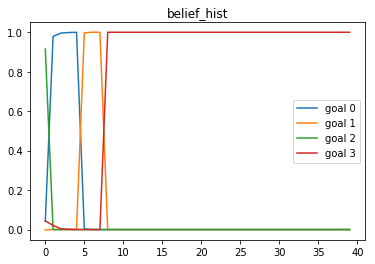

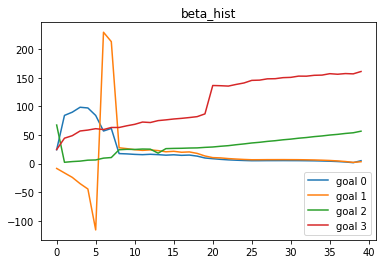

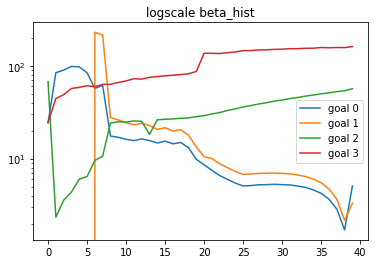

In [39]:
plot_inference(config, pour_red_trajs[0][0])

made it to end of env initialization
feat_list: ['efficiency']
feat_list: ['efficiency', 'learned_feature']
Planning with features: ['efficiency']


planning took: 0.343206167221
Planning with features: ['efficiency']
planning took: 0.44694685936
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.26892614365
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.42132902145
Planning with features: ['efficiency']
planning took: 0.407027959824
planned goal traj len 40
Planning with features: ['efficiency']
planning took: 0.467345952988
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.24450492859
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.27432394028
planned goal traj len 40
inference time: 3.45359492302
Planning with features: ['efficiency']
planning took: 0.0146641731262
planned goal traj len 39
Planning with features: ['efficiency']
planning took: 0.0152678489685
planned goal traj len 39
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.01139688492
planned goal t

planning took: 0.832495212555
planned goal traj len 22
Planning with features: ['efficiency' 'learned_feature']
planning took: 3.30904603004
planned goal traj len 22
inference time: 4.26399111748
Planning with features: ['efficiency']
planning took: 0.0168159008026
planned goal traj len 21
Planning with features: ['efficiency']
planning took: 0.0143051147461
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.59812688828
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 3.98448514938
planned goal traj len 21
inference time: 5.68989706039
Planning with features: ['efficiency']
planning took: 0.0178260803223
planned goal traj len 20
Planning with features: ['efficiency']
planning took: 0.0163629055023
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.984941005707
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
pla

planning took: 0.194610834122
planned goal traj len 3
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.884147167206
planned goal traj len 3
inference time: 1.18779993057
Planning with features: ['efficiency']
planning took: 0.0246949195862
planned goal traj len 2
Planning with features: ['efficiency']
planning took: 0.0214049816132
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.0848271846771
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.943741083145
planned goal traj len 2
inference time: 1.13092303276
constraint_costs [ 0.08736462  7.26223884  0.29219769 12.94822695]
curr traj costs [1.88105842e+00 1.88105842e+00 2.17321502e+03 4.53768515e+04]
optimal_costs [9.87345007e-02 1.24195865e-01 3.09478545e+02 2.15611821e+04]
final suboptimality: [18.93652697 72.61998107  6.02312729  1.10516286]
final suboptimality/time: [0.46186651 1.77121905 0.14690554 0.02695519]


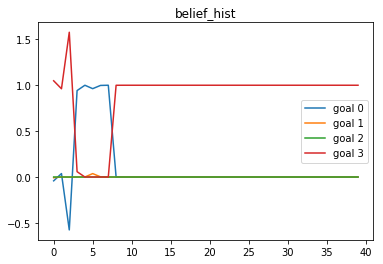

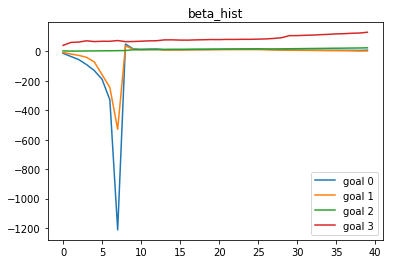

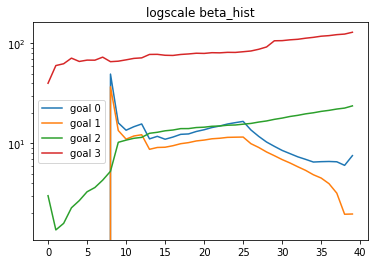

In [40]:
plot_inference(config, noisypour_red_trajs[0][0])

made it to end of env initialization
feat_list: ['efficiency']
feat_list: ['efficiency', 'learned_feature']
Planning with features: ['efficiency']


planning took: 0.306313991547
Planning with features: ['efficiency']
planning took: 0.330190896988
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.72105717659
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.80730485916
Planning with features: ['efficiency']
planning took: 0.444447994232
planned goal traj len 40
Planning with features: ['efficiency']
planning took: 0.537786006927
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.07353401184
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 5.13427805901
planned goal traj len 40
inference time: 8.28480696678
Planning with features: ['efficiency']
planning took: 0.0221939086914
planned goal traj len 39
Planning with features: ['efficiency']
planning took: 0.0376260280609
planned goal traj len 39
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.27629995346
planned goal 

planning took: 2.86287903786
planned goal traj len 22
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.782339096069
planned goal traj len 22
inference time: 3.75838017464
Planning with features: ['efficiency']
planning took: 0.0166771411896
planned goal traj len 21
Planning with features: ['efficiency']
planning took: 0.0130310058594
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 4.81250786781
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.913951873779
planned goal traj len 21
inference time: 5.82156395912
Planning with features: ['efficiency']
planning took: 0.0174691677094
planned goal traj len 20
Planning with features: ['efficiency']
planning took: 0.0170741081238
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
planning took: 3.13361907005
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
pla

planning took: 2.61754798889
planned goal traj len 3
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.479573011398
planned goal traj len 3
inference time: 3.18260288239
Planning with features: ['efficiency']
planning took: 0.014279127121
planned goal traj len 2
Planning with features: ['efficiency']
planning took: 0.0143308639526
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.45074486732
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.448158025742
planned goal traj len 2
inference time: 2.98080396652
constraint_costs [1.45263590e+01 2.28564996e+00 9.65272907e+00 2.29672091e-03]
curr traj costs [2.44561819e+00 2.44561819e+00 5.02852950e+03 1.17053108e+04]
optimal_costs [1.16316035e-01 1.00495152e-01 5.57801471e+02 2.24628354e+04]
final suboptimality: [144.9126175   46.07956597   8.03221394  -0.47890314]
final suboptimality/time: [ 3.53445409  1.12389185  0.195907

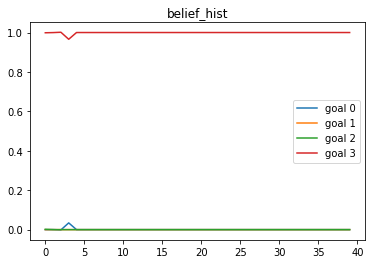

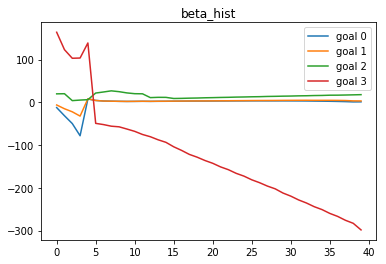

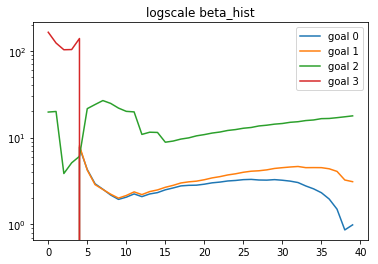

In [41]:
plot_inference(config, goto_green_trajs[0][0])

### With goal angles constraint

In [32]:
# retraining
import yaml
with open(parent_dir + '/config/teleop_inference.yaml') as f:
    config = yaml.load(f)
config['planner']['prefer_angles'] = True
config

{'controller': {'d_gain': 0.1,
  'epsilon': 0.1,
  'i_gain': 0.0,
  'max_cmd': 40.0,
  'p_gain': 1.0,
  'type': 'pid'},
 'learner': {'assistance_method': 'none',
  'beta_method': 'estimate',
  'beta_priors': [0, 0],
  'betas': [0.1, 1, 10.0],
  'goal_beliefs': 'none',
  'inference_method': 'dragan',
  'zero_input_assist': False},
 'planner': {'max_iter': 50,
  'num_waypts': 5,
  'prefer_angles': True,
  'type': 'trajopt'},
 'setup': {'T': 20.0,
  'common_feat_list': ['efficiency'],
  'common_feat_weights': [1.0],
  'goal_dist_feat_weight': 0.0,
  'goals': [[150.0, 130.0, 160.0, 240.0, 180.0, 172.0, 280.0],
   [210.0, 130.0, 200.0, 240.0, 180.0, 172.0, 280.0]],
  'learned_goals': [],
  'model_filename': 'jaco_dynamics',
  'object_centers': {'HUMAN_CENTER': [-0.6, -0.55, 0.0],
   'LAPTOP_CENTER': [-0.7929, -0.1, 0.0]},
  'prefix': 'j2s7s300_driver',
  'save_dir': '/data/teleoperation/',
  'start': [180.0, 150.0, 180.0, 270.0, 180.0, 180.0, 190.0],
  'timestep': 0.5}}

In [33]:
main, meirl = irl(config, NN_dict, IRL_dict, pour_red_trajs)
meirl.save('/root/catkin_ws/src/jaco_learning/data/pour_red_angles_c.pt')
main, meirl = irl(config, NN_dict, IRL_dict, goto_green_trajs)
meirl.save('/root/catkin_ws/src/jaco_learning/data/goto_green_angles_c.pt')
config['setup']['learned_goals'] = [
    '/root/catkin_ws/src/jaco_learning/data/pour_red_angles_c.pt',
    '/root/catkin_ws/src/jaco_learning/data/goto_green_angles_c.pt'
]
config['learner']['beta_priors'] = [0, 0, 0, 0]

made it to end of env initialization
Planning with features: ['efficiency']
planning took: 0.0317370891571
Planning with features: ['efficiency']
planning took: 0.0350649356842


Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.63059592247
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.339001893997
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.430802822113
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.346019029617
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 1:   2%|▏         | 1/50 [00:02<01:59,  2.45s/it, avg_loss=0.151]

planning took: 0.447088956833
iteration 0 time: 2.44544911385
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.418119192123
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.464215040207
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.270158052444
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.617140054703
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 2:   4%|▍         | 2/50 [00:04<01:55,  2.40s/it, avg_loss=-4.93]

planning took: 0.218019008636
iteration 1 time: 2.28956699371
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.792186975479
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.570233106613
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.577361106873
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.640558958054
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 3:   6%|▌         | 3/50 [00:08<02:06,  2.70s/it, avg_loss=-10.2]

planning took: 0.555344104767
iteration 2 time: 3.39246296883
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.986716985703
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.15062594414
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.82226896286
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.705958843231
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 4:   8%|▊         | 4/50 [00:12<02:31,  3.30s/it, avg_loss=-15.6]

planning took: 0.85274720192
iteration 3 time: 4.71054697037
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.764031887054
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.811795949936
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.709594964981
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.70432305336
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 5:  10%|█         | 5/50 [00:16<02:37,  3.50s/it, avg_loss=-22.1]

planning took: 0.729350090027
iteration 4 time: 3.95615100861
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.829509973526
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.60123205185
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.557484865189
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.799760103226
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 6:  12%|█▏        | 6/50 [00:22<03:06,  4.23s/it, avg_loss=-26.4]

planning took: 1.90964198112
iteration 5 time: 5.93606495857
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.9101858139
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.18109703064
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.95981097221
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.24017596245
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 7:  14%|█▍        | 7/50 [00:30<03:51,  5.39s/it, avg_loss=-29.6]

planning took: 0.557963848114
iteration 6 time: 8.08197188377
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.765282869339
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.00301599503
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.35968899727
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.868592023849
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 8:  16%|█▌        | 8/50 [00:36<03:52,  5.55s/it, avg_loss=-30.9]

planning took: 1.67136406898
iteration 7 time: 5.91093707085
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.99785804749
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.983269929886
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.577905893326
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.556173086166
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 9:  18%|█▊        | 9/50 [00:41<03:38,  5.33s/it, avg_loss=-32.6]

planning took: 0.478414058685
iteration 8 time: 4.82116889954
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.43543696404
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.45284795761
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.560040950775
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.586293935776
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 10:  20%|██        | 10/50 [00:47<03:41,  5.54s/it, avg_loss=-30.8]

planning took: 1.74714803696
iteration 9 time: 6.0227060318
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.39471316338
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.563629865646
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.84594988823
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.32206892967
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 11:  22%|██▏       | 11/50 [00:55<04:01,  6.20s/it, avg_loss=-25.5]

planning took: 1.41129517555
iteration 10 time: 7.74927306175
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.893395900726
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.615838050842
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.60319399834
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.34711813927
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 12:  24%|██▍       | 12/50 [01:00<03:44,  5.92s/it, avg_loss=-23.9]

planning took: 0.539556026459
iteration 11 time: 5.22905683517
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.67403888702
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.30389714241
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.6241850853
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.359764099121
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 13:  26%|██▌       | 13/50 [01:05<03:25,  5.56s/it, avg_loss=-24.2]

planning took: 0.521185874939
iteration 12 time: 4.73671293259
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.4204928875
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.543694019318
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.51517605782
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.41897201538
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 14:  28%|██▊       | 14/50 [01:13<03:48,  6.34s/it, avg_loss=-24.5]

planning took: 1.97294902802
iteration 13 time: 8.13516592979
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.62594485283
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.94658994675
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.47221302986
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.55355620384
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 15:  30%|███       | 15/50 [01:22<04:09,  7.12s/it, avg_loss=-28.4]

planning took: 1.05685997009
iteration 14 time: 8.93638014793
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.65229392052
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.81818985939
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.278273105621
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.62839102745
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 16:  32%|███▏      | 16/50 [01:29<04:02,  7.13s/it, avg_loss=-30.7]

planning took: 1.52088999748
iteration 15 time: 7.13268184662
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.6607029438
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.513845920563
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.5754840374
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.34942412376
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 17:  34%|███▍      | 17/50 [01:36<03:56,  7.17s/it, avg_loss=-33.8]

planning took: 0.961490154266
iteration 16 time: 7.26417303085
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 5.09083914757
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.332528114319
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.38323998451
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.73686480522
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 18:  36%|███▌      | 18/50 [01:48<04:34,  8.58s/it, avg_loss=-39.2]

planning took: 1.09001088142
iteration 17 time: 11.8704409599
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.35453915596
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 4.93547201157
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.417311906815
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.61508178711
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 19:  38%|███▊      | 19/50 [01:59<04:49,  9.34s/it, avg_loss=-52.3]

planning took: 0.541932821274
iteration 18 time: 11.0928859711
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.2983250618
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.30242109299
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.67258906364
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.38771605492
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 20:  40%|████      | 20/50 [02:17<05:54, 11.81s/it, avg_loss=-86.3]

planning took: 7.69626808167
iteration 19 time: 17.5703580379
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 7.10288310051
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.62474298477
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 7.25864982605
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.36109399796
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 21:  42%|████▏     | 21/50 [02:39<07:11, 14.87s/it, avg_loss=-110] 

planning took: 1.40310502052
iteration 20 time: 22.0132369995
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 7.22042393684
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.16876387596
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.15377306938
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 4.41600799561
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 22:  44%|████▍     | 22/50 [02:54<07:00, 15.00s/it, avg_loss=-135]

planning took: 1.15075993538
iteration 21 time: 15.290692091
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.304264783859
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.09728503227
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.45187187195
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.20771312714
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 23:  46%|████▌     | 23/50 [03:06<06:15, 13.90s/it, avg_loss=-162]

planning took: 4.03220295906
iteration 22 time: 11.3210570812
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.932590961456
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.23234009743
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.4670958519
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 5.63563013077
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 24:  48%|████▊     | 24/50 [03:21<06:14, 14.41s/it, avg_loss=-193]

planning took: 3.10232400894
iteration 23 time: 15.5929617882
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 8.32297801971
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 8.56695199013
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.957961082458
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 5.57982516289
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 25:  50%|█████     | 25/50 [03:47<07:25, 17.81s/it, avg_loss=-234]

planning took: 2.10082697868
iteration 24 time: 25.739233017
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 10.6181828976
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.4687628746
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.85559797287
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 4.16829800606
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 26:  52%|█████▏    | 26/50 [04:12<08:02, 20.09s/it, avg_loss=-284]

planning took: 5.07914400101
iteration 25 time: 25.4024968147
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.89379096031
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.871998071671
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 5.47090983391
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 5.29897212982
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 27:  54%|█████▍    | 27/50 [04:35<07:59, 20.84s/it, avg_loss=-344]

planning took: 7.83154511452
iteration 26 time: 22.5884160995
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.552565097809
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 7.86582303047
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.598857879639
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.38907194138
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 28:  56%|█████▌    | 28/50 [04:46<06:35, 17.98s/it, avg_loss=-404]

planning took: 0.652976036072
iteration 27 time: 11.3120510578
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.99228906631
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 6.16589999199
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 8.4435942173
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.16273093224
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 29:  58%|█████▊    | 29/50 [05:09<06:49, 19.48s/it, avg_loss=-485]

planning took: 3.03270506859
iteration 28 time: 22.9721329212
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.78868889809
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.43799114227
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 5.37233805656
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.27286291122
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 30:  60%|██████    | 30/50 [05:22<05:48, 17.44s/it, avg_loss=-562]

planning took: 0.610774993896
iteration 29 time: 12.6694159508
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.48085689545
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.3683719635
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 8.4106900692
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.17339897156
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 31:  62%|██████▏   | 31/50 [05:38<05:25, 17.13s/it, avg_loss=-648]

planning took: 3.79200005531
iteration 30 time: 16.406195879
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.57067489624
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.70528078079
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 8.37235403061
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.22436690331
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 32:  64%|██████▍   | 32/50 [05:55<05:07, 17.06s/it, avg_loss=-753]

planning took: 2.79112315178
iteration 31 time: 16.8847119808
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.71770095825
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.33505010605
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.90970015526
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.16829705238
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 33:  66%|██████▌   | 33/50 [06:12<04:48, 17.00s/it, avg_loss=-882]

planning took: 8.49249911308
iteration 32 time: 16.8450269699
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.50795888901
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.74095010757
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.91522216797
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.1413500309
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 34:  68%|██████▊   | 34/50 [06:25<04:14, 15.88s/it, avg_loss=-1.01e+3]

planning took: 3.75629687309
iteration 33 time: 13.2825660706
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.76892495155
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.16075706482
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 6.03964591026
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.23899006844
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 35:  70%|███████   | 35/50 [06:36<03:35, 14.34s/it, avg_loss=-1.17e+3]

planning took: 0.29638004303
iteration 34 time: 10.7182941437
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.5280380249
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.30535912514
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.73712801933
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.16243314743
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 36:  72%|███████▏  | 36/50 [06:43<02:51, 12.25s/it, avg_loss=-1.32e+3]

planning took: 0.407527923584
iteration 35 time: 7.37198019028
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.68563103676
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.27925801277
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.65699601173
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.13998603821
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 37:  74%|███████▍  | 37/50 [06:54<02:33, 11.79s/it, avg_loss=-1.53e+3]

planning took: 3.72105407715
iteration 36 time: 10.7208819389
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.50043582916
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.34148097038
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.21669411659
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.0931289196
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 38:  76%|███████▌  | 38/50 [07:04<02:14, 11.18s/it, avg_loss=-1.7e+3] 

planning took: 3.35032701492
iteration 37 time: 9.73178100586
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.57028794289
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.06523895264
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.61269903183
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.14916205406
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 39:  78%|███████▊  | 39/50 [07:12<01:52, 10.25s/it, avg_loss=-1.94e+3]

planning took: 1.47455692291
iteration 38 time: 8.07951617241
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.34796595573
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.797523975372
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.37082791328
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.14826107025
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 40:  80%|████████  | 40/50 [07:18<01:30,  9.07s/it, avg_loss=-2.19e+3]

planning took: 1.41250300407
iteration 39 time: 6.30960988998
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.39995789528
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.88284611702
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.39644098282
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.20280694962
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 41:  82%|████████▏ | 41/50 [07:24<01:13,  8.20s/it, avg_loss=-2.46e+3]

planning took: 1.09825086594
iteration 40 time: 6.16985201836
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.07451200485
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.749909162521
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.2453019619
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.20508122444
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 42:  84%|████████▍ | 42/50 [07:30<00:59,  7.45s/it, avg_loss=-2.77e+3]

planning took: 1.21261191368
iteration 41 time: 5.70717215538
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.26836514473
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.985394001007
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.34808683395
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.725045919418
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 43:  86%|████████▌ | 43/50 [07:36<00:48,  6.91s/it, avg_loss=-3.08e+3]

planning took: 1.05923509598
iteration 42 time: 5.63246703148
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.26914191246
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.02316212654
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.07500100136
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.941669940948
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 44:  88%|████████▊ | 44/50 [07:41<00:39,  6.52s/it, avg_loss=-3.42e+3]

planning took: 1.06761908531
iteration 43 time: 5.59901499748
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.00251507759
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.508843898773
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.980502843857
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.741247177124
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 45:  90%|█████████ | 45/50 [07:46<00:29,  5.93s/it, avg_loss=-3.81e+3]

planning took: 1.12976884842
iteration 44 time: 4.5394821167
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.788064956665
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.31106495857
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.348162889481
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.07240700722
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 46:  92%|█████████▏| 46/50 [07:53<00:25,  6.40s/it, avg_loss=-4.13e+3]

planning took: 2.69538903236
iteration 45 time: 7.49604296684
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.26548504829
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.530766010284
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.176523923874
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.28977394104
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 47:  94%|█████████▍| 47/50 [07:58<00:17,  5.87s/it, avg_loss=-4.55e+3]

planning took: 1.12114500999
iteration 46 time: 4.63892388344
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.836512088776
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.711574077606
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.229410171509
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.21975207329
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 48:  96%|█████████▌| 48/50 [08:03<00:10,  5.45s/it, avg_loss=-5.03e+3]

planning took: 1.19655799866
iteration 47 time: 4.45205402374
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.830427885056
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.550661087036
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.290188074112
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.948854923248
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49:  98%|█████████▊| 49/50 [08:07<00:05,  5.00s/it, avg_loss=-5.55e+3]

planning took: 1.09491896629
iteration 48 time: 3.96753001213
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.924443006516
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.764124155045
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.303498983383
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.979846000671
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49: 100%|██████████| 50/50 [08:11<00:00,  9.83s/it, avg_loss=-6.07e+3]

planning took: 1.1494538784
iteration 49 time: 4.35989689827


made it to end of env initialization
Planning with features: ['efficiency']
planning took: 0.045459985733
Planning with features: ['efficiency']
planning took: 0.0448749065399


Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.748823881149
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.313369989395
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.29841709137
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.301218986511
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 1:   2%|▏         | 1/50 [00:02<02:01,  2.48s/it, avg_loss=-6.27]

planning took: 0.572881937027
iteration 0 time: 2.48083686829
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.506232023239
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.617074012756
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.488197088242
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.800727844238
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 2:   4%|▍         | 2/50 [00:05<02:10,  2.71s/it, avg_loss=-13]  

planning took: 0.55211687088
iteration 1 time: 3.2311630249
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.700313091278
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.501417160034
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.416218996048
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.519479036331
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 3:   6%|▌         | 3/50 [00:09<02:18,  2.95s/it, avg_loss=-20.6]

planning took: 1.13119101524
iteration 2 time: 3.5158970356
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.825943946838
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.53831911087
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.515266895294
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.506469011307
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 4:   8%|▊         | 4/50 [00:12<02:18,  3.02s/it, avg_loss=-31]  

planning took: 0.527678966522
iteration 3 time: 3.1542301178
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.820647001266
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.531368970871
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.751901865005
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.545426845551
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 5:  10%|█         | 5/50 [00:16<02:23,  3.20s/it, avg_loss=-43.2]

planning took: 0.722414016724
iteration 4 time: 3.61670088768
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.2260491848
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.837512016296
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.00005698204
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.970543861389
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 6:  12%|█▏        | 6/50 [00:20<02:41,  3.68s/it, avg_loss=-57.1]

planning took: 0.509573936462
iteration 5 time: 4.78028202057
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.15571594238
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.18280982971
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.546772003174
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.1740231514
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 7:  14%|█▍        | 7/50 [00:25<02:53,  4.03s/it, avg_loss=-75.3]

planning took: 0.564666032791
iteration 6 time: 4.8551659584
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.99937701225
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.06903910637
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.580070972443
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.56266117096
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 8:  16%|█▌        | 8/50 [00:33<03:39,  5.23s/it, avg_loss=-98.1]

planning took: 0.565658092499
iteration 7 time: 8.02425098419
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.98286604881
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.64873886108
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.98587799072
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.68349289894
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 9:  18%|█▊        | 9/50 [00:43<04:30,  6.59s/it, avg_loss=-124] 

planning took: 0.196516990662
iteration 8 time: 9.75969195366
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.2183868885
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.09026193619
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.73204398155
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.58373594284
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 10:  20%|██        | 10/50 [00:56<05:44,  8.61s/it, avg_loss=-150]

planning took: 3.48870992661
iteration 9 time: 13.2987580299
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.79437208176
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.36564779282
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 6.22860407829
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.44602584839
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 11:  22%|██▏       | 11/50 [01:11<06:43, 10.36s/it, avg_loss=-188]

planning took: 1.37805700302
iteration 10 time: 14.4394571781
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 9.02438902855
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 4.91650104523
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.69114685059
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 5.95209503174
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 12:  24%|██▍       | 12/50 [01:35<09:12, 14.53s/it, avg_loss=-236]

planning took: 1.47224497795
iteration 11 time: 24.2469961643
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 5.06455421448
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 8.47097396851
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 4.84885406494
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.78010296822
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 13:  26%|██▌       | 13/50 [02:05<11:47, 19.13s/it, avg_loss=-294]

planning took: 7.49020504951
iteration 12 time: 29.8726158142
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.23722696304
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.9136121273
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 6.53680205345
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 6.57589912415
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 14:  28%|██▊       | 14/50 [02:25<11:34, 19.30s/it, avg_loss=-363]

planning took: 2.18799877167
iteration 13 time: 19.6880850792
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 5.82399082184
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 4.144728899
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 8.27034902573
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 4.40938901901
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 15:  30%|███       | 15/50 [02:53<12:51, 22.05s/it, avg_loss=-445]

planning took: 5.56895709038
iteration 14 time: 28.4634459019
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.99742507935
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 5.62601494789
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.8418469429
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 4.32069301605
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 16:  32%|███▏      | 16/50 [03:13<12:09, 21.45s/it, avg_loss=-538]

planning took: 3.99949193001
iteration 15 time: 20.0254759789
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 6.58721899986
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.595156908035
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.9387588501
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.84466004372
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 17:  34%|███▍      | 17/50 [03:28<10:44, 19.52s/it, avg_loss=-648]

planning took: 1.83856797218
iteration 16 time: 15.0305960178
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.82934904099
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.55835294724
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 8.70250916481
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.68433523178
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 18:  36%|███▌      | 18/50 [03:48<10:24, 19.52s/it, avg_loss=-779]

planning took: 1.46281385422
iteration 17 time: 19.5200250149
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.6312379837
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 7.28493499756
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.327927827835
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.512405872345
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 19:  38%|███▊      | 19/50 [04:01<09:09, 17.73s/it, avg_loss=-924]

planning took: 3.56323313713
iteration 18 time: 13.5459358692
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.48753094673
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.343655109406
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.55115413666
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.367877960205
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 20:  40%|████      | 20/50 [04:08<07:17, 14.57s/it, avg_loss=-1.1e+3]

planning took: 1.26801609993
iteration 19 time: 7.20218610764
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.44292497635
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.53380799294
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.54253005981
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.298421144485
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 21:  42%|████▏     | 21/50 [04:14<05:49, 12.04s/it, avg_loss=-1.3e+3]

planning took: 1.0942530632
iteration 20 time: 6.11508083344
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.32460212708
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.3746778965
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.33142399788
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 5.64057183266
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 22:  44%|████▍     | 22/50 [04:26<05:36, 12.02s/it, avg_loss=-1.52e+3]

planning took: 1.13420987129
iteration 21 time: 11.9826519489
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.38823199272
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.82444190979
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.29744911194
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.31648492813
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 23:  46%|████▌     | 23/50 [04:34<04:45, 10.57s/it, avg_loss=-1.79e+3]

planning took: 1.12452888489
iteration 22 time: 7.16658306122
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.32631802559
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.97514390945
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.15057992935
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.52072405815
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 24:  48%|████▊     | 24/50 [04:42<04:20, 10.01s/it, avg_loss=-2.07e+3]

planning took: 1.48188877106
iteration 23 time: 8.71365904808
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.38353300095
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.47673892975
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.35518598557
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.33083295822
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 25:  50%|█████     | 25/50 [04:50<03:54,  9.39s/it, avg_loss=-2.4e+3] 

planning took: 1.16805791855
iteration 24 time: 7.93446302414
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.01721906662
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.3994820118
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.39675307274
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.31061887741
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 26:  52%|█████▏    | 26/50 [04:56<03:21,  8.39s/it, avg_loss=-2.77e+3]

planning took: 0.702090978622
iteration 25 time: 6.06177902222
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.66899800301
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.49011588097
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.28199982643
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.44540810585
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 27:  54%|█████▍    | 27/50 [05:05<03:13,  8.43s/it, avg_loss=-3.17e+3]

planning took: 1.35151791573
iteration 26 time: 8.50156903267
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.97234082222
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.26326394081
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.2707118988
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.42903399467
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 28:  56%|█████▌    | 28/50 [05:11<02:51,  7.82s/it, avg_loss=-3.63e+3]

planning took: 1.22685098648
iteration 27 time: 6.39322090149
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.60580205917
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.19680380821
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.24950790405
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.20524406433
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 29:  58%|█████▊    | 29/50 [05:18<02:37,  7.49s/it, avg_loss=-4.12e+3]

planning took: 1.20981311798
iteration 28 time: 6.72457194328
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.55109119415
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.26426100731
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.733911037445
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.13120603561
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 30:  60%|██████    | 30/50 [05:24<02:18,  6.93s/it, avg_loss=-4.66e+3]

planning took: 0.708451986313
iteration 29 time: 5.59991002083
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.975605964661
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.4187810421
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.993052959442
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.19489097595
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 31:  62%|██████▏   | 31/50 [05:29<02:05,  6.59s/it, avg_loss=-5.23e+3]

planning took: 0.954907178879
iteration 30 time: 5.80403780937
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.35846400261
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.1834089756
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.750600814819
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.16466879845
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 32:  64%|██████▍   | 32/50 [05:35<01:51,  6.18s/it, avg_loss=-5.89e+3]

planning took: 0.537594079971
iteration 31 time: 5.17647504807
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.972178936005
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.10932588577
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.805815935135
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.10641503334
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 33:  66%|██████▌   | 33/50 [05:39<01:38,  5.77s/it, avg_loss=-6.57e+3]

planning took: 0.613847970963
iteration 32 time: 4.8108458519
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.918791055679
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.08525681496
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.599153995514
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.20592594147
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 34:  68%|██████▊   | 34/50 [05:44<01:25,  5.37s/it, avg_loss=-7.33e+3]

planning took: 0.416192054749
iteration 33 time: 4.43595099449
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.924167871475
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.98427605629
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.659787893295
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.99592590332
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 35:  70%|███████   | 35/50 [05:48<01:16,  5.07s/it, avg_loss=-8.12e+3]

planning took: 0.569369077682
iteration 34 time: 4.3527238369
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.789871931076
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.23881101608
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.607558012009
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.16437888145
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 36:  72%|███████▏  | 36/50 [05:53<01:09,  4.96s/it, avg_loss=-8.99e+3]

planning took: 0.650014877319
iteration 35 time: 4.70172286034
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.00945901871
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.767056941986
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.825683116913
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.26374101639
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 37:  74%|███████▍  | 37/50 [05:58<01:04,  4.94s/it, avg_loss=-9.92e+3]

planning took: 0.785304069519
iteration 36 time: 4.89372396469
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.80101108551
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.08926606178
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.596359014511
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.836012840271
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 38:  76%|███████▌  | 38/50 [06:02<00:56,  4.71s/it, avg_loss=-1.09e+4]

planning took: 0.626157045364
iteration 37 time: 4.15405893326
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.913456916809
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.13236093521
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.360024929047
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.998559951782
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 39:  78%|███████▊  | 39/50 [06:06<00:50,  4.56s/it, avg_loss=-1.2e+4] 

planning took: 0.534492969513
iteration 38 time: 4.18539190292
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.728950023651
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.689572095871
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.404579877853
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.943983078003
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 40:  80%|████████  | 40/50 [06:10<00:42,  4.28s/it, avg_loss=-1.31e+4]

planning took: 0.614758968353
iteration 39 time: 3.61588311195
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.03814411163
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.949922084808
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.327334880829
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.750174999237
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 41:  82%|████████▏ | 41/50 [06:14<00:37,  4.17s/it, avg_loss=-1.44e+4]

planning took: 0.573688030243
iteration 40 time: 3.89910411835
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.899718999863
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.574234008789
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.329859972
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.12678098679
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 42:  84%|████████▍ | 42/50 [06:18<00:32,  4.05s/it, avg_loss=-1.56e+4]

planning took: 0.57259106636
iteration 41 time: 3.771048069
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.09839010239
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.765928030014
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.385315895081
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.01568293571
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 43:  86%|████████▌ | 43/50 [06:22<00:28,  4.06s/it, avg_loss=-1.7e+4] 

planning took: 0.590012073517
iteration 42 time: 4.07068800926
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.809303045273
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.580924034119
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.380919933319
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.04488277435
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 44:  88%|████████▊ | 44/50 [06:25<00:23,  3.93s/it, avg_loss=-1.85e+4]

planning took: 0.574597120285
iteration 43 time: 3.62383389473
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.06097817421
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.555147171021
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.503117084503
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.02995991707
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 45:  90%|█████████ | 45/50 [06:29<00:19,  3.94s/it, avg_loss=-2e+4]   

planning took: 0.531493902206
iteration 44 time: 3.95348906517
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.734133958817
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.471611976624
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.238748073578
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.797139883041
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 46:  92%|█████████▏| 46/50 [06:32<00:14,  3.65s/it, avg_loss=-2.17e+4]

planning took: 0.504364967346
iteration 45 time: 2.97209191322
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.09140396118
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.502954006195
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.345041036606
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.530511856079
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 47:  94%|█████████▍| 47/50 [06:35<00:10,  3.52s/it, avg_loss=-2.34e+4]

planning took: 0.534694910049
iteration 46 time: 3.22120785713
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.759319782257
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.539843082428
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.353392124176
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.72869515419
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 48:  96%|█████████▌| 48/50 [06:39<00:06,  3.43s/it, avg_loss=-2.53e+4]

planning took: 0.568674087524
iteration 47 time: 3.18839406967
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.939923048019
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.517967939377
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.315382957458
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.490677833557
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49:  98%|█████████▊| 49/50 [06:42<00:03,  3.31s/it, avg_loss=-2.71e+4]

planning took: 0.543190002441
iteration 48 time: 3.04127192497
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.766033172607
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.569000959396
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.36235499382
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.797566890717
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49: 100%|██████████| 50/50 [06:45<00:00,  8.11s/it, avg_loss=-2.92e+4]

planning took: 0.636405944824
iteration 49 time: 3.35765504837


made it to end of env initialization
feat_list: ['efficiency']


feat_list: ['efficiency', 'learned_feature']
Planning with features: ['efficiency']
planning took: 0.106662988663
Planning with features: ['efficiency']
planning took: 0.0777897834778
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.67585110664
Planning with features: ['efficiency' 'learned_feature']
planning took: 5.06647610664
Planning with features: ['efficiency']
planning took: 0.043851852417
planned goal traj len 40
Planning with features: ['efficiency']
planning took: 0.0449469089508
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 3.45268106461
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 5.85512900352
planned goal traj len 40
inference time: 9.59974598885
Planning with features: ['efficiency']
planning took: 0.0386619567871
planned goal traj len 39
Planning with features: ['efficiency']
planning took: 0.035413980484
planned goal traj len 39
Planning with 

planning took: 5.01739287376
planned goal traj len 23
inference time: 7.47965288162
Planning with features: ['efficiency']
planning took: 0.0289988517761
planned goal traj len 22
Planning with features: ['efficiency']
planning took: 0.0391590595245
planned goal traj len 22
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.28168201447
planned goal traj len 22
Planning with features: ['efficiency' 'learned_feature']
planning took: 7.13452005386
planned goal traj len 22
inference time: 9.71783804893
Planning with features: ['efficiency']
planning took: 0.0348999500275
planned goal traj len 21
Planning with features: ['efficiency']
planning took: 0.134095191956
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 3.54164600372
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 3.45726704597
planned goal traj len 21
inference time: 7.3584291935
Planning with features: ['efficien

planning took: 0.255704879761
planned goal traj len 4
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.33878898621
planned goal traj len 4
inference time: 2.7910759449
Planning with features: ['efficiency']
planning took: 0.0326731204987
planned goal traj len 3
Planning with features: ['efficiency']
planning took: 0.0373611450195
planned goal traj len 3
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.29957485199
planned goal traj len 3
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.44185686111
planned goal traj len 3
inference time: 2.95911812782
Planning with features: ['efficiency']
planning took: 0.122867107391
planned goal traj len 2
Planning with features: ['efficiency']
planning took: 0.0506210327148
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.328896045685
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took:

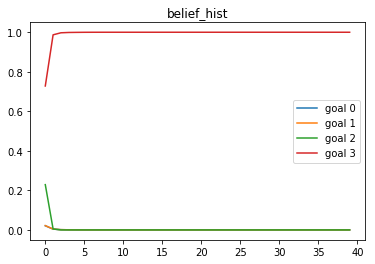

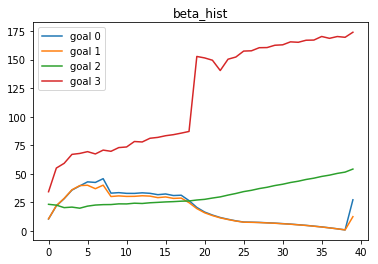

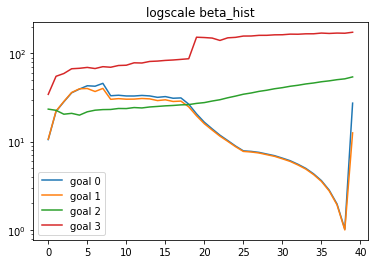

In [34]:
plot_inference(config, pour_red_trajs[0][0])

made it to end of env initialization
feat_list: ['efficiency']


feat_list: ['efficiency', 'learned_feature']
Planning with features: ['efficiency']
planning took: 0.0872249603271
Planning with features: ['efficiency']
planning took: 0.0600559711456
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.16134095192
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.55990409851
Planning with features: ['efficiency']
planning took: 0.0140650272369
planned goal traj len 40
Planning with features: ['efficiency']
planning took: 0.0252060890198
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 3.30641698837
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 8.74450302124
planned goal traj len 40
inference time: 12.2786448002
Planning with features: ['efficiency']
planning took: 0.0245771408081
planned goal traj len 39
Planning with features: ['efficiency']
planning took: 0.0319609642029
planned goal traj len 39
Planning wi

planning took: 8.87848687172
planned goal traj len 23
inference time: 9.95645880699
Planning with features: ['efficiency']
planning took: 0.0232229232788
planned goal traj len 22
Planning with features: ['efficiency']
planning took: 0.0358080863953
planned goal traj len 22
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.88356494904
planned goal traj len 22
Planning with features: ['efficiency' 'learned_feature']
planning took: 8.71842002869
planned goal traj len 22
inference time: 10.8557109833
Planning with features: ['efficiency']
planning took: 0.0288600921631
planned goal traj len 21
Planning with features: ['efficiency']
planning took: 0.0430519580841
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.65240502357
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 7.46180701256
planned goal traj len 21
inference time: 9.38169980049
Planning with features: ['effici

planning took: 0.218204975128
planned goal traj len 4
Planning with features: ['efficiency' 'learned_feature']
planning took: 7.33393788338
planned goal traj len 4
inference time: 7.73517489433
Planning with features: ['efficiency']
planning took: 0.0503950119019
planned goal traj len 3
Planning with features: ['efficiency']
planning took: 0.0321581363678
planned goal traj len 3
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.343580961227
planned goal traj len 3
Planning with features: ['efficiency' 'learned_feature']
planning took: 8.51682901382
planned goal traj len 3
inference time: 9.13344311714
Planning with features: ['efficiency']
planning took: 0.0471279621124
planned goal traj len 2
Planning with features: ['efficiency']
planning took: 0.0409619808197
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.428774118423
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning to

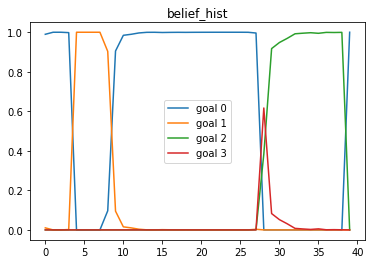

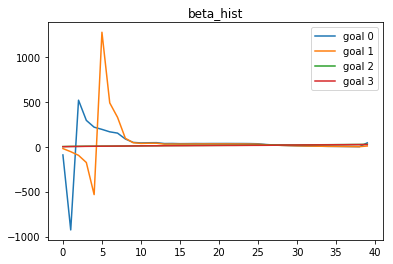

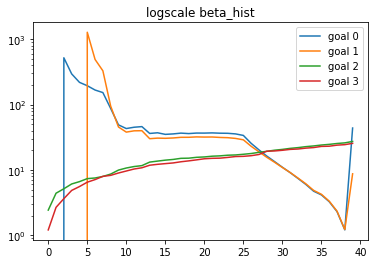

In [35]:
plot_inference(config, noisypour_red_trajs[0][0])

made it to end of env initialization
feat_list: ['efficiency']


feat_list: ['efficiency', 'learned_feature']
Planning with features: ['efficiency']
planning took: 0.0754380226135
Planning with features: ['efficiency']
planning took: 0.0444259643555
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.23062109947
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.72840499878
Planning with features: ['efficiency']
planning took: 0.0373849868774
planned goal traj len 40
Planning with features: ['efficiency']
planning took: 0.0368571281433
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.54938197136
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 4.01558899879
planned goal traj len 40
inference time: 6.90712094307
Planning with features: ['efficiency']
planning took: 0.113574981689
planned goal traj len 39
Planning with features: ['efficiency']
planning took: 0.159543037415
planned goal traj len 39
Planning with

planning took: 1.98723387718
planned goal traj len 23
inference time: 10.972730875
Planning with features: ['efficiency']
planning took: 0.0339839458466
planned goal traj len 22
Planning with features: ['efficiency']
planning took: 0.0455210208893
planned goal traj len 22
Planning with features: ['efficiency' 'learned_feature']
planning took: 9.09996604919
planned goal traj len 22
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.608481884
planned goal traj len 22
inference time: 10.9723370075
Planning with features: ['efficiency']
planning took: 0.037358045578
planned goal traj len 21
Planning with features: ['efficiency']
planning took: 0.0407571792603
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 9.19878411293
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.52468085289
planned goal traj len 21
inference time: 10.9839861393
Planning with features: ['efficiency

planning took: 4.91731715202
planned goal traj len 4
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.246982812881
planned goal traj len 4
inference time: 5.3397090435
Planning with features: ['efficiency']
planning took: 0.0739469528198
planned goal traj len 3
Planning with features: ['efficiency']
planning took: 0.0307199954987
planned goal traj len 3
Planning with features: ['efficiency' 'learned_feature']
planning took: 4.10636091232
planned goal traj len 3
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.278247117996
planned goal traj len 3
inference time: 4.75334191322
Planning with features: ['efficiency']
planning took: 0.0618619918823
planned goal traj len 2
Planning with features: ['efficiency']
planning took: 0.0511081218719
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 5.8533949852
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took:

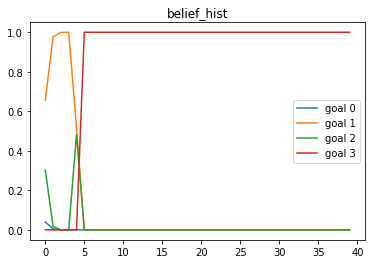

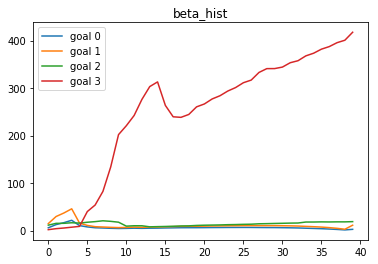

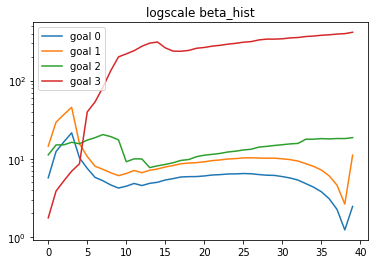

In [36]:
plot_inference(config, goto_green_trajs[0][0])

### With goal pose constraint, retrying with smaller efficiency weight

In [42]:
# retraining
import yaml
with open(parent_dir + '/config/teleop_inference.yaml') as f:
    config = yaml.load(f)
config['setup']['common_feat_weights'] = [0.2]
config

{'controller': {'d_gain': 0.1,
  'epsilon': 0.1,
  'i_gain': 0.0,
  'max_cmd': 40.0,
  'p_gain': 1.0,
  'type': 'pid'},
 'learner': {'assistance_method': 'none',
  'beta_method': 'estimate',
  'beta_priors': [0, 0],
  'betas': [0.1, 1, 10.0],
  'goal_beliefs': 'none',
  'inference_method': 'dragan',
  'zero_input_assist': False},
 'planner': {'max_iter': 50,
  'num_waypts': 5,
  'prefer_angles': False,
  'type': 'trajopt'},
 'setup': {'T': 20.0,
  'common_feat_list': ['efficiency'],
  'common_feat_weights': [0.2],
  'goal_dist_feat_weight': 0.0,
  'goals': [[150.0, 130.0, 160.0, 240.0, 180.0, 172.0, 280.0],
   [210.0, 130.0, 200.0, 240.0, 180.0, 172.0, 280.0]],
  'learned_goals': [],
  'model_filename': 'jaco_dynamics',
  'object_centers': {'HUMAN_CENTER': [-0.6, -0.55, 0.0],
   'LAPTOP_CENTER': [-0.7929, -0.1, 0.0]},
  'prefix': 'j2s7s300_driver',
  'save_dir': '/data/teleoperation/',
  'start': [180.0, 150.0, 180.0, 270.0, 180.0, 180.0, 190.0],
  'timestep': 0.5}}

In [43]:
main, meirl = irl(config, NN_dict, IRL_dict, pour_red_trajs)
meirl.save('/root/catkin_ws/src/jaco_learning/data/pour_red_pose_c_le.pt')
main, meirl = irl(config, NN_dict, IRL_dict, goto_green_trajs)
meirl.save('/root/catkin_ws/src/jaco_learning/data/goto_green_pose_c_le.pt')
config['setup']['learned_goals'] = [
    '/root/catkin_ws/src/jaco_learning/data/pour_red_pose_c_le.pt',
    '/root/catkin_ws/src/jaco_learning/data/goto_green_pose_c_le.pt'
]
config['learner']['beta_priors'] = [0, 0, 0, 0]

made it to end of env initialization
Planning with features: ['efficiency']


Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

planning took: 0.407408952713
Planning with features: ['efficiency']
planning took: 0.0260717868805
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.320759057999
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.144654035568
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.271061897278
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.142403841019
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 1:   2%|▏         | 1/50 [00:01<00:55,  1.13s/it, avg_loss=-.743]

planning took: 0.177565097809
iteration 0 time: 1.12923288345
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.37167596817
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.578440189362
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.279285907745
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.382032155991
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 2:   4%|▍         | 2/50 [00:03<01:07,  1.40s/it, avg_loss=-3.67]

planning took: 0.331986904144
iteration 1 time: 2.01497197151
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.193076133728
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.179379940033
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.418954133987
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.386598110199
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 3:   6%|▌         | 3/50 [00:04<01:09,  1.49s/it, avg_loss=-5.73]

planning took: 0.426648139954
iteration 2 time: 1.69342207909
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.512349843979
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.276588916779
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.48775601387
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.123505830765
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 4:   8%|▊         | 4/50 [00:06<01:12,  1.58s/it, avg_loss=-6.64]

planning took: 0.337023019791
iteration 3 time: 1.80376601219
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.245809078217
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.541087150574
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.389097929001
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.189632177353
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 5:  10%|█         | 5/50 [00:08<01:13,  1.62s/it, avg_loss=-7.88]

planning took: 0.243384838104
iteration 4 time: 1.71478700638
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.239601135254
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.611268997192
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.475279808044
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 6:  12%|█▏        | 6/50 [00:10<01:16,  1.73s/it, avg_loss=-8.61]

planning took: 0.461227178574
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.120778083801
iteration 5 time: 1.97559785843
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.33417892456
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.431046009064
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.943382024765
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.831616163254
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 7:  14%|█▍        | 7/50 [00:14<01:44,  2.43s/it, avg_loss=-6.48]

planning took: 0.464823007584
iteration 6 time: 4.07430005074
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.02274513245
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.141992092133
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.490735054016
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.470082998276
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 8:  16%|█▌        | 8/50 [00:17<01:44,  2.49s/it, avg_loss=-6.07]

planning took: 0.433584928513
iteration 7 time: 2.62619709969
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.59693408012
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.492108106613
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.953829050064
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 9:  18%|█▊        | 9/50 [00:21<02:00,  2.95s/it, avg_loss=-5.84]

planning took: 0.763168811798
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.140058994293
iteration 8 time: 4.01365995407
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.149607181549
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.536731958389
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.86799287796
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 10:  20%|██        | 10/50 [00:23<01:47,  2.70s/it, avg_loss=-5.98]

planning took: 0.421738147736
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0641388893127
iteration 9 time: 2.104129076
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.449021101
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.63976812363
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.497125864029
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 11:  22%|██▏       | 11/50 [00:28<02:15,  3.48s/it, avg_loss=-7.36]

planning took: 1.58699417114
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0609350204468
iteration 10 time: 5.29560899734
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.72962498665
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.458904981613
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.530081987381
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.37608408928
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 12:  24%|██▍       | 12/50 [00:34<02:37,  4.16s/it, avg_loss=-5.9] 

planning took: 0.573964118958
iteration 11 time: 5.74048495293
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.27757906914
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.82319188118
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.465436935425
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 13:  26%|██▌       | 13/50 [00:37<02:29,  4.04s/it, avg_loss=-7.24]

planning took: 1.04289102554
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0652549266815
iteration 12 time: 3.74933409691
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.34095406532
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.72412109375
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.567573070526
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.54357409477
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 14:  28%|██▊       | 14/50 [00:42<02:33,  4.26s/it, avg_loss=-8.94]

planning took: 0.534799814224
iteration 13 time: 4.78320407867
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.24749493599
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.363281011581
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.263311862946
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.679948091507
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.146799087524


Iteration 15:  30%|███       | 15/50 [00:46<02:24,  4.12s/it, avg_loss=-11.2]

iteration 14 time: 3.79241800308
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.39121389389
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.476083993912
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.553301095963
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 16:  32%|███▏      | 16/50 [00:50<02:19,  4.10s/it, avg_loss=-12.7]

planning took: 2.41598701477
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.137096166611
iteration 15 time: 4.0483880043
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.312643051147
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.391539812088
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.533043861389
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.743208885193
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 17:  34%|███▍      | 17/50 [00:53<02:03,  3.73s/it, avg_loss=-13.4]

planning took: 0.787386894226
iteration 16 time: 2.86243796349
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.654457807541
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.02302908897
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.188199043274
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 18:  36%|███▌      | 18/50 [00:55<01:45,  3.31s/it, avg_loss=-15.4]

planning took: 0.243098974228
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.130735874176
iteration 17 time: 2.3370308876
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.01892089844
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.843335866928
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.505563020706
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.540340900421
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 19:  38%|███▊      | 19/50 [01:01<02:02,  3.95s/it, avg_loss=-16.8]

planning took: 0.469631910324
iteration 18 time: 5.44753098488
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.311595916748
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.453819036484
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.475708007812
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.706427097321
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 20:  40%|████      | 20/50 [01:03<01:46,  3.55s/it, avg_loss=-18.1]

planning took: 0.571871042252
iteration 19 time: 2.59741687775
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.232412099838
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.557764053345
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.243118047714
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 21:  42%|████▏     | 21/50 [01:05<01:27,  3.02s/it, avg_loss=-19.4]

planning took: 0.580987930298
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0744910240173
iteration 20 time: 1.7832570076
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.69643497467
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.793534040451
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.152889966965
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.495674133301
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 22:  44%|████▍     | 22/50 [01:08<01:20,  2.88s/it, avg_loss=-22.1]

planning took: 0.335525035858
iteration 21 time: 2.55254101753
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.888859033585
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.851483106613
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.262644052505
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 23:  46%|████▌     | 23/50 [01:11<01:17,  2.88s/it, avg_loss=-25]  

planning took: 0.655440092087
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.146983861923
iteration 22 time: 2.8768119812
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.158372879028
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.222619056702
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.109110832214
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.596086978912
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 24:  48%|████▊     | 24/50 [01:12<01:06,  2.57s/it, avg_loss=-27.3]

planning took: 0.636504888535
iteration 23 time: 1.818598032
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.381615877151
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.19302487373
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.137758016586
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 25:  50%|█████     | 25/50 [01:14<00:59,  2.40s/it, avg_loss=-30]  

planning took: 0.108832120895
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0822520256042
iteration 24 time: 1.99441719055
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.164777040482
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.578366041183
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.417769193649
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0839021205902
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 26:  52%|█████▏    | 26/50 [01:16<00:52,  2.20s/it, avg_loss=-32.5]

planning took: 0.433526039124
iteration 25 time: 1.73955392838
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.166687965393
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.220389127731
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.139442205429
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 27:  54%|█████▍    | 27/50 [01:17<00:40,  1.78s/it, avg_loss=-36.1]

planning took: 0.106719017029
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0860991477966
iteration 26 time: 0.803379058838
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.115598917007
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.157012939453
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.121195077896
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.119961023331
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 28:  56%|█████▌    | 28/50 [01:19<00:41,  1.88s/it, avg_loss=-39.6]

planning took: 1.52805495262
iteration 27 time: 2.11951184273
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.37275099754
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.841361045837
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.468013048172
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0773329734802
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 29:  58%|█████▊    | 29/50 [01:22<00:47,  2.24s/it, avg_loss=-44.5]

planning took: 0.245012998581
iteration 28 time: 3.06929993629
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.574073076248
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.654050111771
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.98380208015
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0741019248962
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 30:  60%|██████    | 30/50 [01:27<00:58,  2.95s/it, avg_loss=-53.2]

planning took: 0.227929115295
iteration 29 time: 4.58360505104
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.464487075806
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.116533041
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.60920405388
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.242365837097
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 31:  62%|██████▏   | 31/50 [01:30<00:57,  3.00s/it, avg_loss=-57.7]

planning took: 0.608478069305
iteration 30 time: 3.12945604324
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.968383073807
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.112003087997
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.716030836105
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.55888795853
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 32:  64%|██████▍   | 32/50 [01:34<00:58,  3.27s/it, avg_loss=-64.6]

planning took: 0.444360971451
iteration 31 time: 3.89632511139
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.67188501358
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.137965917587
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.537837028503
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 33:  66%|██████▌   | 33/50 [01:36<00:50,  2.99s/it, avg_loss=-72.6]

planning took: 0.814227819443
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0805821418762
iteration 32 time: 2.33676099777
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.667694091797
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.12140583992
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.370704889297
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.33308601379
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.160716772079


Iteration 34:  68%|██████▊   | 34/50 [01:39<00:46,  2.92s/it, avg_loss=-76.2]

iteration 33 time: 2.74606394768
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.603259086609
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.835234880447
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.145330905914
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 35:  70%|███████   | 35/50 [01:42<00:42,  2.83s/it, avg_loss=-84.9]

planning took: 0.876842975616
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0878989696503
iteration 34 time: 2.62402796745
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.686127901077
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.83350801468
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.167582035065
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 36:  72%|███████▏  | 36/50 [01:45<00:41,  2.99s/it, avg_loss=-91.5]

planning took: 0.515881061554
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0831620693207
iteration 35 time: 3.36555099487
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.574567079544
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.599468946457
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.132780790329
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 37:  74%|███████▍  | 37/50 [01:48<00:37,  2.91s/it, avg_loss=-98.7]

planning took: 1.17966389656
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.131697893143
iteration 36 time: 2.71701478958
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.617112874985
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.369493961334
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0754511356354
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 38:  76%|███████▌  | 38/50 [01:49<00:31,  2.60s/it, avg_loss=-106] 

planning took: 0.598952054977
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.110661029816
iteration 37 time: 1.85979795456
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.55591917038
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.539408922195
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.095202922821
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 39:  78%|███████▊  | 39/50 [01:51<00:26,  2.40s/it, avg_loss=-118]

planning took: 0.56657910347
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.114639043808
iteration 38 time: 1.95255899429
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.495787143707
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.509649038315
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.198263883591
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.826513051987
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 40:  80%|████████  | 40/50 [01:54<00:24,  2.45s/it, avg_loss=-128]

planning took: 0.465718984604
iteration 39 time: 2.56994199753
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.460289955139
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.470150947571
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0951411724091
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 41:  82%|████████▏ | 41/50 [01:56<00:19,  2.18s/it, avg_loss=-139]

planning took: 0.378727912903
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0752530097961
iteration 40 time: 1.54341101646
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.479084968567
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.486854791641
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0788910388947
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 42:  84%|████████▍ | 42/50 [01:57<00:16,  2.01s/it, avg_loss=-145]

planning took: 0.415647983551
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0732231140137
iteration 41 time: 1.59654211998
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.525969982147
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.408086061478
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0869498252869
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 43:  86%|████████▌ | 43/50 [01:59<00:12,  1.84s/it, avg_loss=-162]

planning took: 0.274203062057
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0939340591431
iteration 42 time: 1.45521998405
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.480022907257
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.382900953293
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0828309059143
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 44:  88%|████████▊ | 44/50 [02:00<00:10,  1.70s/it, avg_loss=-174]

planning took: 0.254795074463
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0820331573486
iteration 43 time: 1.35021209717
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.336116790771
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.430480003357
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0798370838165
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 45:  90%|█████████ | 45/50 [02:01<00:07,  1.56s/it, avg_loss=-182]

planning took: 0.233793973923
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.083811044693
iteration 44 time: 1.23026013374
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.404386997223
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.371428966522
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0866849422455
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 46:  92%|█████████▏| 46/50 [02:02<00:05,  1.49s/it, avg_loss=-199]

planning took: 0.3149330616
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0835721492767
iteration 45 time: 1.32339286804
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.334582090378
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.411259889603
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0809350013733
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 47:  94%|█████████▍| 47/50 [02:04<00:04,  1.41s/it, avg_loss=-218]

planning took: 0.252710819244
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0880908966064
iteration 46 time: 1.23560619354
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.39904499054
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.502804994583
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0861928462982
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 48:  96%|█████████▌| 48/50 [02:05<00:02,  1.43s/it, avg_loss=-234]

planning took: 0.309301137924
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0893521308899
iteration 47 time: 1.45215010643
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.227775096893
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.405292034149
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.085550069809
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49:  98%|█████████▊| 49/50 [02:06<00:01,  1.32s/it, avg_loss=-251]

planning took: 0.185601949692
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0975248813629
iteration 48 time: 1.06934595108
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.339421033859
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.412039995193
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0815439224243
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49: 100%|██████████| 50/50 [02:07<00:00,  2.56s/it, avg_loss=-259]

planning took: 0.166565895081
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0986788272858
iteration 49 time: 1.16889810562


made it to end of env initialization
Planning with features: ['efficiency']


planning took: 0.215075969696
Planning with features: ['efficiency']


Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

planning took: 0.785403013229
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.228755950928
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.200960874557
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.180362939835
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 1:   2%|▏         | 1/50 [00:01<00:55,  1.14s/it, avg_loss=-2.61]

planning took: 0.32652592659
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.13756608963
iteration 0 time: 1.13613796234
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.347744941711
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.172680854797
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.437126874924
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.55563211441
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 2:   4%|▍         | 2/50 [00:03<01:06,  1.39s/it, avg_loss=-9.07]

planning took: 0.419304132462
iteration 1 time: 1.9941239357
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.638309955597
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.409017086029
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.253624916077
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.400886058807
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 3:   6%|▌         | 3/50 [00:05<01:15,  1.60s/it, avg_loss=-13.6]

planning took: 0.299025058746
iteration 2 time: 2.07107400894
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.506525993347
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.467432022095
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.481016874313
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.182187795639
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 4:   8%|▊         | 4/50 [00:07<01:21,  1.78s/it, avg_loss=-17.1]

planning took: 0.498860836029
iteration 3 time: 2.19990205765
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.212804079056
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.529100894928
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.430027008057
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.462707042694
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 5:  10%|█         | 5/50 [00:09<01:25,  1.90s/it, avg_loss=-20.6]

planning took: 0.485015153885
iteration 4 time: 2.18440318108
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.666494131088
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0764729976654
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.488658905029
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.784657001495
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 6:  12%|█▏        | 6/50 [00:12<01:31,  2.09s/it, avg_loss=-25.8]

planning took: 0.430661916733
iteration 5 time: 2.51168990135
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.04569101334
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.650288105011
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.351535081863
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.419893026352
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 7:  14%|█▍        | 7/50 [00:16<01:56,  2.70s/it, avg_loss=-28.7]

planning took: 0.584119796753
iteration 6 time: 4.13185787201
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.07533407211
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.480623006821
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.529985904694
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.285262107849
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 8:  16%|█▌        | 8/50 [00:18<01:53,  2.70s/it, avg_loss=-36.7]

planning took: 0.238023042679
iteration 7 time: 2.68377590179
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.268930912018
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0842990875244
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.267554044724
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 9:  18%|█▊        | 9/50 [00:20<01:34,  2.30s/it, avg_loss=-46.8]

planning took: 0.539337158203
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.126394033432
iteration 8 time: 1.34639811516
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.475374937057
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0998311042786
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 9:  20%|██        | 10/50 [00:21<01:18,  1.95s/it, avg_loss=-59.1]

planning took: 0.358526945114
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0773739814758
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.076229095459
iteration 9 time: 1.15457010269


Iteration 10:  20%|██        | 10/50 [00:21<01:18,  1.95s/it, avg_loss=-59.1]

Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.332216024399
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.11949300766
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.130185127258
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.124734163284
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 11:  22%|██▏       | 11/50 [00:22<01:04,  1.64s/it, avg_loss=-74.1]

planning took: 0.130754947662
iteration 10 time: 0.920763015747
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.195001125336
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.560638904572
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.185086011887
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.401926994324
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 12:  24%|██▍       | 12/50 [00:24<01:04,  1.69s/it, avg_loss=-92.6]

planning took: 0.368374109268
iteration 11 time: 1.79701709747
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.159489870071
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.304318189621
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.200690984726
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.319127082825
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 13:  26%|██▌       | 13/50 [00:25<00:59,  1.60s/it, avg_loss=-115] 

planning took: 0.324427127838
iteration 12 time: 1.37831687927
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.192497968674
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.195366859436
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.264437913895
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.161991834641
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 14:  28%|██▊       | 14/50 [00:26<00:51,  1.44s/it, avg_loss=-143]

planning took: 0.182494163513
iteration 13 time: 1.06480002403
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.116623878479
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.185866832733
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0848739147186
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.110370874405
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.183485031128


Iteration 15:  30%|███       | 15/50 [00:27<00:43,  1.23s/it, avg_loss=-177]

iteration 14 time: 0.755949020386
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.291715860367
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0924990177155
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.157095909119
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.100774049759
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 16:  32%|███▏      | 16/50 [00:28<00:39,  1.15s/it, avg_loss=-216]

planning took: 0.20790719986
iteration 15 time: 0.939070940018
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.217019081116
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0913560390472
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.122097015381
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.121339797974
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 17:  34%|███▍      | 17/50 [00:29<00:34,  1.03s/it, avg_loss=-265]

planning took: 0.103962898254
iteration 16 time: 0.753066062927
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.144551992416
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.129997968674
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0876290798187
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 18:  36%|███▌      | 18/50 [00:29<00:29,  1.08it/s, avg_loss=-321]

planning took: 0.125375986099
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.123355150223
iteration 17 time: 0.682181119919
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.283004999161
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0823199748993
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.139158010483
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0918259620667
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0879368782043


Iteration 19:  38%|███▊      | 19/50 [00:30<00:27,  1.13it/s, avg_loss=-387]

iteration 18 time: 0.770065069199
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.135761976242
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.109750032425
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0968060493469
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 19:  38%|███▊      | 19/50 [00:31<00:27,  1.13it/s, avg_loss=-465]

planning took: 0.110658168793
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.156850099564


Iteration 20:  40%|████      | 20/50 [00:31<00:24,  1.21it/s, avg_loss=-465]

iteration 19 time: 0.701709032059
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.210333108902
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.111865997314
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0955018997192
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.148534059525
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 21:  42%|████▏     | 21/50 [00:32<00:23,  1.23it/s, avg_loss=-554]

planning took: 0.123492956161
iteration 20 time: 0.76730799675
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.157805204391
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.115599870682
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.103263139725
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.150011062622
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 22:  44%|████▍     | 22/50 [00:32<00:22,  1.26it/s, avg_loss=-655]

planning took: 0.145385980606
iteration 21 time: 0.750520944595
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0944020748138
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0909950733185
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0945720672607
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 23:  46%|████▌     | 23/50 [00:33<00:19,  1.39it/s, avg_loss=-769]

planning took: 0.0855560302734
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.11149096489
iteration 22 time: 0.542520999908
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.194920063019
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0942480564117
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0818150043488
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.139904975891
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 24:  48%|████▊     | 24/50 [00:34<00:18,  1.40it/s, avg_loss=-895]

planning took: 0.118106842041
iteration 23 time: 0.705281972885
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.122373104095
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.11810708046
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0968430042267
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 25:  50%|█████     | 25/50 [00:34<00:17,  1.42it/s, avg_loss=-1.03e+3]

planning took: 0.148064136505
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.11785197258
iteration 24 time: 0.671060800552
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.513109207153
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0879209041595
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0773429870605
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 26:  52%|█████▏    | 26/50 [00:35<00:18,  1.29it/s, avg_loss=-1.19e+3]

planning took: 0.110913991928
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0883932113647
iteration 25 time: 0.940634012222
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.375443935394
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.119612932205
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0924651622772
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0946960449219
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 27:  54%|█████▍    | 27/50 [00:36<00:18,  1.24it/s, avg_loss=-1.36e+3]

planning took: 0.0955319404602
iteration 26 time: 0.874135971069
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.278367042542
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.089860200882
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.119396924973
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.110869884491
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 28:  56%|█████▌    | 28/50 [00:37<00:17,  1.24it/s, avg_loss=-1.54e+3]

planning took: 0.121675014496
iteration 27 time: 0.807813882828
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.141444921494
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.122029781342
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0926051139832
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 29:  58%|█████▊    | 29/50 [00:38<00:16,  1.30it/s, avg_loss=-1.75e+3]

planning took: 0.131086111069
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.118005990982
iteration 28 time: 0.676095962524
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.156543016434
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0979709625244
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0896639823914
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.122345924377
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 30:  60%|██████    | 30/50 [00:38<00:14,  1.35it/s, avg_loss=-1.97e+3]

planning took: 0.0842199325562
iteration 29 time: 0.671023845673
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.156012058258
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.135931015015
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.145205020905
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.127623081207
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 31:  62%|██████▏   | 31/50 [00:39<00:14,  1.33it/s, avg_loss=-2.2e+3] 

planning took: 0.129583120346
iteration 30 time: 0.770714998245
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.152427196503
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.178956031799
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.145019054413
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.118777990341
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 32:  64%|██████▍   | 32/50 [00:40<00:14,  1.27it/s, avg_loss=-2.46e+3]

planning took: 0.193271875381
iteration 31 time: 0.866549015045
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.122606992722
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.150496959686
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0896000862122
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 33:  66%|██████▌   | 33/50 [00:41<00:13,  1.30it/s, avg_loss=-2.73e+3]

planning took: 0.20117688179
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0942761898041
iteration 32 time: 0.730190992355
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.208577871323
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0974140167236
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.148882865906
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0996210575104
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 34:  68%|██████▊   | 34/50 [00:41<00:12,  1.31it/s, avg_loss=-3.03e+3]

planning took: 0.103369951248
iteration 33 time: 0.738299131393
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.131989955902
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.133787155151
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.092386007309
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 35:  70%|███████   | 35/50 [00:42<00:11,  1.36it/s, avg_loss=-3.35e+3]

planning took: 0.102437019348
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.13098692894
iteration 34 time: 0.670339107513
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.186024188995
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0911190509796
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.082170009613


Iteration 36:  72%|███████▏  | 36/50 [00:43<00:10,  1.39it/s, avg_loss=-3.68e+3]

Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.143924951553
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.104393959045
iteration 35 time: 0.679987192154
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.192356109619
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.10137295723
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.159551858902
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0969440937042
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 37:  74%|███████▍  | 37/50 [00:43<00:09,  1.36it/s, avg_loss=-4.04e+3]

planning took: 0.128695011139
iteration 36 time: 0.768238067627
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.136302947998
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.108222007751
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.109258174896
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 38:  76%|███████▌  | 38/50 [00:44<00:08,  1.38it/s, avg_loss=-4.43e+3]

planning took: 0.145426988602
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.128748893738
iteration 37 time: 0.698678970337
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.151453018188
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.100136995316
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.104448080063
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.116029977798
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 39:  78%|███████▊  | 39/50 [00:45<00:07,  1.41it/s, avg_loss=-4.84e+3]

planning took: 0.0974171161652
iteration 38 time: 0.669095039368
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.136907815933
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.108299970627
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.105801105499
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.108578920364
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 40:  80%|████████  | 40/50 [00:45<00:07,  1.41it/s, avg_loss=-5.27e+3]

planning took: 0.168757915497
iteration 39 time: 0.702373027802
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.126543045044
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.124768018723
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0976428985596
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 41:  82%|████████▏ | 41/50 [00:46<00:06,  1.45it/s, avg_loss=-5.73e+3]

planning took: 0.114317893982
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.109126091003
iteration 40 time: 0.64679980278
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.155473947525
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0921339988708
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0881450176239
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.113836050034
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 42:  84%|████████▍ | 42/50 [00:47<00:05,  1.50it/s, avg_loss=-6.21e+3]

planning took: 0.0876698493958
iteration 41 time: 0.614001989365
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.149962186813
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.149389028549
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.093160867691
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 43:  86%|████████▌ | 43/50 [00:48<00:04,  1.44it/s, avg_loss=-6.72e+3]

planning took: 0.183865070343
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.095358133316
iteration 42 time: 0.756035089493
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.219909906387
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0865800380707
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.108065128326
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.118119001389
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 44:  88%|████████▊ | 44/50 [00:48<00:04,  1.41it/s, avg_loss=-7.25e+3]

planning took: 0.134382009506
iteration 43 time: 0.736392021179
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.141412973404
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.130723953247
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.091325044632
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 45:  90%|█████████ | 45/50 [00:49<00:03,  1.41it/s, avg_loss=-7.82e+3]

planning took: 0.135993003845
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.116169929504
iteration 44 time: 0.702821969986
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.165307998657
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0923240184784
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.102458000183
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.139847993851
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 46:  92%|█████████▏| 46/50 [00:50<00:02,  1.41it/s, avg_loss=-8.4e+3] 

planning took: 0.132365942001
iteration 45 time: 0.704816102982
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.129469871521
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.120734214783
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0990371704102
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 47:  94%|█████████▍| 47/50 [00:50<00:02,  1.40it/s, avg_loss=-9.05e+3]

planning took: 0.1439909935
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.15033698082
iteration 46 time: 0.72495007515
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.132042884827
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.087415933609
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0773100852966
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 48:  96%|█████████▌| 48/50 [00:51<00:01,  1.47it/s, avg_loss=-9.69e+3]

planning took: 0.1210501194
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.118584156036
iteration 47 time: 0.597299098969
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.165884017944
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0914289951324
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0793371200562
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49:  98%|█████████▊| 49/50 [00:52<00:00,  1.49it/s, avg_loss=-1.04e+4]

planning took: 0.152817964554
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0915360450745
iteration 48 time: 0.651594877243
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.205362081528
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0945720672607
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0873200893402
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0936870574951
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49: 100%|██████████| 50/50 [00:52<00:00,  1.06s/it, avg_loss=-1.11e+4]

planning took: 0.111229896545
iteration 49 time: 0.681481838226


made it to end of env initialization
feat_list: ['efficiency']
feat_list: ['efficiency', 'learned_feature']
Planning with features: ['efficiency']


planning took: 0.592528104782
Planning with features: ['efficiency']
planning took: 0.156271934509
Planning with features: ['efficiency' 'learned_feature']
planning took: 3.67195296288
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.07016801834
Planning with features: ['efficiency']
planning took: 0.558813095093
planned goal traj len 40
Planning with features: ['efficiency']
planning took: 0.604964971542
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.17063093185
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.23614287376
planned goal traj len 40
inference time: 5.62975096703
Planning with features: ['efficiency']
planning took: 0.417726993561
planned goal traj len 39
Planning with features: ['efficiency']
planning took: 0.347795963287
planned goal traj len 39
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.951056003571
planned goal t

planning took: 1.31886911392
planned goal traj len 22
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.881184101105
planned goal traj len 22
inference time: 2.34079790115
Planning with features: ['efficiency']
planning took: 0.0398979187012
planned goal traj len 21
Planning with features: ['efficiency']
planning took: 0.0126738548279
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.38558411598
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.09201598167
planned goal traj len 21
inference time: 3.59469294548
Planning with features: ['efficiency']
planning took: 0.0397050380707
planned goal traj len 20
Planning with features: ['efficiency']
planning took: 0.0118360519409
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.926979064941
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
pla

planning took: 0.282701969147
planned goal traj len 3
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.764214992523
planned goal traj len 3
inference time: 1.11528992653
Planning with features: ['efficiency']
planning took: 0.0119438171387
planned goal traj len 2
Planning with features: ['efficiency']
planning took: 0.0087559223175
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.296662807465
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.19244098663
planned goal traj len 2
inference time: 1.55651283264
constraint_costs [0.25430657 0.75630669 0.022244   1.57723488]
curr traj costs [2.42334775e-01 2.42334775e-01 9.44168867e+02 4.13099781e+04]
optimal_costs [2.66504729e-02 7.79539545e-02 2.00637949e+02 1.92808896e+04]
final suboptimality: [17.63536717 11.81065822  3.70594478  1.14261667]
final suboptimality/time: [0.43013091 0.28806483 0.0903889  0.0278687 ]
beta: 

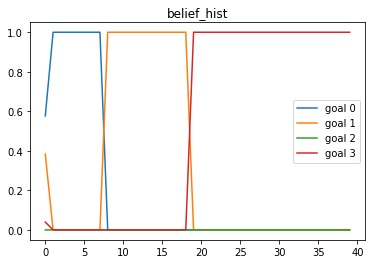

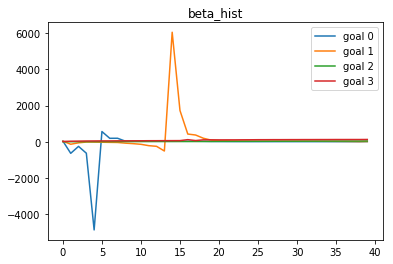

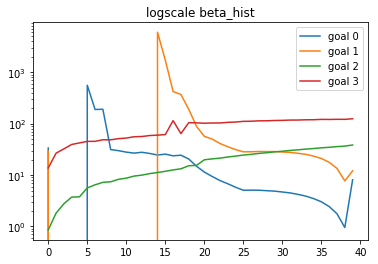

In [44]:
plot_inference(config, pour_red_trajs[0][0])

made it to end of env initialization
feat_list: ['efficiency']
feat_list: ['efficiency', 'learned_feature']
Planning with features: ['efficiency']


planning took: 0.527093887329
Planning with features: ['efficiency']
planning took: 0.489422798157
Planning with features: ['efficiency' 'learned_feature']
planning took: 3.67155122757
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.12126898766
Planning with features: ['efficiency']
planning took: 0.412105083466
planned goal traj len 40
Planning with features: ['efficiency']
planning took: 0.391258001328
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.4372010231
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 3.34081888199
planned goal traj len 40
inference time: 5.68956017494
Planning with features: ['efficiency']
planning took: 0.510153055191
planned goal traj len 39
Planning with features: ['efficiency']
planning took: 0.12127995491
planned goal traj len 39
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.21176290512
planned goal traj

planning took: 1.65621709824
planned goal traj len 22
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.85170698166
planned goal traj len 22
inference time: 3.58688402176
Planning with features: ['efficiency']
planning took: 0.0135130882263
planned goal traj len 21
Planning with features: ['efficiency']
planning took: 0.0122101306915
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.754025936127
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.40234708786
planned goal traj len 21
inference time: 2.23223400116
Planning with features: ['efficiency']
planning took: 0.0136938095093
planned goal traj len 20
Planning with features: ['efficiency']
planning took: 0.0114641189575
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.30257296562
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
plan

planning took: 0.803341150284
planned goal traj len 3
inference time: 0.933694124222
Planning with features: ['efficiency']
planning took: 0.0114769935608
planned goal traj len 2
Planning with features: ['efficiency']
planning took: 0.0144348144531
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.0600099563599
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.843487977982
planned goal traj len 2
inference time: 0.979786157608
constraint_costs [0.01747292 1.45244777 0.05843954 2.58964539]
curr traj costs [3.76211684e-01 3.76211684e-01 1.16102440e+03 4.19772991e+04]
optimal_costs [6.16468556e-02 6.55393760e-02 7.42117706e+02 2.29996429e+04]
final suboptimality: [ 5.38612632 26.90169156  0.56455348  0.8252409 ]
final suboptimality/time: [0.13136893 0.65613882 0.0137696  0.02012783]
beta: [[ 1.52597949e+01 -3.99005606e+00 -5.38400257e+01  7.39161221e+00]
 [-9.65000716e+00 -9.15970192e+00  4.430

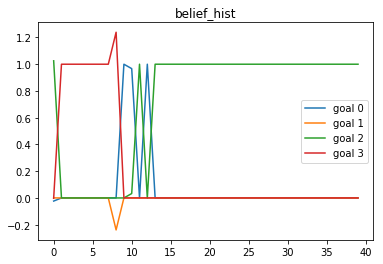

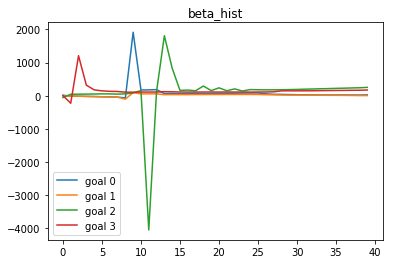

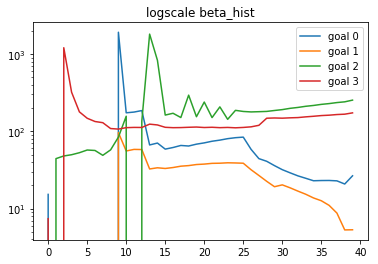

In [45]:
plot_inference(config, noisypour_red_trajs[0][0])

made it to end of env initialization
feat_list: ['efficiency']
feat_list: ['efficiency', 'learned_feature']
Planning with features: ['efficiency']


planning took: 0.450711011887
Planning with features: ['efficiency']
planning took: 0.651068925858
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.14678692818
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.71986103058
Planning with features: ['efficiency']
planning took: 0.34800696373
planned goal traj len 40
Planning with features: ['efficiency']
planning took: 0.35445690155
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.3212518692
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 3.33532094955
planned goal traj len 40
inference time: 5.45319509506
Planning with features: ['efficiency']
planning took: 0.0986092090607
planned goal traj len 39
Planning with features: ['efficiency']
planning took: 0.263356924057
planned goal traj len 39
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.86796402931
planned goal traj

planning took: 2.63877701759
planned goal traj len 22
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.77258181572
planned goal traj len 22
inference time: 3.53013300896
Planning with features: ['efficiency']
planning took: 0.014111995697
planned goal traj len 21
Planning with features: ['efficiency']
planning took: 0.017550945282
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.4136300087
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.585067987442
planned goal traj len 21
inference time: 3.08377981186
Planning with features: ['efficiency']
planning took: 0.0152430534363
planned goal traj len 20
Planning with features: ['efficiency']
planning took: 0.0164618492126
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.44678092003
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
plannin

planning took: 2.73274207115
planned goal traj len 3
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.0658960342407
planned goal traj len 3
inference time: 2.88884806633
Planning with features: ['efficiency']
planning took: 0.0125720500946
planned goal traj len 2
Planning with features: ['efficiency']
planning took: 0.0131471157074
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.63073897362
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.0625901222229
planned goal traj len 2
inference time: 2.76602911949
constraint_costs [2.90527180e+00 4.57129992e-01 1.93054581e+00 4.59344182e-04]
curr traj costs [4.89123637e-01 4.89123637e-01 1.85278040e+03 9.94117005e+03]
optimal_costs [1.52683773e-02 4.17647749e-02 8.68380244e+02 6.13685087e+03]
final suboptimality: [221.31540204  21.65673957   1.13582812   0.61991398]
final suboptimality/time: [5.39793664 0.52821316 0.027703

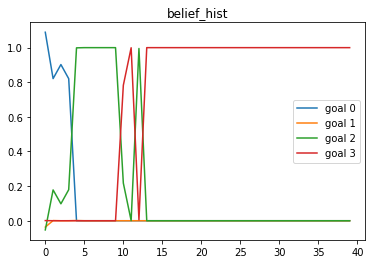

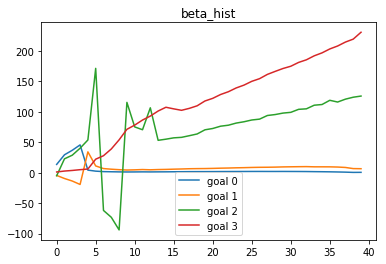

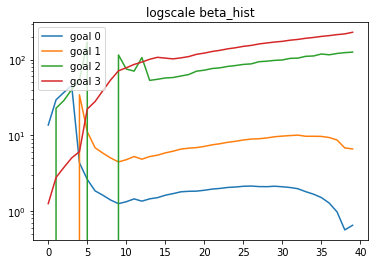

In [46]:
plot_inference(config, goto_green_trajs[0][0])

### Learning unconstrained, inference both ways

In [15]:
# retraining
import yaml
with open(parent_dir + '/config/teleop_inference.yaml') as f:
    config = yaml.load(f)
config['planner']['use_constraint_learned'] = False
config

{'controller': {'d_gain': 0.1,
  'epsilon': 0.1,
  'i_gain': 0.0,
  'max_cmd': 40.0,
  'p_gain': 1.0,
  'type': 'pid'},
 'learner': {'assistance_method': 'none',
  'beta_method': 'estimate',
  'beta_priors': [0, 0],
  'betas': [0.1, 1, 10.0],
  'goal_beliefs': 'none',
  'inference_method': 'dragan',
  'zero_input_assist': False},
 'planner': {'max_iter': 50,
  'num_waypts': 5,
  'prefer_angles': False,
  'type': 'trajopt',
  'use_constraint_learned': False},
 'setup': {'T': 20.0,
  'common_feat_list': ['efficiency'],
  'common_feat_weights': [1.0],
  'goal_dist_feat_weight': 0.0,
  'goals': [[150.0, 130.0, 160.0, 240.0, 180.0, 172.0, 280.0],
   [210.0, 130.0, 200.0, 240.0, 180.0, 172.0, 280.0]],
  'learned_goals': [],
  'model_filename': 'jaco_dynamics',
  'object_centers': {'HUMAN_CENTER': [-0.6, -0.55, 0.0],
   'LAPTOP_CENTER': [-0.7929, -0.1, 0.0]},
  'prefix': 'j2s7s300_driver',
  'save_dir': '/data/teleoperation/',
  'start': [180.0, 150.0, 180.0, 270.0, 180.0, 180.0, 190.0],
  't

In [16]:
main, meirl = irl(config, NN_dict, IRL_dict, pour_red_trajs)
meirl.save('/root/catkin_ws/src/jaco_learning/data/pour_red_pose_uc.pt')
main, meirl = irl(config, NN_dict, IRL_dict, goto_green_trajs)
meirl.save('/root/catkin_ws/src/jaco_learning/data/goto_green_pose_uc.pt')
config['setup']['learned_goals'] = [
    '/root/catkin_ws/src/jaco_learning/data/pour_red_pose_uc.pt',
    '/root/catkin_ws/src/jaco_learning/data/goto_green_pose_uc.pt'
]
config['learner']['beta_priors'] = [0, 0, 0, 0]

made it to end of env initialization
Planning with features: ['efficiency']


planning took: 0.287397146225
Planning with features: ['efficiency']


Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

planning took: 0.240462064743
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.28211808205
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.15899205208
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.21902394295
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.22756004333
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 1:   2%|▏         | 1/50 [00:09<07:32,  9.23s/it, avg_loss=-2.48]

planning took: 0.268355131149
iteration 0 time: 9.22781205177
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.57017397881
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.19265699387
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.12787604332
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.18282794952
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 2:   4%|▍         | 2/50 [00:20<07:52,  9.85s/it, avg_loss=-15.1]

planning took: 2.16837096214
iteration 1 time: 11.2986588478
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.109684944153
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.14865899086
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.07413101196
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 3:   6%|▌         | 3/50 [00:24<06:16,  8.02s/it, avg_loss=-25.8]

planning took: 1.23184895515
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0700619220734
iteration 2 time: 3.74713087082
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.992475032806
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.38734817505
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.22462797165
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.727576971054
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 4:   8%|▊         | 4/50 [00:32<06:08,  8.01s/it, avg_loss=-39.8]

planning took: 2.56969594955
iteration 3 time: 7.9746530056
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.468511104584
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.408928871155
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.785676956177
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.14471507072
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 5:  10%|█         | 5/50 [00:36<05:08,  6.86s/it, avg_loss=-56.2]

planning took: 1.31694412231
iteration 4 time: 4.1856470108
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.127655982971
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.451669931412
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.992350101471
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.851957082748
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 6:  12%|█▏        | 6/50 [00:39<04:10,  5.70s/it, avg_loss=-75]  

planning took: 0.480465888977
iteration 5 time: 2.98579120636
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.105551958084
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.654392957687
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.20552587509
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.397824048996
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 7:  14%|█▍        | 7/50 [00:42<03:30,  4.89s/it, avg_loss=-99.6]

planning took: 0.575836181641
iteration 6 time: 3.01164913177
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.117860078812
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.446623086929
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.386559009552
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.827785015106
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 8:  16%|█▌        | 8/50 [00:44<02:51,  4.08s/it, avg_loss=-131] 

planning took: 0.329859018326
iteration 7 time: 2.18849802017
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0689220428467
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.286468982697
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.830862045288
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.31205701828
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 9:  18%|█▊        | 9/50 [00:46<02:20,  3.42s/it, avg_loss=-167]

planning took: 0.322337865829
iteration 8 time: 1.87999796867
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.27267408371
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.268997192383
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.400007009506
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.479454040527
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 10:  20%|██        | 10/50 [00:48<01:58,  2.96s/it, avg_loss=-210]

planning took: 0.401577949524
iteration 9 time: 1.88575291634
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.323997020721
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.377050161362
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.532660961151
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.391391038895
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 11:  22%|██▏       | 11/50 [00:50<01:45,  2.71s/it, avg_loss=-257]

planning took: 0.410732984543
iteration 10 time: 2.10578799248
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.334011077881
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.447849035263
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.560163021088
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.414328098297
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 12:  24%|██▍       | 12/50 [00:52<01:36,  2.54s/it, avg_loss=-320]

planning took: 0.26483798027
iteration 11 time: 2.15911316872
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.279647111893
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.444461107254
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.579684972763
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.34755396843
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 13:  26%|██▌       | 13/50 [00:54<01:28,  2.40s/it, avg_loss=-384]

planning took: 0.29900598526
iteration 12 time: 2.0411131382
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.304159879684
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.379586935043
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.939119100571
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.334337949753
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 14:  28%|██▊       | 14/50 [00:57<01:25,  2.38s/it, avg_loss=-472]

planning took: 0.279799938202
iteration 13 time: 2.32516980171
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.186094999313
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.180721998215
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.827670097351
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.339630126953
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 15:  30%|███       | 15/50 [00:58<01:18,  2.24s/it, avg_loss=-569]

planning took: 0.339452028275
iteration 14 time: 1.93337488174
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.211414813995
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.210062980652
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.851386070251
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.316642045975
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 16:  32%|███▏      | 16/50 [01:00<01:12,  2.14s/it, avg_loss=-683]

planning took: 0.227339029312
iteration 15 time: 1.88956594467
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.204950809479
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.198750019073
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.11560702324
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.480365991592
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 17:  34%|███▍      | 17/50 [01:03<01:13,  2.23s/it, avg_loss=-813]

planning took: 0.356835126877
iteration 16 time: 2.43357610703
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.13202881813
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.235820055008
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.552921056747
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 18:  36%|███▌      | 18/50 [01:04<01:04,  2.00s/it, avg_loss=-968]

planning took: 0.330302000046
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.156925916672
iteration 17 time: 1.47538614273
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.144508838654
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.319082021713
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.350692033768
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 19:  38%|███▊      | 19/50 [01:06<00:56,  1.82s/it, avg_loss=-1.13e+3]

planning took: 0.421272993088
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0875158309937
iteration 18 time: 1.39147186279
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.141955852509
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.26287817955
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.448040962219
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 20:  40%|████      | 20/50 [01:07<00:52,  1.74s/it, avg_loss=-1.35e+3]

planning took: 0.502509832382
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0864150524139
iteration 19 time: 1.53727889061
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.206085920334
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.117321014404
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.480536937714
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 21:  42%|████▏     | 21/50 [01:09<00:47,  1.63s/it, avg_loss=-1.56e+3]

planning took: 0.436589956284
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0854380130768
iteration 20 time: 1.38833498955
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.137413024902
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0844759941101
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.458923816681
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 22:  44%|████▍     | 22/50 [01:10<00:42,  1.52s/it, avg_loss=-1.84e+3]

planning took: 0.375429868698
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.139621973038
iteration 21 time: 1.2552819252
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.18964099884
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.12113904953
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.39968419075
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.370158910751
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 23:  46%|████▌     | 23/50 [01:11<00:40,  1.51s/it, avg_loss=-2.13e+3]

planning took: 0.32403421402
iteration 22 time: 1.49473714828
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.144189834595
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.148535966873
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.43484711647
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 24:  48%|████▊     | 24/50 [01:13<00:37,  1.44s/it, avg_loss=-2.49e+3]

planning took: 0.37731385231
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0688591003418
iteration 23 time: 1.24922394753
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.203305006027
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0784139633179
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.476350069046
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 25:  50%|█████     | 25/50 [01:14<00:35,  1.40s/it, avg_loss=-2.85e+3]

planning took: 0.413650035858
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0873610973358
iteration 24 time: 1.31979799271
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.158882856369
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.127459049225
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.44367480278
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 26:  52%|█████▏    | 26/50 [01:15<00:33,  1.42s/it, avg_loss=-3.26e+3]

planning took: 0.504386901855
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.118782997131
iteration 25 time: 1.44621300697
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.15836596489
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.151483774185
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.469632863998
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 27:  54%|█████▍    | 27/50 [01:17<00:32,  1.43s/it, avg_loss=-3.73e+3]

planning took: 0.502884864807
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.107265949249
iteration 26 time: 1.46972084045
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.157140016556
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0984358787537
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.273195981979
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 28:  56%|█████▌    | 28/50 [01:18<00:28,  1.30s/it, avg_loss=-4.25e+3]

planning took: 0.29921913147
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0921890735626
iteration 27 time: 0.983901023865
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.155570030212
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0919961929321
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.468311071396
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 29:  58%|█████▊    | 29/50 [01:19<00:26,  1.28s/it, avg_loss=-4.81e+3]

planning took: 0.339416980743
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0909221172333
iteration 28 time: 1.21260380745
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.156061887741
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.105529069901
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.094172000885
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 30:  60%|██████    | 30/50 [01:20<00:22,  1.13s/it, avg_loss=-5.47e+3]

planning took: 0.268172025681
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0913219451904
iteration 29 time: 0.78965306282
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.150734186172
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0899360179901
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.128715991974
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 31:  62%|██████▏   | 31/50 [01:21<00:19,  1.02s/it, avg_loss=-6.16e+3]

planning took: 0.217014074326
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.114758014679
iteration 30 time: 0.77210021019
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.159093856812
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.117172002792
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0897741317749
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 32:  64%|██████▍   | 32/50 [01:21<00:17,  1.04it/s, avg_loss=-6.83e+3]

planning took: 0.229822158813
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.152225017548
iteration 31 time: 0.824414968491
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.185842990875
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.102698087692
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.16891503334
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 33:  66%|██████▌   | 33/50 [01:22<00:16,  1.04it/s, avg_loss=-7.72e+3]

planning took: 0.326488018036
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0746750831604
iteration 32 time: 0.95055603981
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.171060085297
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.101924180984
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.100494861603
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 34:  68%|██████▊   | 34/50 [01:23<00:14,  1.07it/s, avg_loss=-8.59e+3]

planning took: 0.320470094681
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0928719043732
iteration 33 time: 0.861087083817
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.15873003006
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0851099491119
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.125876188278
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.16915512085


Iteration 35:  70%|███████   | 35/50 [01:24<00:13,  1.12it/s, avg_loss=-9.5e+3] 

Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.151966094971
iteration 34 time: 0.792926073074
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0981440544128
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0907731056213
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0785720348358
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 36:  72%|███████▏  | 36/50 [01:25<00:11,  1.27it/s, avg_loss=-1.05e+4]

planning took: 0.140825033188
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0833809375763
iteration 35 time: 0.552822828293
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.146453857422
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.150241851807
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.110363006592
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 37:  74%|███████▍  | 37/50 [01:25<00:10,  1.26it/s, avg_loss=-1.17e+4]

planning took: 0.227558135986
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0976209640503
iteration 36 time: 0.802643060684
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.174597024918
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.112362861633
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.122786045074
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 38:  76%|███████▌  | 38/50 [01:26<00:10,  1.18it/s, avg_loss=-1.28e+4]

planning took: 0.354679107666
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.122424840927
iteration 37 time: 0.975440979004
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.157351016998
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0797481536865
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.138386011124
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.185141801834


Iteration 39:  78%|███████▊  | 39/50 [01:27<00:09,  1.22it/s, avg_loss=-1.4e+4] 

Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.10539484024
iteration 38 time: 0.745455980301
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.110512971878
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.116724967957
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.121024131775
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 40:  80%|████████  | 40/50 [01:28<00:08,  1.25it/s, avg_loss=-1.54e+4]

planning took: 0.199877023697
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.117048025131
iteration 39 time: 0.756123065948
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.140925884247
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0811312198639
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0739350318909
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 41:  82%|████████▏ | 41/50 [01:29<00:06,  1.29it/s, avg_loss=-1.68e+4]

planning took: 0.259906053543
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0864131450653
iteration 40 time: 0.710349082947
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.128365039825
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.152406930923
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.108667135239
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.101197004318
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 42:  84%|████████▍ | 42/50 [01:29<00:05,  1.34it/s, avg_loss=-1.82e+4]

planning took: 0.103559017181
iteration 41 time: 0.684673070908
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.142453193665
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.118942975998
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0810568332672
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 43:  86%|████████▌ | 43/50 [01:30<00:05,  1.36it/s, avg_loss=-1.99e+4]

planning took: 0.208023071289
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0998811721802
iteration 42 time: 0.709156036377
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.146081924438
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0922288894653
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0779490470886
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 44:  88%|████████▊ | 44/50 [01:31<00:04,  1.38it/s, avg_loss=-2.16e+4]

planning took: 0.188237905502
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.129477977753
iteration 43 time: 0.694962978363
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.154479980469
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0835270881653
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.120764970779
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.118827819824
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 45:  90%|█████████ | 45/50 [01:31<00:03,  1.42it/s, avg_loss=-2.34e+4]

planning took: 0.0945389270782
iteration 44 time: 0.645622968674
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.117718935013
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.125619888306
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.130836963654
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 46:  92%|█████████▏| 46/50 [01:32<00:02,  1.43it/s, avg_loss=-2.52e+4]

planning took: 0.151350021362
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.101521968842
iteration 45 time: 0.689521074295
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.134292840958
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.120301008224
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.144558906555
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.130317926407
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 47:  94%|█████████▍| 47/50 [01:33<00:02,  1.41it/s, avg_loss=-2.72e+4]

planning took: 0.121427059174
iteration 46 time: 0.731492042542
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.124913930893
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.142539024353
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.113269805908
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 48:  96%|█████████▌| 48/50 [01:34<00:01,  1.40it/s, avg_loss=-2.94e+4]

planning took: 0.187925100327
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0902252197266
iteration 47 time: 0.73131108284
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.179553031921
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.108522891998
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0837600231171
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.138078927994
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49:  98%|█████████▊| 49/50 [01:34<00:00,  1.35it/s, avg_loss=-3.15e+4]

planning took: 0.20444393158
iteration 48 time: 0.803189992905
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0900979042053
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0871160030365
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0934569835663
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49: 100%|██████████| 50/50 [01:35<00:00,  1.91s/it, avg_loss=-3.39e+4]

planning took: 0.102046012878
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.102764844894
iteration 49 time: 0.553258895874


made it to end of env initialization
Planning with features: ['efficiency']


planning took: 0.631968975067
Planning with features: ['efficiency']


Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

planning took: 0.411055088043
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.62647485733
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.62021708488
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.65017199516
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.834582090378
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 1:   2%|▏         | 1/50 [00:09<07:51,  9.62s/it, avg_loss=-5.8]

planning took: 2.81773900986
iteration 0 time: 9.61811280251
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.84646582603
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.40341997147
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 2.77319002151
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.11195611954
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 2:   4%|▍         | 2/50 [00:23<08:45, 10.94s/it, avg_loss=-29.6]

planning took: 2.8254699707
iteration 1 time: 14.0178329945
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.10047602654
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.446125984192
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.414575099945
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 3.11421394348
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 3:   6%|▌         | 3/50 [00:32<08:00, 10.22s/it, avg_loss=-57]  

planning took: 1.38813519478
iteration 2 time: 8.5222659111
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.48208999634
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.344477891922
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.389436006546
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 1.37526011467
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 4:   8%|▊         | 4/50 [00:37<06:38,  8.66s/it, avg_loss=-89.9]

planning took: 1.33270597458
iteration 3 time: 5.01591897011
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.570611953735
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.240842103958
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.214323043823
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.253422021866
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 5:  10%|█         | 5/50 [00:39<05:01,  6.70s/it, avg_loss=-129] 

planning took: 0.753520965576
iteration 4 time: 2.11063289642
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.605221033096
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.256885051727
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.179894924164
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.299474000931
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 6:  12%|█▏        | 6/50 [00:41<03:58,  5.43s/it, avg_loss=-176]

planning took: 1.04119515419
iteration 5 time: 2.47539186478
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.557074069977
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.170480012894
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.238146066666
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.424503087997
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 7:  14%|█▍        | 7/50 [00:43<03:09,  4.40s/it, avg_loss=-232]

planning took: 0.530735015869
iteration 6 time: 1.98696088791
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.132515907288
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.24472784996
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.146708965302
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.136345148087
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 8:  16%|█▌        | 8/50 [00:45<02:30,  3.58s/it, avg_loss=-299]

planning took: 0.925278902054
iteration 7 time: 1.64958095551
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.206114053726
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.175327062607
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.139779090881
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.111768007278
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 9:  18%|█▊        | 9/50 [00:46<01:57,  2.86s/it, avg_loss=-379]

planning took: 0.47540307045
iteration 8 time: 1.19430589676
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.133595228195
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.170239925385
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.112744092941
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.1231341362
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 10:  20%|██        | 10/50 [00:47<01:34,  2.36s/it, avg_loss=-480]

planning took: 0.555689096451
iteration 9 time: 1.16600513458
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.295473814011
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.310459136963
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0893940925598
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0995361804962
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 11:  22%|██▏       | 11/50 [00:49<01:21,  2.08s/it, avg_loss=-604]

planning took: 0.555694103241
iteration 10 time: 1.43879914284
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0959470272064
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.164035081863
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.133282184601
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0882060527802
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 12:  24%|██▍       | 12/50 [00:50<01:06,  1.75s/it, avg_loss=-755]

planning took: 0.41974902153
iteration 11 time: 0.977060079575
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.185393095016
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.146023035049
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.162661075592
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.100942134857
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 13:  26%|██▌       | 13/50 [00:51<00:58,  1.58s/it, avg_loss=-935]

planning took: 0.468872070312
iteration 12 time: 1.16203093529
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.226813077927
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.170092821121
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.168065071106
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0771369934082
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 14:  28%|██▊       | 14/50 [00:52<00:51,  1.44s/it, avg_loss=-1.16e+3]

planning took: 0.377650022507
iteration 13 time: 1.11546111107
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.103479146957
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.185836076736
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0852649211884
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.106954097748
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 15:  30%|███       | 15/50 [00:53<00:46,  1.34s/it, avg_loss=-1.41e+3]

planning took: 0.559233903885
iteration 14 time: 1.11196088791
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.149474143982
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.290745973587
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0963361263275
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0907459259033
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 16:  32%|███▏      | 16/50 [00:54<00:43,  1.28s/it, avg_loss=-1.71e+3]

planning took: 0.433036088943
iteration 15 time: 1.14479207993
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.159876823425
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.213712930679
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.111743927002
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.128515958786
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 17:  34%|███▍      | 17/50 [00:55<00:40,  1.23s/it, avg_loss=-2.06e+3]

planning took: 0.424885988235
iteration 16 time: 1.10681915283
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.106433153152
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.193068027496
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0957579612732
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.09739112854
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 18:  36%|███▌      | 18/50 [00:56<00:37,  1.16s/it, avg_loss=-2.47e+3]

planning took: 0.442894935608
iteration 17 time: 1.0032980442
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.136239051819
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.187058210373
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.10102391243
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.105652809143
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 19:  38%|███▊      | 19/50 [00:57<00:34,  1.12s/it, avg_loss=-2.94e+3]

planning took: 0.403481006622
iteration 18 time: 1.00393486023
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.109149932861
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.23844909668
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.127183914185
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.12159705162
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 20:  40%|████      | 20/50 [00:58<00:33,  1.11s/it, avg_loss=-3.48e+3]

planning took: 0.427086830139
iteration 19 time: 1.0948278904
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.116482973099
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.189912080765
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0754220485687
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0921139717102
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 21:  42%|████▏     | 21/50 [00:59<00:30,  1.05s/it, avg_loss=-4.08e+3]

planning took: 0.352999925613
iteration 20 time: 0.894267082214
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.137758970261
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.157561063766
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0844991207123
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.10076880455
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 22:  44%|████▍     | 22/50 [01:00<00:28,  1.01s/it, avg_loss=-4.76e+3]

planning took: 0.372771978378
iteration 21 time: 0.927083969116
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.114455938339
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.195605039597
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.110584974289
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.12845993042
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 23:  46%|████▌     | 23/50 [01:01<00:27,  1.02s/it, avg_loss=-5.54e+3]

planning took: 0.42054605484
iteration 22 time: 1.03025984764
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.146968126297
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.194023132324
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.111449956894
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.112166166306
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 24:  48%|████▊     | 24/50 [01:02<00:25,  1.03it/s, avg_loss=-6.4e+3] 

planning took: 0.21703004837
iteration 23 time: 0.847180843353
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.205541133881
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.27548789978
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.124074220657
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.108186006546
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 25:  50%|█████     | 25/50 [01:03<00:25,  1.04s/it, avg_loss=-7.37e+3]

planning took: 0.427034139633
iteration 24 time: 1.20732498169
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.116989850998
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.213099956512
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.142865180969
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 26:  52%|█████▏    | 26/50 [01:04<00:23,  1.03it/s, avg_loss=-8.44e+3]

planning took: 0.161396980286
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0963859558105
iteration 25 time: 0.806813001633
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.250658988953
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.247969865799
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.157621145248
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 27:  54%|█████▍    | 27/50 [01:05<00:22,  1.02it/s, avg_loss=-9.59e+3]

planning took: 0.141664981842
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.099023103714
iteration 26 time: 0.987666130066
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.207451820374
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.248450040817
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.215695142746
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.115345001221
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 28:  56%|█████▌    | 28/50 [01:06<00:21,  1.00it/s, avg_loss=-1.09e+4]

planning took: 0.154495000839
iteration 27 time: 1.04185509682
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.101431846619
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.203267097473
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.113108873367
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 29:  58%|█████▊    | 29/50 [01:07<00:19,  1.08it/s, avg_loss=-1.23e+4]

planning took: 0.166090965271
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0930371284485
iteration 28 time: 0.766103982925
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.162853002548
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0846788883209
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0727429389954
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 30:  60%|██████    | 30/50 [01:08<00:16,  1.22it/s, avg_loss=-1.38e+4]

planning took: 0.085718870163
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0899460315704
iteration 29 time: 0.574620008469
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.160249233246
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0888171195984
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.23299908638
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.131808996201
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 31:  62%|██████▏   | 31/50 [01:08<00:16,  1.18it/s, avg_loss=-1.55e+4]

planning took: 0.182792901993
iteration 30 time: 0.89442896843
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.126982927322
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.14759016037
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.131283998489
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 32:  64%|██████▍   | 32/50 [01:09<00:14,  1.21it/s, avg_loss=-1.73e+4]

planning took: 0.192788124084
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0901050567627
iteration 31 time: 0.770833015442
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.188946008682
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.104156970978
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.105181217194
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.161720991135
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 33:  66%|██████▌   | 33/50 [01:10<00:13,  1.24it/s, avg_loss=-1.92e+4]

planning took: 0.124587059021
iteration 32 time: 0.763343811035
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.14017701149
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.12531709671
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0975229740143
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 34:  68%|██████▊   | 34/50 [01:11<00:12,  1.28it/s, avg_loss=-2.13e+4]

planning took: 0.145029067993
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.098149061203
iteration 33 time: 0.714952945709
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.192049980164
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0964050292969
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0838670730591
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.122591972351
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 35:  70%|███████   | 35/50 [01:11<00:11,  1.34it/s, avg_loss=-2.36e+4]

planning took: 0.0912690162659
iteration 34 time: 0.674643993378
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.17261505127
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.102391004562
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0908720493317
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 36:  72%|███████▏  | 36/50 [01:12<00:10,  1.33it/s, avg_loss=-2.59e+4]

planning took: 0.182441949844
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.12801194191
iteration 35 time: 0.754778146744
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.269954919815
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.101462125778
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.159873962402
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.14321398735
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 37:  74%|███████▍  | 37/50 [01:13<00:10,  1.28it/s, avg_loss=-2.85e+4]

planning took: 0.1068379879
iteration 36 time: 0.857614040375
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.118859052658
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.104460000992
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0862290859222
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0813779830933


Iteration 38:  76%|███████▌  | 38/50 [01:14<00:08,  1.38it/s, avg_loss=-3.13e+4]

Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.106895923615
iteration 37 time: 0.586432933807
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.20685505867
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0865969657898
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0889749526978
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.127185821533
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 39:  78%|███████▊  | 39/50 [01:14<00:07,  1.39it/s, avg_loss=-3.42e+4]

planning took: 0.106869220734
iteration 38 time: 0.708160161972
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.11497592926
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.119921922684
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0898218154907
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 40:  80%|████████  | 40/50 [01:15<00:06,  1.44it/s, avg_loss=-3.73e+4]

planning took: 0.109802007675
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.124238014221
iteration 39 time: 0.627547979355
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.160419940948
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0952939987183
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0799539089203
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.187808990479


Iteration 41:  82%|████████▏ | 41/50 [01:16<00:06,  1.41it/s, avg_loss=-4.05e+4]

Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.135042905807
iteration 40 time: 0.752397060394
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.220015048981
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.127251148224
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.189768075943
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.122051954269
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 42:  84%|████████▍ | 42/50 [01:17<00:06,  1.31it/s, avg_loss=-4.41e+4]

planning took: 0.121109008789
iteration 41 time: 0.880281925201
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.122555971146
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.117555856705
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.116301059723
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 43:  86%|████████▌ | 43/50 [01:17<00:05,  1.29it/s, avg_loss=-4.77e+4]

planning took: 0.233836889267
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.118458032608
iteration 42 time: 0.796817064285
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.198781967163
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.179847002029
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0996909141541
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0812439918518


Iteration 44:  88%|████████▊ | 44/50 [01:18<00:04,  1.31it/s, avg_loss=-5.16e+4]

Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.104363918304
iteration 43 time: 0.743587017059
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.18137717247
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0823969841003
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.12410902977
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.103422880173
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 45:  90%|█████████ | 45/50 [01:19<00:03,  1.36it/s, avg_loss=-5.56e+4]

planning took: 0.089861869812
iteration 44 time: 0.6643679142
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.125156879425
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.112905025482
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.119635105133
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 46:  92%|█████████▏| 46/50 [01:20<00:02,  1.39it/s, avg_loss=-6e+4]   

planning took: 0.111755847931
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.112446069717
iteration 45 time: 0.682641983032
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.112009048462
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0899429321289
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0804028511047
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0972809791565
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 47:  94%|█████████▍| 47/50 [01:20<00:02,  1.47it/s, avg_loss=-6.44e+4]

planning took: 0.130198001862
iteration 46 time: 0.586150169373
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.149695158005
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.111541986465
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0978820323944
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 48:  96%|█████████▌| 48/50 [01:21<00:01,  1.47it/s, avg_loss=-6.92e+4]

planning took: 0.116466999054
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.12432718277
iteration 47 time: 0.681273937225
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.167418003082
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0800068378448
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.183599948883
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.123430013657
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49:  98%|█████████▊| 49/50 [01:22<00:00,  1.42it/s, avg_loss=-7.42e+4]

planning took: 0.120512962341
iteration 48 time: 0.754487991333
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0897099971771
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0808689594269
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.0887439250946
Planning with features: ['efficiency' 'learned_feature_new']


Iteration 49: 100%|██████████| 50/50 [01:22<00:00,  1.65s/it, avg_loss=-7.94e+4]

planning took: 0.0997269153595
Planning with features: ['efficiency' 'learned_feature_new']
planning took: 0.10053896904
iteration 49 time: 0.521683931351


### Inference using unconstrained planner

made it to end of env initialization
feat_list: ['efficiency']
feat_list: ['efficiency', 'learned_feature']
Planning with features: ['efficiency']


planning took: 0.580147981644
Planning with features: ['efficiency']
planning took: 0.352293968201
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.39964079857
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.46996808052
Planning with features: ['efficiency']
planning took: 0.459370851517
planned goal traj len 40
Planning with features: ['efficiency']
planning took: 0.485587835312
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.61595511436
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 5.02082109451
planned goal traj len 40
inference time: 7.65689897537
Planning with features: ['efficiency']
planning took: 0.374444961548
planned goal traj len 39
Planning with features: ['efficiency']
planning took: 0.381057977676
planned goal traj len 39
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.4037270546
planned goal tra

planning took: 1.61386799812
planned goal traj len 22
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.35700702667
planned goal traj len 22
inference time: 3.04437398911
Planning with features: ['efficiency']
planning took: 0.0136258602142
planned goal traj len 21
Planning with features: ['efficiency']
planning took: 0.0138230323792
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.960937976837
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.55327105522
planned goal traj len 21
inference time: 2.58814096451
Planning with features: ['efficiency']
planning took: 0.317858934402
planned goal traj len 20
Planning with features: ['efficiency']
planning took: 0.013571023941
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.9947078228
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
plannin

planning took: 1.31795096397
planned goal traj len 3
inference time: 1.45003080368
Planning with features: ['efficiency']
planning took: 0.0117478370667
planned goal traj len 2
Planning with features: ['efficiency']
planning took: 0.0133759975433
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.0574390888214
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.4929921627
planned goal traj len 2
inference time: 1.62912797928
constraint_costs [1.27153286 3.78153346 0.11121999 7.88617441]
curr traj costs [1.21167388e+00 1.21167388e+00 2.70328223e+04 7.53587806e+04]
optimal_costs [1.22315214e-01 9.39325000e-02 8.80211238e+03 2.96328694e+04]
final suboptimality: [19.30169959 52.15739854  2.07118704  1.54334691]
final suboptimality/time: [0.47077316 1.27213167 0.05051676 0.03764261]
beta: [[-1.47158637e+01 -1.60867177e+01 -1.00249638e+02  2.76128396e+00]
 [-2.75677809e+01 -2.30033382e+01  2.67253885

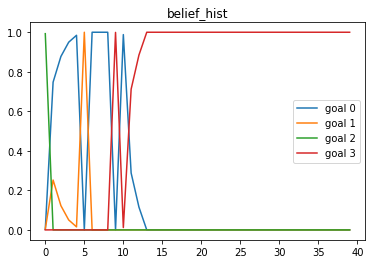

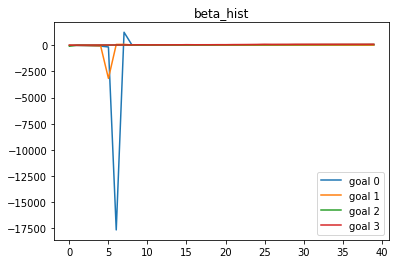

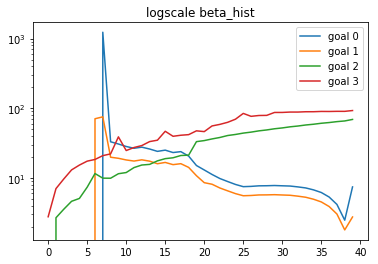

In [17]:
plot_inference(config, pour_red_trajs[0][0])

made it to end of env initialization
feat_list: ['efficiency']
feat_list: ['efficiency', 'learned_feature']
Planning with features: ['efficiency']


planning took: 0.388827085495
Planning with features: ['efficiency']
planning took: 0.345376968384
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.825376033783
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.41475820541
Planning with features: ['efficiency']
planning took: 0.387274980545
planned goal traj len 40
Planning with features: ['efficiency']
planning took: 0.302233934402
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.989490032196
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.82638001442
planned goal traj len 40
inference time: 4.55364990234
Planning with features: ['efficiency']
planning took: 0.0114080905914
planned goal traj len 39
Planning with features: ['efficiency']
planning took: 0.0110151767731
planned goal traj len 39
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.67534399033
planned goa

planning took: 0.967340946198
planned goal traj len 22
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.96856403351
planned goal traj len 22
inference time: 3.0434551239
Planning with features: ['efficiency']
planning took: 0.0152058601379
planned goal traj len 21
Planning with features: ['efficiency']
planning took: 0.013612985611
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.693104028702
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.0658769607544
planned goal traj len 21
inference time: 0.844791889191
Planning with features: ['efficiency']
planning took: 0.0148160457611
planned goal traj len 20
Planning with features: ['efficiency']
planning took: 0.0137851238251
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.161947965622
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
p

planning took: 0.157535791397
planned goal traj len 3
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.98713612556
planned goal traj len 3
inference time: 2.31157708168
Planning with features: ['efficiency']
planning took: 0.0140299797058
planned goal traj len 2
Planning with features: ['efficiency']
planning took: 0.0144319534302
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.103358983994
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.84613108635
planned goal traj len 2
inference time: 2.08098292351
constraint_costs [ 0.08736462  7.26223884  0.29219769 12.94822695]
curr traj costs [1.88105842e+00 1.88105842e+00 2.59764277e+04 7.91800105e+04]
optimal_costs [7.00262440e-02 1.51620969e-01 5.97449176e+03 3.85052721e+04]
final suboptimality: [27.10979034 59.30364619  3.34793802  1.05667833]
final suboptimality/time: [0.6612144  1.44643039 0.08165702 0.02577264]
bet

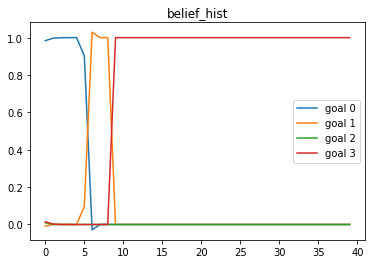

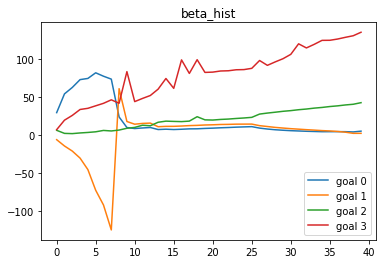

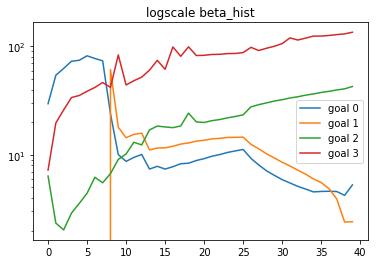

In [18]:
plot_inference(config, noisypour_red_trajs[0][0])

made it to end of env initialization
feat_list: ['efficiency']
feat_list: ['efficiency', 'learned_feature']
Planning with features: ['efficiency']


planning took: 0.364291906357
Planning with features: ['efficiency']
planning took: 0.34020113945
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.0357530117
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.23069787025
Planning with features: ['efficiency']
planning took: 0.295903921127
planned goal traj len 40
Planning with features: ['efficiency']
planning took: 0.236437082291
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.10201311111
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.25123500824
planned goal traj len 40
inference time: 2.94083595276
Planning with features: ['efficiency']
planning took: 0.0125379562378
planned goal traj len 39
Planning with features: ['efficiency']
planning took: 0.0109460353851
planned goal traj len 39
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.16800999641
planned goal tr

planning took: 2.26742696762
planned goal traj len 22
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.792810201645
planned goal traj len 22
inference time: 3.14204597473
Planning with features: ['efficiency']
planning took: 0.0177509784698
planned goal traj len 21
Planning with features: ['efficiency']
planning took: 0.0181322097778
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.02488017082
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.84115004539
planned goal traj len 21
inference time: 3.96311497688
Planning with features: ['efficiency']
planning took: 0.0151610374451
planned goal traj len 20
Planning with features: ['efficiency']
planning took: 0.0634701251984
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.01471090317
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
plan

planning took: 2.03114891052
planned goal traj len 3
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.0960340499878
planned goal traj len 3
inference time: 2.20481801033
Planning with features: ['efficiency']
planning took: 0.0156600475311
planned goal traj len 2
Planning with features: ['efficiency']
planning took: 0.0151000022888
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.104881048203
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.0682768821716
planned goal traj len 2
inference time: 0.257099151611
constraint_costs [1.45263590e+01 2.28564996e+00 9.65272907e+00 2.29672091e-03]
curr traj costs [2.44561819e+00 2.44561819e+00 5.36140353e+04 1.60653824e+04]
optimal_costs [1.02191128e-01 9.63943393e-02 8.22424618e+03 1.07991058e+04]
final suboptimality: [165.08073054  48.08242726   5.52019491   0.48765879]
final suboptimality/time: [4.02635928 1.17274213 0.1346

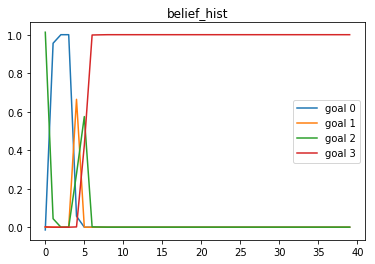

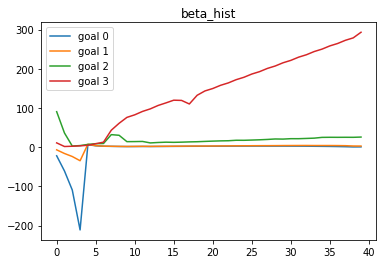

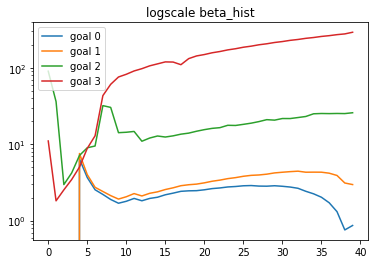

In [19]:
plot_inference(config, goto_green_trajs[0][0])

### Inference using constrained planner

In [20]:
config['planner']['use_constraint_learned'] = True

made it to end of env initialization
feat_list: ['efficiency']
feat_list: ['efficiency', 'learned_feature']
Planning with features: ['efficiency']


planning took: 0.424833059311
Planning with features: ['efficiency']
planning took: 0.458745002747
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.875500917435
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.87460398674
Planning with features: ['efficiency']
planning took: 0.325787067413
planned goal traj len 40
Planning with features: ['efficiency']
planning took: 0.376729011536
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.151679039
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 3.03562402725
planned goal traj len 40
inference time: 4.95737719536
Planning with features: ['efficiency']
planning took: 0.292721986771
planned goal traj len 39
Planning with features: ['efficiency']
planning took: 0.404751062393
planned goal traj len 39
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.11396098137
planned goal tra

planning took: 0.670399188995
planned goal traj len 22
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.21634197235
planned goal traj len 22
inference time: 1.96720910072
Planning with features: ['efficiency']
planning took: 0.156314849854
planned goal traj len 21
Planning with features: ['efficiency']
planning took: 0.0188210010529
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.951657056808
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.59596204758
planned goal traj len 21
inference time: 2.77406907082
Planning with features: ['efficiency']
planning took: 0.0966858863831
planned goal traj len 20
Planning with features: ['efficiency']
planning took: 0.0117340087891
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.65057015419
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
plan

planning took: 0.614133119583
planned goal traj len 3
inference time: 0.737689971924
Planning with features: ['efficiency']
planning took: 0.00973200798035
planned goal traj len 2
Planning with features: ['efficiency']
planning took: 0.010509967804
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.0591580867767
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.692588090897
planned goal traj len 2
inference time: 0.823440074921
constraint_costs [1.27153286 3.78153346 0.11121999 7.88617441]
curr traj costs [1.21167388e+00 1.21167388e+00 2.70328223e+04 7.53587806e+04]
optimal_costs [9.72595407e-02 7.57454450e-02 8.87806856e+03 3.37565512e+04]
final suboptimality: [24.53175468 64.92089248  2.04491155  1.23265304]
final suboptimality/time: [0.59833548 1.5834364  0.04987589 0.03006471]
beta: [[ 5.02485038e+02 -7.69261131e+01 -8.44578506e+01  1.42523488e+01]
 [-1.48741175e+02 -4.59653110e+01  3.990

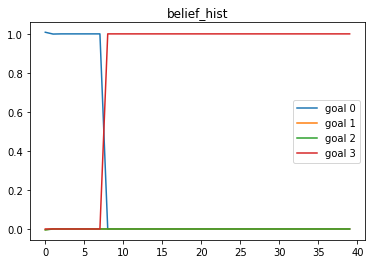

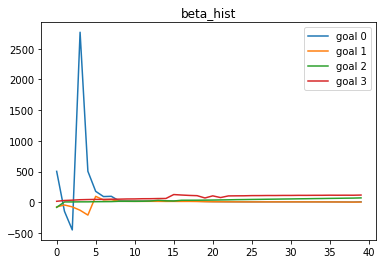

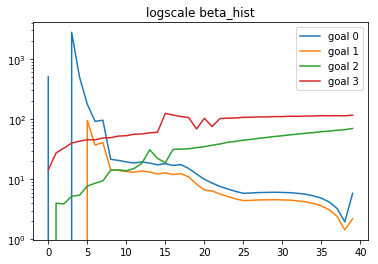

In [21]:
plot_inference(config, pour_red_trajs[0][0])

In [ ]:
plot_inference(config, pour_red_trajs[1][0])

made it to end of env initialization
feat_list: ['efficiency']
feat_list: ['efficiency', 'learned_feature']
Planning with features: ['efficiency']


planning took: 0.370537996292
Planning with features: ['efficiency']
planning took: 0.481668949127
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.2188129425
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.20730400085
Planning with features: ['efficiency']
planning took: 0.289759874344
planned goal traj len 40
Planning with features: ['efficiency']
planning took: 0.401156187057
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.51354503632
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.41504383087
planned goal traj len 40
inference time: 4.69170498848
Planning with features: ['efficiency']
planning took: 0.0109350681305
planned goal traj len 39
Planning with features: ['efficiency']
planning took: 0.0105550289154
planned goal traj len 39
Planning with features: ['efficiency' 'learned_feature']
planning took: 3.04949808121
planned goal t

planning took: 1.03509402275
planned goal traj len 22
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.55813503265
planned goal traj len 22
inference time: 2.67625403404
Planning with features: ['efficiency']
planning took: 0.0206401348114
planned goal traj len 21
Planning with features: ['efficiency']
planning took: 0.022891998291
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.04827404022
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.92375397682
planned goal traj len 21
inference time: 3.08039116859
Planning with features: ['efficiency']
planning took: 0.0192489624023
planned goal traj len 20
Planning with features: ['efficiency']
planning took: 0.0171902179718
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.747599840164
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
plann

planning took: 1.03101301193
planned goal traj len 3
inference time: 1.16150283813
Planning with features: ['efficiency']
planning took: 0.0169689655304
planned goal traj len 2
Planning with features: ['efficiency']
planning took: 0.0127630233765
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.0818479061127
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.991557121277
planned goal traj len 2
inference time: 1.16444015503
constraint_costs [ 0.08736462  7.26223884  0.29219769 12.94822695]
curr traj costs [1.88105842e+00 1.88105842e+00 2.59764277e+04 7.91800105e+04]
optimal_costs [5.98025061e-02 7.45201016e-02 9.60646054e+03 3.34562916e+04]
final suboptimality: [ 31.91539379 121.69571656   1.70408854   1.36705728]
final suboptimality/time: [0.77842424 2.96818821 0.04156314 0.03334286]
beta: [[ 10.34905212 273.62059323 -36.34982534  25.59443605]
 [ 21.72776167 193.42298158   4.26508029  43.81

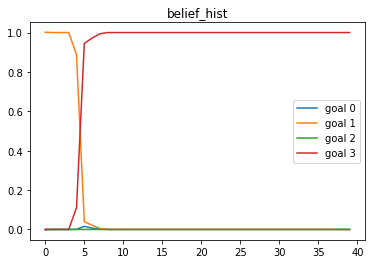

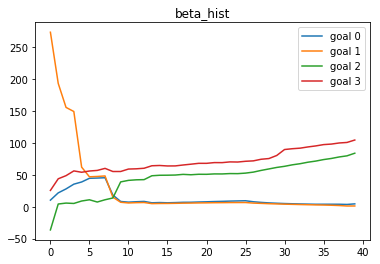

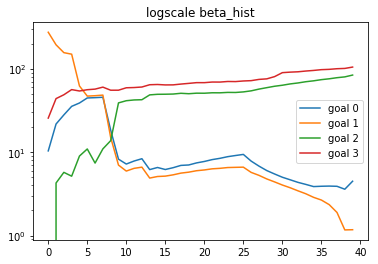

In [22]:
plot_inference(config, noisypour_red_trajs[0][0])

made it to end of env initialization
feat_list: ['efficiency']
feat_list: ['efficiency', 'learned_feature']
Planning with features: ['efficiency']


planning took: 0.468420028687
Planning with features: ['efficiency']
planning took: 0.455427885056
Planning with features: ['efficiency' 'learned_feature']
planning took: 3.55166196823
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.47037291527
Planning with features: ['efficiency']
planning took: 0.391407966614
planned goal traj len 40
Planning with features: ['efficiency']
planning took: 0.392929077148
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.61850309372
planned goal traj len 40
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.3997490406
planned goal traj len 40
inference time: 3.86548995972
Planning with features: ['efficiency']
planning took: 0.0112569332123
planned goal traj len 39
Planning with features: ['efficiency']
planning took: 0.0109951496124
planned goal traj len 39
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.4581580162
planned goal tr

planning took: 2.22170901299
planned goal traj len 22
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.520206928253
planned goal traj len 22
inference time: 2.81370997429
Planning with features: ['efficiency']
planning took: 0.0152130126953
planned goal traj len 21
Planning with features: ['efficiency']
planning took: 0.0140428543091
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.42549490929
planned goal traj len 21
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.0709819793701
planned goal traj len 21
inference time: 2.57300114632
Planning with features: ['efficiency']
planning took: 0.0143060684204
planned goal traj len 20
Planning with features: ['efficiency']
planning took: 0.0508069992065
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.35748314857
planned goal traj len 20
Planning with features: ['efficiency' 'learned_feature']
pl

planning took: 4.0134780407
planned goal traj len 3
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.14845085144
planned goal traj len 3
inference time: 4.231995821
Planning with features: ['efficiency']
planning took: 0.0248820781708
planned goal traj len 2
Planning with features: ['efficiency']
planning took: 0.0502691268921
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 2.96810102463
planned goal traj len 2
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.113860845566
planned goal traj len 2
inference time: 3.23710894585
constraint_costs [1.45263590e+01 2.28564996e+00 9.65272907e+00 2.29672091e-03]
curr traj costs [2.44561819e+00 2.44561819e+00 5.36140353e+04 1.60653824e+04]
optimal_costs [9.89837217e-02 4.56974386e-02 2.90850328e+04 9.13628567e+03]
final suboptimality: [170.46230581 102.53464646   0.8436867    0.75841532]
final suboptimality/time: [4.15761721 2.50084504 0.02057772 0.0

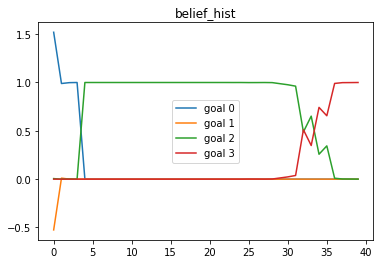

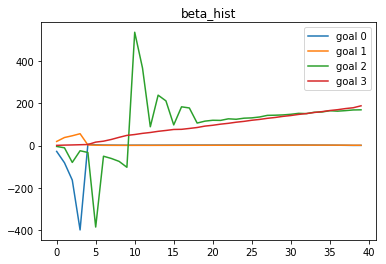

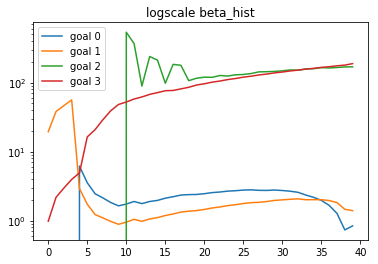

In [23]:
plot_inference(config, goto_green_trajs[0][0])

In [25]:
plot_inference(config, pour_red_trajs[0][0])

made it to end of env initialization
feat_list: ['efficiency']
feat_list: ['efficiency', 'learned_feature']
Planning with features: ['efficiency']


planning took: 0.349169969559
Planning with features: ['efficiency']
planning took: 0.412125110626
Planning with features: ['efficiency' 'learned_feature']
planning took: 1.1158349514
Planning with features: ['efficiency' 'learned_feature']
planning took: 0.460845947266
> <ipython-input-24-0696fccf416a>(136)setup_inference()
-> return main
(Pdb) common_weights
[1.0, 0, 0]
(Pdb) main.goal_weights
[array([1., 0., 0.]), array([1., 0., 0.]), array([1., 1., 0.]), array([1., 0., 1.])]
(Pdb) main.learner
(Pdb) main.learner.optimal_costs
array([1.35154955e-01, 1.18094101e-01, 8.52280011e+03, 8.99429021e+03])
(Pdb) q


BdbQuit: 

In [21]:
meirl.save('/root/catkin_ws/src/jaco_learning/data/goto_green_meirl.pt')

In [24]:
main, meirl = irl(config, NN_dict, IRL_dict, pour_red_trajs)

made it to end of env initialization
feat_list: ['efficiency']


Iteration 49: 100%|██████████| 50/50 [31:39<00:00, 38.00s/it, avg_loss=-15.3] 


In [25]:
meirl.save('/root/catkin_ws/src/jaco_learning/data/pour_red_meirl2.pt')

In [13]:
NN_dict = {'n_layers': 2, 'n_units':128,
           'sin':False, 'cos':False, 'noangles':True, 'norot':False,
           'rpy':False, 'lowdim':True, 'noxyz':True, 'EErot':True,
           '6D_laptop':False, '6D_human':False, '9D_coffee':False}

IRL_dict = {'n_iters': 50,
            'n_cur_rew_traj': 1,
            'lr':1e-3, 'weight_decay':0.001, 'std':0.01}

IRL = DeepMaxEntIRL(main.environment,
                    main.planner,
                    main.
                    s_g_exp_trajs=goto_green_trajs,
                    goal_poses=None,
                    known_feat_list=known_features,
                    NN_dict=NN_dict,
                    gen='waypt')

TypeError: __init__() takes at least 9 arguments (6 given)

In [27]:
main, meirl = irl(config, NN_dict, IRL_dict, pour_red_trajs)

made it to end of env initialization
feat_list: ['efficiency']


feat_list: ['efficiency', 'learned_feature']
feat_list: ['efficiency', 'learned_feature', 'learned_feature']


RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [16]:
# Before IRL: Compare the demonstration trajectories & the current cost induced trajectories
# Colors are the randomly initialized Neural Network cost function
plot_IRL_comparison(IRL, [61,64,67], 6)
#plot_IRL_comparison(IRL, frame_idx=6)

In [17]:
plot_IRL_comparison(IRL, frame_idx=6)

In [18]:
IRL.deep_max_ent_irl(n_iters=IRL_dict['n_iters'], n_cur_rew_traj=IRL_dict['n_cur_rew_traj'],
                     lr=IRL_dict['lr'], weight_decay=IRL_dict['weight_decay'], std=IRL_dict['std'])

Iteration 49: 100%|██████████| 50/50 [01:42<00:00,  2.05s/it, avg_loss=0]      


In [19]:
# After IRL: Compare the demonstration trajectories & the current cost induced trajectories
# Colors are the learned Neural Network cost function
plot_IRL_comparison(IRL, [61,64,67], 6)

# Visualize the learned cost function in 3D 

In [20]:
# plot GT
plot_gt3D(parent_dir, Expert.env)

ValueError: All arguments should have the same length. The length of argument `color` is 1, whereas the length of  previously-processed arguments ['x', 'y', 'z'] is 7656

In [21]:
# plot learned
plot_learned3D(parent_dir, IRL.function, IRL.env)

In [32]:
def save(self):
    torch.save({
        "known_feat_list": self.known_feat_list,
        "s_g_exp_trajs": Expert.return_trajs(),
        "goal_poses": self.goal_poses,
        "NN_dict": self.NN_dict,
        "gen": self.gen,
        "cost_nn_state_dict": self.cost_nn.state_dict(),
        "max_label": self.max_label,
        "min_label": self.min_label
    }, "/root/catkin_ws/src/jaco_learning/data/pour_red_meirl.pt")

In [33]:
save(IRL)

In [26]:
'test' in 'test1'

True

In [27]:
np.zeros(1)

array([0.])

In [29]:
np.hstack((np.arange(5), 5))

array([0, 1, 2, 3, 4, 5])

In [34]:
np.arange(5)[np.arange(5) > 3]

array([4])